In [1]:
!pip3 install pypolyagamma

     |████████████████████████████████| 235kB 7.4MB/s 
  Created wheel for pypolyagamma: filename=pypolyagamma-1.2.2-cp36-cp36m-linux_x86_64.whl size=577260 sha256=0f82e6a90e2f97d819ea973a5201cbd68d28d04e418d8fdf3280c63785dc05a7
  Stored in directory: /root/.cache/pip/wheels/ff/b4/34/046d7d99529aa5fe3ab7755a0a37885e6c0d1bdc601c146bf0
Successfully built pypolyagamma


In [0]:
from pypolyagamma import PyPolyaGamma

In [4]:
!git clone https://github.com/slinderman/ssm.git
%cd ssm
!pip install -e .

Cloning into 'ssm'...
remote: Enumerating objects: 364, done.
remote: Counting objects: 100% (364/364), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 2632 (delta 258), reused 272 (delta 173), pack-reused 2268
Receiving objects: 100% (2632/2632), 19.73 MiB | 13.74 MiB/s, done.
Resolving deltas: 100% (1843/1843), done.
/content/ssm
Obtaining file:///content/ssm
  Running setup.py develop for ssm


In [0]:
from ssm import messages

In [6]:
import numpy as np
import numpy.random as npr
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy.stats import multivariate_normal as MVN
from scipy.stats import invgamma
import sys

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Primitives

In [0]:
# Define the piecewise linear tanh approximation
class PiecewiseLinearSigmoid(object):
    """
    Piecewise linear approximation to sigma(x) with the specified 
    window size and number of linear parts.
    """
    def __init__(self, num_parts=16, window=4):
        self.num_parts = num_parts
        print('num_parts={}'.format(num_parts))
        self.knots = np.linspace(-window, window, num_parts-1)
        self.values = sigmoid(self.knots)

        # Compute slopes and intercepts for each bin
        self.slopes = np.concatenate(([0], np.diff(self.values) / np.diff(self.knots), [0]))
        self.intercepts = np.concatenate(([self.values[0]], self.values - self.slopes[1:] * self.knots))

    def f(self, x):
        z = np.digitize(x, self.knots)
        return self.intercepts[z] + self.slopes[z] * x
        
class PiecewiseLinearTanh(PiecewiseLinearSigmoid):
    def f(self, x):
        return 2 * super(PiecewiseLinearTanh, self).f(2 * x) - 1



In [0]:
# Define the piecewise linear sigmoid approximation
class StochPiecewiseLinearSigmoid(PiecewiseLinearSigmoid):
    """
    Stochastic p.w.l. approximation to sigma(x) with the specified 
    window size and number of linear parts.  Here, the discrete
    part is chosen randomly based on a tree-structured stick breaking
    of the interval.
    """
    def __init__(self,W,B,alpha,beta,sigmasq=None,num_parts=16, window=4, temp=0.25, Wbar_prior=None, Wbar_sigmasq=0):
        print('temp')
        print(temp)
        print('numparts')
        print(num_parts)
        print('Window')
        print(window)
        print('Wbar_prior:', Wbar_prior)
        print('Wbar_sigmasq:', Wbar_sigmasq)
        super(StochPiecewiseLinearSigmoid, self).__init__(num_parts, window)
        self.temp = temp
        self.W = W
        self.B = B 
        self.z=None
        self.output = None
        self.sigmasq_out = sigmasq
        self.ms=None
        self.Vs=None
        self.Wbar_prior = Wbar_prior
        self.Wbar_sigmasq = Wbar_sigmasq
        if len(alpha) > 0:
          self.alpha=alpha
          self.beta=beta        
        else:
          self.alpha = -1*np.ones((W.shape[0],1))
          self.beta = np.zeros((W.shape[0],1))


          


        # Precompute the transition probabilities on a dense grid        
        # num_pts = 1000
        # x = np.linspace(-1.5 * window, 1.5 * window, num_pts)
        # p = np.ones((num_pts, num_parts))

        # Get length of binary representation (i.e. depth of tree)
        decimal, depth = np.modf(np.log2(num_parts))
        assert np.allclose(decimal, 0), "number of parts must be a power of 2."
        depth = int(depth)
        self.depth = depth

        # Get a binary representation of each of the discrete parts
        self._bs = np.unpackbits(
            np.arange(self.num_parts, 
                      dtype=np.uint8)[:, None], axis=1)[:, -(self.depth):]

        # Precompute indices of decision knots for each discrete state
        mids = 2**np.arange(self.depth - 1, -1, -1)
        lefts = np.column_stack((np.zeros(self.num_parts), 
                                 np.cumsum(self._bs[:, :-1] * mids[:-1], axis=1)))
        self._inds = np.array(lefts + mids - 1, dtype=int)

    def get_inx(self, x, u):
      return self.W @ x  + self.B @ u
    
    def get_Wbar(self):
      Wbar = np.concatenate((self.W, self.B), axis=1)
      return Wbar

    def split_Wbar(self, Wbar):
      d = self.W.shape[0]
      ud = self.B.shape[1]
      self.W = Wbar[:,:d]
      self.B = Wbar[:,d:]

    def get_r(self,x,u):
      r = np.concatenate((x, u), axis=2)
      rrT = (r[:,...,None]*r[:,:,None,:])[:,:,:,:,0]
      return r, rrT  
    
    def f_given_z(self, x, z):
      return self.intercepts[z] + self.slopes[z] * x
    
    def f(self, x, return_z=False):
        """
        Sample a discrete state given x, then return the corresponding
        linear function of x.
        """
        x = np.atleast_1d(x)
        z = np.zeros_like(x, dtype=int)
        shp = x.shape
        for d in range(self.depth):
            mid = 2**(self.depth-d-1) - 1
            choice = npr.rand(*shp) < sigmoid((x - self.knots[z + mid]) / self.temp)
            z += choice * (mid + 1)
                
        if return_z:
            return StochPiecewiseLinearSigmoid.f_given_z(self,x,z), z
        else:
            return StochPiecewiseLinearSigmoid.f_given_z(self,x,z)

    def sample_output(self,x,u, return_z=False):
      inx = self.get_inx(x,u)
      if return_z == True:
        mu,z = self.f(inx,return_z)
        return mu + np.sqrt(self.sigmasq_out)*npr.randn(*mu.shape),z
      else:
        mu = self.f(inx)
        return mu + np.sqrt(self.sigmasq_out)*npr.randn(*mu.shape)
        
    def discrete_prior(self, x):
        """
        Get the prior on discrete states for input x
        """
        num_obs=x.shape[0]
        N = x.shape[1]
        d = x.shape[2]
        # To compute the posterior distribution of discrete states,
        # first evaluate sigmoids at each (input, knot) pair.
        s = sigmoid((x - self.knots[None,None, :]) / self.temp)
        oms = 1 - s
        # Discrete state probabilities are products of sigmoids for subsets
        # of knots.
        prior = np.ones((num_obs,N, d, self.num_parts))
        for k in range(self.num_parts):
            bk = self._bs[k]
            ik = self._inds[k]
            prior[:,:,:, k] = np.prod(s[:,:,:, ik[bk==1]], axis=3) * \
                          np.prod(oms[:,:,:, ik[bk==0]], axis=3)
        return prior


    def vectorized_sample_categorical(self, prob_matrix, items):
        prob_matrix=prob_matrix.T
        s = prob_matrix.cumsum(axis=0)
        r = np.random.rand(prob_matrix.shape[1])
        k = (s < r).sum(axis=0)
        return items[k]


    def resample_discrete_states(self, x, log_lkhd):
        """
        Sample discrete variable z given (input, output) pair (x, y) and 
        Gaussian noise variance sigmasq.
        """
        # Get the log prior on discrete states
        log_prior = np.log(self.discrete_prior(x))

        # Posterior is proportional to prior * lkhd
        log_post = log_prior + log_lkhd
        post = np.exp(log_post - logsumexp(log_post, axis=3, keepdims=True))
        self.cond_z = post 

        # Sample the posterior
        post = post.reshape(x.shape[0]*x.shape[1]*x.shape[2] ,self.num_parts)
        z = self.vectorized_sample_categorical(post, np.arange(self.num_parts))
        z = z.reshape(x.shape[0],x.shape[1], x.shape[2],1)
        return z

    def resample_auxiliary_variables(self, x, z):
        # Sample the conditional distribution of the Polya-gamma auxiliary 
        # variable \omega given the input x.  Here the discrete state really
        # corresponds to a set of Bernoulli random variables.  Each one is 
        # parameterized as,
        #
        #     b_i ~ Bern(\sigma((x - \theta_i) / tau)) 
        # 
        # where \theta_i is the knot for the i-th choice.  The conditional
        # distribution is \omega ~ PG(1, (x - \theta_i) / tau)), and is 
        # independent of the binary outcome b_i. 
        z = z.ravel()
        b = self._bs[z]
        i = self._inds[z]     
        u = (x.ravel()[:, None] - self.knots[i]) / self.temp
        # Sample the auxiliary variable and compute the potential on u
        pg_shp = u.ravel().shape
        pg = PyPolyaGamma(seed=npr.randint(0,100000000))
        Ju = np.empty(pg_shp)        
        pg.pgdrawv(np.ones(pg_shp), u.ravel(), Ju)
        Ju = Ju.reshape(u.shape)
        hu = b - 0.5
        # Convert to mean parameters
        mu = hu / Ju
        Vu = 1 / Ju
        # Convert the potential on u to a potential on x.
        mx = mu * self.temp + self.knots[i]
        Vx = Vu * self.temp**2
        # Convert back to natural parameters, sum, and return mean
        Jx = np.sum(1 / Vx, axis=1)
        hx = np.sum(mx / Vx, axis = 1)
        mx = hx / Jx
        Vx = 1 / Jx
        return mx.reshape(x.shape), Vx.reshape(x.shape)

    def resample(self, x, log_lkhd):
        """
        Resample the discrete state and auxiliary variables for given inputs (x) 
        and outputs (y), and given noise variance sigmasq. 
        """
        # First sample the discrete states
        zs = self.resample_discrete_states(x, log_lkhd)
        #bs = self._bs[zs]

        # Then sample auxiliary variables from conditional and compute the 
        # effective Gaussian observation potential.
        mx, Vx = self.resample_auxiliary_variables(x, zs)
        return zs, mx, Vx


    def x_suff_stats(self,r, rrT):
      Er = r
      ErrT = rrT
      return Er, ErrT

    def disc_aux_suff_stats(self):
      Eomega = 1/self.Vs
      Ekappa = Eomega*self.ms
    
      Eslopes_sq = (self.slopes[self.z])**2
      Eslopes = self.slopes[self.z]
      Eslopesints = self.slopes[self.z]*self.intercepts[self.z]
      Eints = self.intercepts[self.z]
      Eints_sq = (self.intercepts[self.z])**2
      return Eomega, Ekappa, Eslopes_sq, Eslopes, Eslopesints, Eints, Eints_sq

    def output_suff_stats(self):
      Eoutput = self.output
      Eoutputsq = self.output**2
      return Eoutput, Eoutputsq


    def Wbar_params(self, Er, ErrT, Eomega, Ekappa, Eslopes_sq, 
                  Eslopes, Eslopesints,sigmasq,sum_params=True,Eoutput=[]):
      
      d = self.W.shape[0]
      ud = self.B.shape[1]
      
      J = np.zeros((Er.shape[0], Er.shape[1],d,d+ud,d+ud))
      h = np.zeros((Er.shape[0], Er.shape[1],d,d+ud,1))
      for j in range(0,d):
        J[:,:,j] = Eomega[:,:,j,None]*ErrT #pg term
        J[:,:,j] += Eslopes_sq[:,:,j,None]*1/sigmasq[j,0]*ErrT #recurrence term
        
        h[:,:,j] = Ekappa[:,:,j,None]*Er  #pg term
        h[:,:,j] += -1/sigmasq[j,0]*Eslopesints[:,:,j,None]*Er #recurrence terms
        if len(Eoutput) > 0:
          h[:,:,j] += 1/sigmasq[j,0]*Eslopes[:,:,j,None]*Er*Eoutput[:,:,j,None]
        else:
          h[:,:,j] += 1/sigmasq[j,0]*Eslopes[:,:,j,None]*Er        
      
      if sum_params == True:
        J = np.sum(J, axis=(0,1))
        h = np.sum(h, axis=(0,1))
        if np.sum(self.Wbar_sigmasq) > 0:
          J_prior = np.zeros((d, d+ud,d+ud))
          h_prior = np.zeros((d,d+ud,1))
          for j in range(d):
            J_prior[j] = np.diag(1/(self.Wbar_sigmasq[j]))
            h_prior[j] = (1/(self.Wbar_sigmasq[j])*self.Wbar_prior[j]).reshape(-1,1)
          J += J_prior
          h += h_prior
      return J,h 

    def sigma_params(self,out,outsq,Er, ErrT, Eslopes_sq,Eslopes, 
                                          Eslopesints,Eints, Eints_sq, Eroutd=[]):
      Wbar = self.get_Wbar()
      d = Wbar.shape[0]
      sqterm = np.zeros((d, Er.shape[0], Er.shape[1],1))
      if len(Eroutd) == 0:
        Eroutd = np.zeros(((d,)+Er.shape))
        for j in range(0,d):
          Eroutd[j] = out[:,:,j,None]*Er

      alpha = self.alpha + (Er.shape[0]*Er.shape[1])/2
      beta = np.zeros(alpha.shape)
      for j in range(0,d):
        Wd = Wbar[j,:]
        sqterm[j] = outsq[:,:,j]-2*Eslopes[:,:,j]*(Wd.T @ Eroutd[j])\
                -2*Eints[:,:,j]*out[:,:,j]\
                +Eslopes_sq[:,:,j]*(Wd.T @ ErrT @ Wd)[...,None]\
                +2*Eslopesints[:,:,j]*(Wd.T @ Er)+Eints_sq[:,:,j]
        beta[j] = self.beta[j,0]+np.sum(1/2*sqterm[j])
      return alpha,beta,sqterm

In [0]:
class StochPiecewiseLinearTanh(StochPiecewiseLinearSigmoid):
    def f(self, x, return_z=False):
        if return_z:
            y, z = super(StochPiecewiseLinearTanh, self).f(2 * x, return_z)
            return 2 * y - 1, z
        else:
            y = super(StochPiecewiseLinearTanh, self).f(2 * x, return_z)
            return 2 * y - 1


    def f_given_z(self, x, z):
      return 2*super(StochPiecewiseLinearTanh, self).f_given_z(2*x,z)-1
    
    def resample(self, x, log_lkhd):
        """
        Resample the discrete states and auxiliary variables given observations
        of y = tanh(x) + N(0, sigmasq).  This is equivalent to,

            y' = sigmoid(x') + N(0, sigmasq')

        where y' = (y + 1) / 2
              x' = 2 * x
              sigmasq' = sigmasq / 4

        The output is a set of discrete state samples and Gaussian potentials
        on the input to the sigmoid, here p(z | x) ~ N(x' | mx', Vx'), which is
        equivalent to N(x | mx'/2, Vx'/4) 
        """
        zs, mx, Vx = super(StochPiecewiseLinearTanh, self).\
            resample(2 * x, log_lkhd)

        return zs, mx / 2, Vx / 4
    

    def Wbar_params(self, Er, Erxd, ErrT, Eomega, Ekappa, Eslopes_sq, 
                    Eslopes, Eslopesints,sigmasq,sum_params=False, Eoutput=[]):
        
        
      J,h = super(StochPiecewiseLinearTanh, self).Wbar_params(Er, ErrT, Eomega, Ekappa, Eslopes_sq, 
                  Eslopes, Eslopesints,sigmasq,sum_params, Eoutput)
      
      d = self.W.shape[0]
      ud = self.B.shape[1]
    
      for j in range(0,d):
        h[:,:,j] += 1/sigmasq[j,0]*Eslopes[:,:,j,None]*Erxd[j] #recurrence terms

      J = np.sum(J, axis=(0,1))
      h = np.sum(h, axis=(0,1))

      if np.sum(self.Wbar_sigmasq) > 0:
        J_prior = np.zeros((d, d+ud,d+ud))
        h_prior = np.zeros((d,d+ud,1))
        for j in range(d):
          J_prior[j] = np.diag(1/(self.Wbar_sigmasq[j]))
          h_prior[j] = (1/(self.Wbar_sigmasq[j])*self.Wbar_prior[j]).reshape(-1,1)
        J += J_prior
        h += h_prior
      return J,h    


    def sigma_params(self, out,outsq, Er, ErrT, Eslopes_sq,Eslopes, 
                                                    Eslopesints,Eints, Eints_sq,Erxd):
      alpha,_,sqterm = super(StochPiecewiseLinearTanh, self).sigma_params(out,outsq,Er, ErrT, Eslopes_sq,Eslopes, 
                                                    Eslopesints,Eints, Eints_sq,Erxd)
      Wbar = self.get_Wbar()
      d = Wbar.shape[0]
      beta = np.zeros(alpha.shape)
      for j in range(0,d):
        Wd = Wbar[j,:]
        sqterm[j]+=-2*Eslopes[:,:,j]*(Wd.T @ Er)-2*Eints[:,:,j]+2*out[:,:,j]+1
        beta[j] = self.beta[j,0]+np.sum(1/2*sqterm[j])
      return alpha, beta  

    def disc_aux_suff_stats(self):
      Eomega,Ekappa,Eslopes_sq,Eslopes,Eslopesints,Eints, Eints_sq=super(StochPiecewiseLinearTanh,
                                                        self).disc_aux_suff_stats()
      return Eomega, Ekappa, 16*Eslopes_sq, 4*Eslopes, 8*Eslopesints,2*Eints, 4*Eints_sq 



    def x_suff_stats(self,r, rrT, x, d,xmin=[]):
      Er, ErrT = super(StochPiecewiseLinearTanh,self).x_suff_stats(r, rrT)
      Erxd = np.zeros(((d,)+r.shape))
      Erxd_min = np.zeros(((d,)+r.shape))
      Exd = x
      Exdsq = x**2
      if len(xmin)>0:
        for j in range(0,d):
          Erxd[j] = x[:,:,j,None]*r
          Erxd_min[j] = xmin[:,:,j,None]*r
        return Er, ErrT, Erxd,Erxd_min
      else:
        for j in range(0,d):
          Erxd[j] = x[:,:,j,None]*r
        return Er, ErrT, Erxd,Exd,Exdsq
    
    # def gewecke_step(self, state, sigma, sigma_y, Wbar_prior, Wbar_sigma,Wbary_prior, Wbary_sigma, train_weights):
    #   self.gibbs_step(state, sigma, sigma_y, Wbar_prior, Wbar_sigma, Wbary_prior, Wbary_sigma,train_weights)
    #   #Samples ys for Gewecke testing
    #   state.y = state.C @ state.x[1:]+state.by+sigma_y*npr.randn(*state.y.shape)

In [0]:
class LinearObsModel(object):
  """Defines a Linear Gaussian Observation model"""
  def __init__(self,C,by,sigmasq,alpha,beta,Wbar_prior=None,Wbar_sigmasq=0):
    self.C = C
    self.by = by
    self.sigmasq = sigmasq
    self.Wbar_prior = Wbar_prior
    self.Wbar_sigmasq = Wbar_sigmasq
    if len(alpha) > 0:
      self.alpha=alpha
      self.beta=beta        
    else:
      self.alpha = -1*np.ones((self.C.shape[0],1))
      self.beta = np.zeros((self.C.shape[0],1))

  def sample(self,x):
    mu = self.C @ x + self.by
    return mu + np.sqrt(self.sigmasq)*npr.randn(*mu.shape)

  def get_Wbar(self):
    Wybar = np.concatenate((self.C, self.by), axis=1)
    return Wybar

  def split_Wbar(self, Wybar):
    d = self.C.shape[1]
    self.C = Wybar[:,:d]
    self.by = Wybar[:,d:]

  def get_ry(self,x,num,T):
    r = np.concatenate((x[:,1:], np.ones((num,T,1,1))), axis=2)
    rrT = (r[:,...,None]*r[:,:,None,:])[:,:,:,:,0]
    return r, rrT   

  def suff_stats(self, ry, ryryT):
    return ry, ryryT

  def Wbar_params(self, y, Ery, EryryT):
    yd = self.C.shape[0]
    d = self.C.shape[1]
    J = np.zeros((yd, d+1,d+1))
    h = np.zeros((yd,d+1,1))
    Esum_rrT = np.sum(EryryT, axis=(0,1))

    if np.sum(self.Wbar_sigmasq) > 0:
      for j in range(0,yd):
        J[j] = 1/self.sigmasq[j,0]*Esum_rrT + np.diag(1/(self.Wbar_sigmasq[j]))
        ydr = y[:,:,j,:].reshape(y.shape[0],y.shape[1],1,1)*Ery
        h[j] = 1/self.sigmasq[j,0]*np.sum(ydr, axis=(0,1)) +\
              (1/(self.Wbar_sigmasq[j])*self.Wbar_prior[j]).reshape(-1,1)    
      return J, h
    else:
      for j in range(0,yd):
        J[j] = 1/self.sigmasq[j,0]*Esum_rrT 
        ydr = y[:,:,j,:].reshape(y.shape[0],y.shape[1],1,1)*Ery
        h[j] = 1/self.sigmasq[j,0]*np.sum(ydr, axis=(0,1))
      return J, h

  def sigma_params(self, y, Ery, EryryT):
    alpha = self.alpha + (y.shape[0]*y.shape[1])/2
    beta = np.zeros(alpha.shape)
    Wbar = self.get_Wbar()
    for j in range(0,yd):
      Cd = Wbar[j,:]
      sq_term = y[:,:,j]**2-2*y[:,:,j]*(Cd.T @ Ery )+(Cd.T @ EryryT @ Cd)[...,None]
      beta[j] = self.beta[j,0]+np.sum(1/2*sq_term)
    return alpha, beta
    

  def x_params(self, y):
    J_obs = self.C.T@(1/self.sigmasq*self.C) 
    d = J_obs.shape[0]     
    J_obs = J_obs*np.ones((y.shape[0],y.shape[1]+1,d, d))
    J_obs[:,0] = np.zeros((y.shape[0],d,d))
    h_obs = ((1/self.sigmasq*self.C).T @ (y-self.by))[:,:,:,0]
    h_obs = np.concatenate((np.zeros((h_obs.shape[0],1,h_obs.shape[2])), h_obs),axis=1)
    return J_obs, h_obs

In [0]:
#Helper functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def cont_log_prior(x, mu, sigma):
  scale = sigma * np.ones(mu.shape)    
  return norm.logpdf(x, mu, scale)

def z_log_prior(z, obj, inx):
  zr = z.reshape(-1, 1).ravel()
  priorz = obj.discrete_prior(inx)
  priorz = priorz.reshape(-1,priorz.shape[3])      
  priorz = priorz[np.arange(len(zr)),zr]
  return np.sum(np.log(priorz))

def cond_z(gate):
  zr = gate.z.reshape(-1, 1).ravel()
  condz = gate.cond_z.reshape(-1,gate.cond_z.shape[3])
  return np.sum(np.log(condz[np.arange(len(zr)),zr]))

def test_results(log_joint1,log_joint2,log_cond1,log_cond2, rtol=1e-10,atol=1e-10):
  check = np.isclose(log_joint1-log_joint2,log_cond1-log_cond2,rtol=rtol,atol=atol)
  if check == True:
    print('Pass')
  else:
    print('FAIL')
    print('log_joint1-log_joint2')
    print(log_joint1-log_joint2)
    print('log_cond1-log_cond2')
    print(log_cond1-log_cond2)

def big_Matrix(x, J_ini,J_dyn_11,J_dyn_21,J_dyn_22,h_ini,h_dyn_1,h_dyn_2,J_obs, h_obs):
  T = x.shape[1]
  d = x.shape[2]
  J_test = np.zeros((x.shape[0], T*d, T*d))
  h_test = np.zeros((x.shape[0], T*d))

  J_test[:,0:d, 0:+d] += J_ini+J_dyn_11[:,0]+J_obs[:,0]
  J_test[:,d:2*d, 0:d] += J_dyn_21[:,0]
  J_test[:,0:d,d:2*d] += J_dyn_21[:,0].transpose(0,2,1)
  h_test[:,0:d] += h_ini+h_dyn_1[:,0]+h_obs[:,0]
  for t in range(1,T-1):
    J_test[:,t*d:t*d+d, t*d:t*d+d] += J_dyn_11[:,t]+J_dyn_22+J_obs[:,t]
    J_test[:,t*d+d:t*d+2*d, t*d:t*d+d] += J_dyn_21[:,t]
    J_test[:,t*d:t*d+d,t*d+d:t*d+2*d] += J_dyn_21[:,t].transpose(0,2,1)
    h_test[:,t*d:t*d+d] += h_dyn_1[:,t]+h_dyn_2[:,t-1]+h_obs[:,t]
  
  
  J_test[:,(T-1)*d:(T-1)*d+d,(T-1)*d:(T-1)*d+d]+=J_dyn_22+J_obs[:,T-1]
  h_test[:,(T-1)*d:(T-1)*d+d] += h_dyn_2[:,T-2]+h_obs[:,T-1]
  return J_test, h_test

# Vanilla RNN

In [0]:
class StochPiecewiseLinearVanillaRNN(object):
    def __init__(self,W, B,mu_init,sigma_init,sigma_x, C, by, sigma_y, tanh_num_parts=16,
                 tanh_window=4, tanh_temp=0.25,
                 Wbar_prior=None, Wbar_sigma=0,
                 alpha=[], beta=[],
                 Wbary_prior=None, Wbary_sigma=0, 
                 alphay=[],betay=[]):
      self.spwl_tanh=StochPiecewiseLinearTanh(W,B,alpha, beta,num_parts=tanh_numparts, 
                                              window=tanh_window,temp=tanh_temp,Wbar_prior=Wbar_prior, Wbar_sigmasq=Wbar_sigma**2)
      self.obs = LinearObsModel(C, by,sigma_y**2,alphay, betay,Wbar_prior=Wbary_prior, Wbar_sigmasq=Wbary_sigma**2)
      self.mu_init=mu_init
      self.sigmasq_init=sigma_init**2 
      self.sigmasq=sigma_x**2
      self.x = None
      self.u = None
      self.y = None
      self.rho = 1
      self.suff_stats_vec=0



    def f(self, x, u, Wbar, Wbary, return_z=False):
      self.spwl_tanh.split_Wbar(Wbar)
      self.obs.split_Wbar(Wbary)

      inx = self.spwl_tanh.get_inx(x,u)
      mu,z = self.spwl_tanh.f(inx, return_z=True) 
      x = mu + np.sqrt(self.sigmasq)*npr.randn(*mu.shape)
      y = self.obs.sample(x)
      if return_z == True:
        return x,y,z
      else:
        return x,y


    def suff_stats(self):
      """Weight update sufficient statistics """
      r, rrT = self.spwl_tanh.get_r(self.x[:,:-1], self.u[:,1:])
      Er,ErrT,Erxd,Exd,Exdsq=self.spwl_tanh.x_suff_stats(r,rrT,self.x[:,1:],
                          self.spwl_tanh.W.shape[0])
      Eomega,Ekappa,Eslopes_sq,Eslopes,Eslopesints,Eints, Eints_sq=self.spwl_tanh.disc_aux_suff_stats()
      ry, ryryT = self.obs.get_ry(self.x,self.x.shape[0],self.x[:,1:].shape[1]) 
      Ery, EryryT = self.obs.suff_stats(ry, ryryT)

      ss_list = []
      ss_list += [Er,Erxd,Exd,Exdsq,ErrT,Eomega,Ekappa,Eslopes_sq,Eslopes,Eslopesints,Eints, Eints_sq,Ery,EryryT]
      ss_array = np.empty(len(ss_list), dtype=object)
      ss_array[:]=ss_list[:]
      return ss_array


    def x_recurrence_params(self,slopes,ints,zs,W,B,u,sigmasq,mu_init, sigmasq_init):
      A = 4*slopes[zs]*W
      Bu = 4*slopes[zs]*(B @ u) +2*ints[zs]-1
      
      J_ini = np.diag(1/sigmasq_init[:,0]) 
      J_dyn_11 = A.transpose(0,1,3,2)@(1/sigmasq*A)
      J_dyn_21 = -1/sigmasq*A
      J_dyn_22 = np.diag(1/sigmasq[:,0])   

      h_ini = (1/sigmasq_init*mu_init)[:,:,0]
      h_dyn_1 = (-Bu.transpose((0,1,3,2)) @ (1/sigmasq*A))[:,:,0,:]
      h_dyn_2 = (1/sigmasq*Bu)[:,:,:,0]
      return J_ini, J_dyn_11, J_dyn_21, J_dyn_22, h_ini, h_dyn_1, h_dyn_2

    def EM_Wbar_update(self,J,h,gate):
      m = np.linalg.solve(J, h)
      gate.split_Wbar(m[:,:,0])

    def sample_Wbar_update(self,J,h,gate):
      V = np.linalg.inv(J)
      m = V @ h
      L = np.linalg.cholesky(V)
      Wbar = (m + L @ npr.randn(*m.shape))[:,:,0]
      gate.split_Wbar(Wbar)
      return V,m,L

    def gibbs_Estep(self):
      # 1. Sample discrete states and auxiliary variables given continuous states x and Wbar.
      #First compute the input to the tanh

      inx = self.spwl_tanh.get_inx(self.x[:,:-1], self.u[:,1:])
      iny = self.x[:,1:]   
      yhat = self.spwl_tanh.f_given_z(inx, np.arange(self.spwl_tanh.num_parts))

      log_lkhd = -0.5 * (iny - yhat)**2 / self.sigmasq
      self.spwl_tanh.z, self.spwl_tanh.ms, self.spwl_tanh.Vs = self.spwl_tanh.resample(inx,log_lkhd)

      # 2. Sample continuous states x given (linear Gaussian) observations y and 
      #    current discrete states and auxiliary variables 

      #first Convert mean and variance on Wx + Bu to natural parameters on x
      J_tildes = self.spwl_tanh.W.T @ ( self.spwl_tanh.W*1/self.spwl_tanh.Vs )
      h_tildes = ((self.spwl_tanh.W*1/self.spwl_tanh.Vs).transpose((0,1,3,2)) @ (self.spwl_tanh.ms- self.spwl_tanh.B @ self.u[:,1:]))[:,:,:,0]
      
      #Get recurrence natural parameters for x 
      J_ini, J_dyn_11, J_dyn_21, J_dyn_22, h_ini, h_dyn_1, h_dyn_2 = self.x_recurrence_params(self.spwl_tanh.slopes, self.spwl_tanh.intercepts,self.spwl_tanh.z, self.spwl_tanh.W, self.spwl_tanh.B,
                                                                                                        self.u[:,1:],self.sigmasq,self.mu_init, self.sigmasq_init)
      #Get observation natural parameters for x
      J_obs, h_obs = self.obs.x_params(self.y)
      
      #Combine parameters
      J_dyn_11 += J_tildes
      h_dyn_1 += h_tildes
      
      #Sample x using message passing
      log_Z_obs = np.zeros(h_obs.shape[1])
      for i in range(self.x.shape[0]):
        self.x[i,:,:,0] = messages.kalman_info_sample(J_ini, h_ini[i], 0, J_dyn_11[i], J_dyn_21[i],     
                                        J_dyn_22, h_dyn_1[i], h_dyn_2[i], 0,           
                                        J_obs[i], h_obs[i], log_Z_obs) 
      
      return self.suff_stats()


    # def Mstep_params(self, suff_stats_vec):
      
    #   Er,Erxd,Exd,Exdsq,ErrT,Eomega,Ekappa,Eslopes_sq,Eslopes,Eslopesints,Eints, Eints_sq,Ery,EryryT=suff_stats_vec
    #   #tanh weights
    #   Jw ,hw  =self.spwl_tanh.Wbar_params(Er, Erxd, ErrT, Eomega, 
    #                                               Ekappa, Eslopes_sq,Eslopes, 
    #                                               Eslopesints,self.sigmasq)
    #  #tanh variance
    #   alphax, betax = self.spwl_tanh.sigma_params(Exd,Exdsq,Er, ErrT, Eslopes_sq,Eslopes, 
    #                                               Eslopesints,Eints, Eints_sq,Erxd)
    #   #observation weights
    #   Jy, hy = self.obs.Wbar_params(self.y,Ery,EryryT)
    #   #Observation variances
    #   alphay, betay = self.obs.sigma_params(self.y, Ery, EryryT)
    #   return Jw, hw, alphax, betax, Jy, hy,alphay, betay 

    # def EM_Mstep(self, ss_array):
    #   self.suff_stats_vec = (1-self.rho)*self.suff_stats_vec+self.rho*ss_array
    #   Jw,hw,alphax,betax,Jy,hy,alphay,betay=self.Mstep_params(self.suff_stats_vec)
    #   #Update tanh weights
    #   self.EM_Wbar_update(Jw,hw,self.spwl_tanh)
    #   #update tanh variance
    #   self.sigmasq = 1/(alphax+1)*betax
    #   #Update observation weights
    #   self.EM_Wbar_update(Jy,hy,self.obs)
    #   #Update observation variances
    #   self.obs.sigmasq = 1/(alphay+1)*betay

    # def gibbs_Mstep(self, ss_array):
    #   Jw,hw,alphax,betax,Jy,hy,alphay,betay=self.Mstep_params(ss_array)
    #   #Update tanh weights
    #   self.sample_Wbar_update(Jw,hw,self.spwl_tanh)
    #   #update tanh variance
    #   self.sigmasq = invgamma.rvs(alphax, scale=betax)
    #   #Update observation weights
    #   self.sample_Wbar_update(Jy,hy,self.obs)
    #   #Update observation variances
    #   self.obs.sigmasq = invgamma.rvs(alphay, scale=betay)
      
    def EM_Mstep(self, ss_array):
      self.suff_stats_vec = (1-self.rho)*self.suff_stats_vec+self.rho*ss_array
      Er,Erxd,Exd,Exdsq,ErrT,Eomega,Ekappa,Eslopes_sq,Eslopes,Eslopesints,Eints, Eints_sq,Ery,EryryT=self.suff_stats_vec

      #Update tanh weights
      J ,h  =self.spwl_tanh.Wbar_params(Er, Erxd, ErrT, Eomega, 
                                                  Ekappa, Eslopes_sq,Eslopes, 
                                                  Eslopesints,self.sigmasq)
      
      self.EM_Wbar_update(J,h,self.spwl_tanh)

      #update tanh variance
      alpha, beta = self.spwl_tanh.sigma_params(Exd,Exdsq, Er, ErrT, Eslopes_sq,Eslopes, 
                                                  Eslopesints,Eints, Eints_sq,Erxd)
      self.sigmasq = 1/(alpha+1)*beta

      #Update observation weights
      J, h = self.obs.Wbar_params(self.y,Ery,EryryT)
      self.EM_Wbar_update(J,h,self.obs)

      #Update observation variances
      alpha, beta = self.obs.sigma_params(self.y, Ery, EryryT)
      self.obs.sigmasq = 1/(alpha+1)*beta


    def gibbs_Mstep(self, ss_array):
      #Update tanh weights
      Er,Erxd,Exd,Exdsq,ErrT,Eomega,Ekappa,Eslopes_sq,Eslopes,Eslopesints,Eints, Eints_sq,Ery,EryryT=ss_array
      J ,h  =self.spwl_tanh.Wbar_params(Er, Erxd, ErrT, Eomega, 
                                                  Ekappa, Eslopes_sq,Eslopes, 
                                                  Eslopesints,self.sigmasq)
      self.sample_Wbar_update(J,h,self.spwl_tanh)

      #update tanh variance
      alpha, beta = self.spwl_tanh.sigma_params(Exd,Exdsq,Er, ErrT, Eslopes_sq,Eslopes, 
                                                  Eslopesints,Eints, Eints_sq,Erxd)
      self.sigmasq = invgamma.rvs(alpha, scale=beta, size=self.sigmasq.shape)

      #Update observation weights
      J, h = self.obs.Wbar_params(self.y,Ery,EryryT)
      self.sample_Wbar_update(J,h,self.obs)

      #Update observation variances
      alpha, beta = self.obs.sigma_params(self.y, Ery, EryryT)
      self.obs.sigmasq = invgamma.rvs(alpha, scale=beta, size=self.obs.sigmasq.shape)


    def gewecke_step(self):
      ss_array = self.gibbs_Estep()
      self.gibbs_Mstep(ss_array)
      self.y = self.obs.C @ self.x[:,1:]+self.obs.by+np.sqrt(self.obs.sigmasq)*npr.randn(*self.y.shape)

    def log_joint_base(self, x,y,u,z):
      log_like = np.sum(cont_log_prior(x[:,0], self.mu_init, np.sqrt(self.sigmasq_init)))
      inx = self.spwl_tanh.get_inx(x[:,:-1], u[:,1:])
      mux = self.spwl_tanh.f_given_z(inx, z)
      log_like += np.sum(cont_log_prior(x[:,1:], mux, np.sqrt(self.sigmasq)))
      muy = self.obs.C @ x[:,1:]+self.obs.by
      log_like += np.sum(cont_log_prior(y, muy, np.sqrt(self.obs.sigmasq)))
      return log_like, inx
    
    def log_joint_nopgs(self, x,y,u,z):
      log_like, inx = self.log_joint_base(x,y,u,z)
      log_like += z_log_prior(z, self.spwl_tanh, 2*inx)
      return log_like

    def log_joint_nopgs_with_weights(self, x,y,u,z):
      log_like = self.log_joint_nopgs(x,y,u,z)
      log_like +=  np.sum(norm.logpdf(self.spwl_tanh.get_Wbar(), self.spwl_tanh.Wbar_prior, np.sqrt(self.spwl_tanh.Wbar_sigmasq)))
      log_like +=  np.sum(norm.logpdf(self.obs.get_Wbar(), self.obs.Wbar_prior, np.sqrt(self.obs.Wbar_sigmasq)))
      log_like += np.sum(invgamma.logpdf(self.sigmasq, self.spwl_tanh.alpha, scale=self.spwl_tanh.beta))
      log_like += np.sum(invgamma.logpdf(self.obs.sigmasq, self.obs.alpha, scale=self.obs.beta))
      return log_like

In [0]:
class Batch_Ops_vanRNN:
  def __init__(self, y_full, x_full, u_full, z_full, rhoexp=0):
    self.y_full = y_full
    self.x_full=x_full
    self.u_full = u_full
    self.z_full = z_full#npr.randint(low=0, high=num_parts,size=x_full[:,1:].shape)
    self.rhoexp = rhoexp

  def log_joint_args(self):
    return (self.x_full, self.y_full, self.u_full, self.z_full)

  def get_batch(self,model, mb_size, mb_ind):
    model.x = self.x_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] 
    model.u = self.u_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] 
    model.y = self.y_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] 

  def store_batch(self, model,mb_size, mb_ind):
    self.x_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] =model.x
    self.z_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] =model.spwl_tanh.z

  def update_rho(self, model,iter):
   model.rho = (iter+2)**(-self.rhoexp)

# GRU

In [0]:
class StochPiecewiseLinearGRU(object):
    def __init__(self,Wi, Bi,Wr,Br, Wp, Bp, mu_init, sigma_init, sigma_x, C, by, sigma_y,sigma_i, sigma_r, tanh_numparts=16,
                 tanh_window=4, tanh_temp=0.25,sigmoid_i_numparts=16,
                 sigmoid_i_window=4, sigmoid_i_temp=0.25,sigmoid_r_numparts=16,
                 sigmoid_r_window=4, sigmoid_r_temp=0.25,
                 Wbar_i_prior=None, Wbar_i_sigma=0,
                 alphai=[],betai=[],
                 Wbar_r_prior=None, Wbar_r_sigma=0,
                 alphar=[],betar=[],
                 Wbar_p_prior=None, Wbar_p_sigma=0,
                 alpha=[], beta=[],
                 Wbar_y_prior=None, Wbar_y_sigma=0,
                 alphay=[],betay=[]):
      
      self.sigmoid_i=StochPiecewiseLinearSigmoid(Wi,Bi,alphai,betai,sigmasq=sigma_i**2,
                                                 num_parts=sigmoid_i_numparts,
                                                 window=sigmoid_i_window,temp=sigmoid_i_temp, Wbar_prior=Wbar_i_prior, Wbar_sigmasq=Wbar_i_sigma**2)
      self.sigmoid_r=StochPiecewiseLinearSigmoid(Wr,Br,alphar,betar,sigmasq=sigma_r**2,
                                                 num_parts=sigmoid_r_numparts,
                                                 window=sigmoid_r_window,temp=sigmoid_r_temp,Wbar_prior=Wbar_r_prior, Wbar_sigmasq=Wbar_r_sigma**2)
      self.tanh=StochPiecewiseLinearTanh(Wp,Bp,alpha,beta,num_parts=tanh_numparts,
                                         window=tanh_window,temp=tanh_temp,Wbar_prior=Wbar_p_prior, Wbar_sigmasq=Wbar_p_sigma**2)
      self.obs = LinearObsModel(C, by,sigma_y**2,alphay,betay,Wbar_prior=Wbar_y_prior, Wbar_sigmasq=Wbar_y_sigma**2)

      self.mu_init=mu_init
      self.sigmasq_init=sigma_init**2 
      self.sigmasq=sigma_x**2
      self.x = None
      self.u = None
      self.y = None
      self.rho = 1
      self.suff_stats_vec=0

    def x_mean(self, i, inx_p, zp, xmin):
      return i*(self.tanh.f_given_z(inx_p, zp)-xmin)+xmin

    def x_mean_sample_z(self, i, inx_p, xmin,return_z=False):
      if return_z==True:
        tanhp,z = self.tanh.f(inx_p,return_z)
        return i*(tanhp-xmin)+xmin,z
      else:
        return i*(self.tanh.f(inx_p)-xmin)+xmin

    def f(self,x,u,Wbari,Wbarr,Wbarp,Wbary, return_z=False):
      #Load Weights
      self.sigmoid_i.split_Wbar(Wbari)
      self.sigmoid_r.split_Wbar(Wbarr)
      self.tanh.split_Wbar(Wbarp)
      self.obs.split_Wbar(Wbary)

      if return_z== True:
        #Sample gates
        i,zi = self.sigmoid_i.sample_output(x,u, return_z)
        r,zr = self.sigmoid_r.sample_output(x,u,return_z)
        #Sample x
        inx_p = self.tanh.get_inx(r*x, u)
        mu,zp = self.x_mean_sample_z(i, inx_p, x,return_z)
        x = mu + np.sqrt(self.sigmasq)*npr.randn(*mu.shape)
        y = self.obs.sample(x)
        return x,y,zi,i,zr,r,zp 
      else:
        #Sample gates
        i = self.sigmoid_i.sample_output(x,u)
        r = self.sigmoid_r.sample_output(x,u)
        #Sample x
        inx_p = self.tanh.get_inx(r*x, u)
        mu = self.x_mean_sample_z(i, inx_p, x)
        x = mu + np.sqrt(self.sigmasq)*npr.randn(*mu.shape)
        y = self.obs.sample(x)
        return x,y


    def suff_stats(self):
      """Weight update sufficient statistics """
      h, hhT = self.tanh.get_r(self.x[:,:-1], self.u[:,1:])
      Eh,EhhT,Ehxd,Exd,Exdsq=self.tanh.x_suff_stats(h,hhT,self.x[:,1:],self.tanh.W.shape[0])
      Exdmin = self.x[:,:-1]
      Exdminsq = self.x[:,:-1]**2
      Exdxdmin = self.x[:,:-1]*self.x[:,1:]
      Eomega_i,Ekappa_i,Eslopes_sq_i,Eslopes_i,Eslopesints_i,Eints_i, Eints_sq_i=self.sigmoid_i.disc_aux_suff_stats()
      Ei, Eisq = self.sigmoid_i.output_suff_stats()
      Eomega_r,Ekappa_r,Eslopes_sq_r,Eslopes_r,Eslopesints_r,Eints_r, Eints_sq_r=self.sigmoid_r.disc_aux_suff_stats()
      Er,Ersq = self.sigmoid_r.output_suff_stats()
      hp, hphpT = self.tanh.get_r(self.sigmoid_r.output*self.x[:,:-1], self.u[:,1:])
      Ehp,EhphpT,Ehpxd,Ehpxdmin=self.tanh.x_suff_stats(hp,hphpT,self.x[:,1:],
                                  self.tanh.W.shape[0],xmin = self.x[:,:-1])
      Eomega_p,Ekappa_p,Eslopes_sq_p,Eslopes_p,Eslopesints_p,Eints_p, Eints_sq_p=self.tanh.disc_aux_suff_stats()
      hy, hyhyT = self.obs.get_ry(self.x,self.x.shape[0],self.x[:,1:].shape[1]) 
      Ehy, EhyhyT = self.obs.suff_stats(hy, hyhyT)

      ss_list = []
      ss_list += [Eh, EhhT,Ehxd,Exd,Exdsq,Exdmin,Exdminsq,Exdxdmin,
                  Eomega_i, Ekappa_i, Eslopes_sq_i, Eslopes_i,Eslopesints_i, Eints_i, Eints_sq_i,Ei,Eisq,
                  Eomega_r,Ekappa_r,Eslopes_sq_r,Eslopes_r,Eslopesints_r,Eints_r, Eints_sq_r,Er,Ersq,
                  Ehp,EhphpT,Ehpxd,Ehpxdmin,Eomega_p,Ekappa_p,Eslopes_sq_p,Eslopes_p,Eslopesints_p,Eints_p, Eints_sq_p,
                  Ehy, EhyhyT]
      ss_array = np.empty(len(ss_list), dtype=object)
      ss_array[:]=ss_list[:]
      return ss_array

    def z_ir_update(self,inx,gate):
      #gibbs update for i and r gates
      yhat = gate.f_given_z(inx,np.arange(gate.num_parts))
      log_lkhd = -0.5 * (gate.output - yhat)**2 / gate.sigmasq_out
      gate.z,gate.ms,gate.Vs=gate.resample(inx,log_lkhd)

    def zp_update(self,i,r, iny):
      #gibbs update for tanh gate
      inx_p = self.tanh.get_inx(r*self.x[:,:-1], self.u[:,1:])
      yhat = self.x_mean(i, inx_p, np.arange(self.tanh.num_parts),self.x[:,:-1])
      log_lkhd = -0.5 * (iny - yhat)**2 / self.sigmasq
      self.tanh.z,self.tanh.ms,self.tanh.Vs=self.tanh.resample(inx_p,log_lkhd)

    def i_likhd(self, r,zp,xplus,xmin):
      inx_p = self.tanh.get_inx(r*xmin, self.u[:,1:])
      part_mu = self.tanh.f_given_z(inx_p, zp)-xmin
      J = 1/self.sigmasq*(part_mu)**2
      h = 1/self.sigmasq*((xplus-xmin)*part_mu)
      return J, h

    def update_i(self, inx_i, iny):
      J_prior = 1/self.sigmoid_i.sigmasq_out
      h_prior = J_prior*self.sigmoid_i.f_given_z(inx_i,self.sigmoid_i.z)
      J,h = self.i_likhd(self.sigmoid_r.output,self.tanh.z,iny,self.x[:,:-1])
      J += J_prior
      h += h_prior
      ##Convert to mean params
      V = 1/J
      m = V*h
      return V, m

    def r_likhd(self, i,u,W,B,slopes,ints,zp,xplus,xmin):
      J = np.zeros((i.shape[0], i.shape[1], i.shape[2], i.shape[2]))
      h = np.zeros((i.shape[0], i.shape[1], i.shape[2], 1))

      for j in range(i.shape[2]):
        i4slopes = i[:,:,j,:]*4*slopes[zp[:,:,j,:]]
        WdWdT= np.outer(W[j,:], W[j,:])
        xxTWdWdT =   (xmin*WdWdT)*xmin.transpose(0,1,3,2)
        J += 1/self.sigmasq[j]*(i4slopes[...,None])**2*xxTWdWdT
        inner = i[:,:,j]*(1+xmin[:,:,j]-4*slopes[zp[:,:,j]]*(B[j,:]@u)
                          -2*ints[zp[:,:,j,:]])-xmin[:,:,j]+xplus[:,:,j] 
        h += W[j,:][...,None]*xmin*(1/self.sigmasq[j])*(i4slopes[...,None])*inner[...,None]
      return J, h

    def update_r(self, inx_r, iny, J_pg, h_pg):
      J_prior = np.diag(1/self.sigmoid_r.sigmasq_out[:,0])
      h_prior = 1/self.sigmoid_r.sigmasq_out*self.sigmoid_r.f_given_z(inx_r,self.sigmoid_r.z)

      J,h = self.r_likhd(self.sigmoid_i.output,self.u[:,1:],self.tanh.W,self.tanh.B,
                         self.tanh.slopes,self.tanh.intercepts,self.tanh.z,iny,self.x[:,:-1])

      J += J_pg + J_prior
      h += h_pg[...,None]+h_prior

      ##Convert to mean params
      V = np.linalg.inv(J)
      m = V@h
      return V, m

    def x_pg_params(self, gate):      
      J = gate.W.T @ ( gate.W*1/gate.Vs )
      h = ((gate.W*1/gate.Vs).transpose((0,1,3,2)) @ (gate.ms- gate.B @ self.u[:,1:]))
      return J, h

    def x_recurrence_params(self,i,r,slopes,ints,zs,W,B,u,sigmasq,mu_init,sigmasq_init):
      A = (i*2*slopes[zs])*(2*r.transpose(0,1,3,2)*W)
      iden = np.zeros(A.shape)
      iden += np.eye(A.shape[2])
      A += (1-i)*iden
      Bu = i*2*slopes[zs]*(2*B@u)+i*(2*ints[zs]-1)
      J_ini = np.diag(1/sigmasq_init[:,0]) 
      J_dyn_11 = A.transpose(0,1,3,2)@(1/sigmasq*A)
      J_dyn_21 = -1/sigmasq*A
      J_dyn_22 = np.diag(1/sigmasq[:,0])   

      h_ini = (1/sigmasq_init*mu_init)[:,:,0]
      h_dyn_1 = (-Bu.transpose((0,1,3,2)) @ (1/sigmasq*A))[:,:,0,:]
      h_dyn_2 = (1/sigmasq*Bu)[:,:,:,0]

      return J_ini, J_dyn_11, J_dyn_21, J_dyn_22, h_ini, h_dyn_1, h_dyn_2

    def x_ir_params(self,slopes,ints,sigmasq,out,z,W,B,u):
      J = np.zeros((out.shape[0],out.shape[1],out.shape[2],out.shape[2]))
      h = np.zeros((out.shape[0],out.shape[1],out.shape[2], 1))
      
      for j in range(out.shape[2]):
        J +=  1/sigmasq[j]*( (slopes[z[:,:,j]][...,None])**2 )*np.outer(W[j,:], W[j,:])
        scalars=1/sigmasq[j]*slopes[z[:,:,j]]*( out[:,:,j]-ints[z[:,:,j]]-slopes[z[:,:,j]]*(B[j,:]@u) )
        h += W[j,:][...,None]*scalars[...,None]
      return J, h[:,:,:,0]

    def gibbs_Estep(self):
      # 1. Sample discrete gates,polyagamma variables, and auxiliary continuous 
      #states, given continuous states x and Wbar.
      inx_i = self.sigmoid_i.get_inx(self.x[:,:-1], self.u[:,1:])
      inx_r = self.sigmoid_r.get_inx(self.x[:,:-1], self.u[:,1:])
      iny = self.x[:,1:]

      ###Sample zi discrete states and auxiliary variables:
      self.z_ir_update(inx_i,self.sigmoid_i)

      ###Sample zr discrete states and auxiliary variables:
      self.z_ir_update(inx_r,self.sigmoid_r)

      ###Sample zp (for tanh) discrete states and auxiliary variables:
      self.zp_update(self.sigmoid_i.output,self.sigmoid_r.output, iny)

      ###first Convert pg mean and variance on Wx + Bu to natural parameters on x
      J_pg_i, h_pg_i = self.x_pg_params(self.sigmoid_i)  
      J_pg_r, h_pg_r = self.x_pg_params(self.sigmoid_r) 
      ####Convert pg mean and variance on W_p[r\odotx]+Bpu to natural parameters on rx
      J_pg_p, h_pg_p = self.x_pg_params(self.tanh)
      # ####Convert pg natural parameters on rx to natural parameters on r
      J_pg_p_r = (J_pg_p*self.x[:,:-1])*self.x[:,:-1].transpose(0,1,3,2)  #Jnew = xxT \odot Jold
      h_pg_p_r = (h_pg_p*self.x[:,:-1])[:,:,:,0]
      

      #Sample i continuous state
      V,m = self.update_i(inx_i, iny)
      self.sigmoid_i.output = m + np.sqrt(V)*npr.randn(*m.shape)

      #Sample r continuous state
      V,m = self.update_r(inx_r, iny, J_pg_p_r, h_pg_p_r)
      L = np.linalg.cholesky(V)
      self.sigmoid_r.output = m + L @ npr.randn(*m.shape)

      ####Convert pg natural parameters on rx to natural parameters on x
      J_pg_p_x = (J_pg_p*self.sigmoid_r.output)*self.sigmoid_r.output.transpose(0,1,3,2)  #Jnew = rrT \odot Jold
      h_pg_p_x = (h_pg_p*self.sigmoid_r.output)[:,:,:,0]

      # 2. Sample continuous states x given (linear Gaussian) observations y and 
      #    current discrete states, polyagamma variables, and i,r continuous states       
      #Get recurrence natural parameters for x 
      J_ini,J_dyn_11,J_dyn_21,J_dyn_22,h_ini,h_dyn_1,h_dyn_2=self.x_recurrence_params(self.sigmoid_i.output,self.sigmoid_r.output,self.tanh.slopes, 
                                                                                      self.tanh.intercepts,self.tanh.z, 
                                                                                      self.tanh.W, self.tanh.B,
                                                                                      self.u[:,1:],self.sigmasq,self.mu_init, self.sigmasq_init)

      #Get parameters from continous i and r states
      J_i, h_i = self.x_ir_params(self.sigmoid_i.slopes, self.sigmoid_i.intercepts, 
                                  self.sigmoid_i.sigmasq_out, self.sigmoid_i.output,self.sigmoid_i.z, 
                                  self.sigmoid_i.W, self.sigmoid_i.B, self.u[:,1:])
      
      J_r, h_r = self.x_ir_params(self.sigmoid_r.slopes, self.sigmoid_r.intercepts, 
                                  self.sigmoid_r.sigmasq_out, self.sigmoid_r.output,self.sigmoid_r.z, 
                                  self.sigmoid_r.W, self.sigmoid_r.B, self.u[:,1:])
      
      #Get observation natural parameters for x
      J_obs, h_obs = self.obs.x_params(self.y)
      
      #Combine parameters
      J_dyn_11 += J_i+J_r+J_pg_i+J_pg_r+J_pg_p_x 
      h_dyn_1 += h_i+h_r+h_pg_i[:,:,:,0]+h_pg_r[:,:,:,0]+h_pg_p_x


      #Sample x using message passing
      log_Z_obs = np.zeros(h_obs.shape[1])
      for i in range(self.x.shape[0]):
        self.x[i,:,:,0] = messages.kalman_info_sample(J_ini, h_ini[i], 0, J_dyn_11[i], J_dyn_21[i],     
                                        J_dyn_22, h_dyn_1[i], h_dyn_2[i], 0,           
                                        J_obs[i], h_obs[i], log_Z_obs) 
      return self.suff_stats()
        

    def EM_Wbar_update(self,J,h,gate):
      m = np.linalg.solve(J, h)
      gate.split_Wbar(m[:,:,0])

    def sample_Wbar_update(self,J,h,gate):
      V = np.linalg.inv(J)
      m = V @ h
      L = np.linalg.cholesky(V)
      Wbar = (m + L @ npr.randn(*m.shape))[:,:,0]
      gate.split_Wbar(Wbar)
      return V,m,L

    def Wbar_p_params(self, Er, ErrT,Erxd,Erxdmin, Eomega, Ekappa, Eslopes_sq, 
                  Eslopes, Eslopesints,sigmasq,Eoutput, Eoutputsq):
      
      d = self.tanh.W.shape[0]
      ud = self.tanh.B.shape[1]
      
      J = np.zeros((Er.shape[0], Er.shape[1],d,d+ud,d+ud))
      h = np.zeros((Er.shape[0], Er.shape[1],d,d+ud,1))
      for j in range(0,d):
        J[:,:,j] = Eomega[:,:,j,None]*ErrT #pg term
        J[:,:,j] += Eoutputsq[:,:,j,None]*Eslopes_sq[:,:,j,None]*1/sigmasq[j,0]*ErrT 
        
        h[:,:,j] = Ekappa[:,:,j,None]*Er  #pg term
        h[:,:,j] += -1/sigmasq[j,0]*Eslopesints[:,:,j,None]*Er*Eoutputsq[:,:,j,None]
        h[:,:,j] += 1/sigmasq[j,0]*Eslopes[:,:,j,None]*(Eoutputsq[:,:,j,None]*(Er+Erxdmin[j])+Eoutput[:,:,j,None]*(Erxd[j]-Erxdmin[j])) 
   
      J = np.sum(J, axis=(0,1))
      h = np.sum(h, axis=(0,1))
      if np.sum(self.tanh.Wbar_sigmasq) > 0:
        J_prior = np.zeros((d, d+ud,d+ud))
        h_prior = np.zeros((d,d+ud,1))
        for j in range(d):
          J_prior[j] = np.diag(1/(self.tanh.Wbar_sigmasq[j]))
          h_prior[j] = (1/(self.tanh.Wbar_sigmasq[j])*self.tanh.Wbar_prior[j]).reshape(-1,1)
        J += J_prior
        h += h_prior
      return J,h 



    def sigma_params(self,Eh,EhhT,Ehxd,Ehxdmin,Exd,Exdsq,Exdmin,
                      Exdminsq,Exdxdmin,Eslopes_sq,Eslopes, 
                      Eslopesints,Eints, Eints_sq, Ei, Eisq):
      Wbar = self.tanh.get_Wbar()
      d = Wbar.shape[0]
      sqterm = np.zeros((d, Eh.shape[0], Eh.shape[1],1))
      alpha = self.tanh.alpha + (Eh.shape[0]*Eh.shape[1])/2
      beta = np.zeros(alpha.shape)
      for j in range(0,d):
        Wd = Wbar[j,:]
        sqterm[j]=Exdsq[:,:,j]-2*(1-Ei[:,:,j])*Exdxdmin[:,:,j]\
                   +(1-2*Ei[:,:,j]+Eisq[:,:,j])*Exdminsq[:,:,j]\
          + Eslopes[:,:,j]*2*( Wd.T@((Ei[:,:,j,None]-Eisq[:,:,j,None])*Ehxdmin[j]-Ei[:,:,j,None]*Ehxd[j]-Eisq[:,:,j,None]*Eh) )\
          + 2*( (Ei[:,:,j]-Eisq[:,:,j])*Exdmin[:,:,j] -Ei[:,:,j]*Exd[:,:,j])*(Eints[:,:,j]-1)\
          + Eisq[:,:,j]*(Eslopes_sq[:,:,j]*(Wd.T @ EhhT @ Wd)[...,None]+2*Eslopesints[:,:,j]*(Wd.T @ Eh)+Eints_sq[:,:,j]+-2*Eints[:,:,j]+1)
      
        beta[j] = self.tanh.beta[j,0]+np.sum(1/2*sqterm[j])
      return alpha, beta


    def EM_Mstep(self,ss_array):
      self.suff_stats_vec = (1-self.rho)*self.suff_stats_vec+self.rho*ss_array
      Eh,EhhT,Ehxd,Exd,Exdsq,Exdmin,Exdminsq,Exdxdmin,Eomega_i,Ekappa_i,Eslopes_sq_i,Eslopes_i,Eslopesints_i,Eints_i, Eints_sq_i,Ei,Eisq,\
      Eomega_r,Ekappa_r,Eslopes_sq_r,Eslopes_r,Eslopesints_r,Eints_r, Eints_sq_r,Er,Ersq,\
      Ehp,EhphpT,Ehpxd,Ehpxdmin,Eomega_p,Ekappa_p,Eslopes_sq_p,\
      Eslopes_p,Eslopesints_p,Eints_p, Eints_sq_p,Ehy,EhyhyT=self.suff_stats_vec
      
      #Update Wbar_i weights:  
      J,h=self.sigmoid_i.Wbar_params(Eh,EhhT,Eomega_i,Ekappa_i,Eslopes_sq_i,Eslopes_i, 
                                    Eslopesints_i,self.sigmoid_i.sigmasq_out, Eoutput=Ei)
      self.EM_Wbar_update(J,h,self.sigmoid_i)

      #update i variance
      alpha, beta,_ = self.sigmoid_i.sigma_params(Ei,Eisq,Eh, EhhT, Eslopes_sq_i,Eslopes_i, 
                                                  Eslopesints_i,Eints_i, Eints_sq_i)
      self.sigmoid_i.sigmasq_out = 1/(alpha+1)*beta

      #Update Wbar_r weights:
      J,h=self.sigmoid_r.Wbar_params(Eh,EhhT,Eomega_r,Ekappa_r,Eslopes_sq_r,Eslopes_r, 
                                    Eslopesints_r,self.sigmoid_r.sigmasq_out, Eoutput=Er)
      self.EM_Wbar_update(J,h,self.sigmoid_r)

      #update r variance
      alpha, beta,_ = self.sigmoid_r.sigma_params(Er,Ersq,Eh, EhhT, Eslopes_sq_r,Eslopes_r, 
                                                  Eslopesints_r,Eints_r, Eints_sq_r)
      self.sigmoid_r.sigmasq_out = 1/(alpha+1)*beta

      #Update Wbar_p weights:
      J,h=self.Wbar_p_params(Ehp,EhphpT,Ehpxd,Ehpxdmin,Eomega_p,Ekappa_p,Eslopes_sq_p,Eslopes_p, 
                                    Eslopesints_p,self.sigmasq, Ei, Eisq)
      self.EM_Wbar_update(J,h,self.tanh)

      #update x variance
      alpha, beta = self.sigma_params(Ehp,EhphpT,Ehpxd,Ehpxdmin,Exd,Exdsq,Exdmin,
                                      Exdminsq,Exdxdmin,Eslopes_sq_p,Eslopes_p, 
                                      Eslopesints_p,Eints_p, Eints_sq_p, Ei, Eisq)
      self.sigmasq = 1/(alpha+1)*beta

      #Update observation weights
      J, h = self.obs.Wbar_params(self.y,Ehy,EhyhyT)
      self.EM_Wbar_update(J,h,self.obs)
      
      #Update observation variances
      alpha, beta = self.obs.sigma_params(self.y, Ehy, EhyhyT)
      self.obs.sigmasq = 1/(alpha+1)*beta


    def gibbs_Mstep(self,ss_array):
      Eh,EhhT,Ehxd,Exd,Exdsq,Exdmin,Exdminsq,Exdxdmin,Eomega_i,Ekappa_i,Eslopes_sq_i,Eslopes_i,Eslopesints_i,Eints_i, Eints_sq_i,Ei,Eisq,\
      Eomega_r,Ekappa_r,Eslopes_sq_r,Eslopes_r,Eslopesints_r,Eints_r, Eints_sq_r,Er,Ersq,\
      Ehp,EhphpT,Ehpxd,Ehpxdmin,Eomega_p,Ekappa_p,Eslopes_sq_p,\
      Eslopes_p,Eslopesints_p,Eints_p, Eints_sq_p,Ehy,EhyhyT=ss_array
      
      #Update Wbar_i weights:  
      J,h=self.sigmoid_i.Wbar_params(Eh,EhhT,Eomega_i,Ekappa_i,Eslopes_sq_i,Eslopes_i, 
                                    Eslopesints_i,self.sigmoid_i.sigmasq_out, Eoutput=Ei)
      self.sample_Wbar_update(J,h,self.sigmoid_i)

      #update i variance
      alpha, beta,_ = self.sigmoid_i.sigma_params(Ei,Eisq,Eh, EhhT, Eslopes_sq_i,Eslopes_i, 
                                                  Eslopesints_i,Eints_i, Eints_sq_i)
      self.sigmoid_i.sigmasq_out = invgamma.rvs(alpha, scale=beta,size=self.sigmoid_i.sigmasq_out.shape)

      #Update Wbar_r weights:
      J,h=self.sigmoid_r.Wbar_params(Eh,EhhT,Eomega_r,Ekappa_r,Eslopes_sq_r,Eslopes_r, 
                                    Eslopesints_r,self.sigmoid_r.sigmasq_out, Eoutput=Er)
      self.sample_Wbar_update(J,h,self.sigmoid_r)

      #update r variance
      alpha, beta,_ = self.sigmoid_r.sigma_params(Er,Ersq,Eh, EhhT, Eslopes_sq_r,Eslopes_r, 
                                                  Eslopesints_r,Eints_r, Eints_sq_r)
      self.sigmoid_r.sigmasq_out = invgamma.rvs(alpha, scale=beta,size=self.sigmoid_r.sigmasq_out.shape)

      #Update Wbar_p weights:
      J,h=self.Wbar_p_params(Ehp,EhphpT,Ehpxd,Ehpxdmin,Eomega_p,Ekappa_p,Eslopes_sq_p,Eslopes_p, 
                                    Eslopesints_p,self.sigmasq, Ei, Eisq)
      self.sample_Wbar_update(J,h,self.tanh)

      #update x variance
      alpha, beta = self.sigma_params(Ehp,EhphpT,Ehpxd,Ehpxdmin,Exd,Exdsq,Exdmin,
                                      Exdminsq,Exdxdmin,Eslopes_sq_p,Eslopes_p, 
                                      Eslopesints_p,Eints_p, Eints_sq_p, Ei, Eisq)
      self.sigmasq = invgamma.rvs(alpha, scale=beta,size=self.sigmasq.shape)

      #Update observation weights
      J, h = self.obs.Wbar_params(self.y,Ehy,EhyhyT)
      self.sample_Wbar_update(J,h,self.obs)

      #Update observation variances
      alpha, beta = self.obs.sigma_params(self.y, Ehy, EhyhyT)
      self.obs.sigmasq = invgamma.rvs(alpha, scale=beta,size=self.obs.sigmasq.shape)

    
    def gewecke_step(self):
      ss_array = self.gibbs_Estep()
      self.gibbs_Mstep(ss_array)
      self.y = self.obs.C @ self.x[:,1:]+self.obs.by+np.sqrt(self.obs.sigmasq)*npr.randn(*self.y.shape)
    
    def log_joint_base(self, x,y,u,zi,i,zr,r,zp):
      log_like = np.sum(cont_log_prior(x[:,0], self.mu_init, np.sqrt(self.sigmasq_init)))
      inx_i = self.sigmoid_i.get_inx(x[:,:-1], u[:,1:])
      mui=self.sigmoid_i.f_given_z(inx_i,zi)
      inx_r = self.sigmoid_r.get_inx(x[:,:-1], u[:,1:])
      mur = self.sigmoid_r.f_given_z(inx_r, zr)
      inx_p = self.tanh.get_inx(r*x[:,:-1], u[:,1:]) 
      mux = self.x_mean(i, inx_p, zp, x[:,:-1])
      log_like +=   np.sum(cont_log_prior(i, mui, np.sqrt(self.sigmoid_i.sigmasq_out))) 
      log_like +=   np.sum(cont_log_prior(r, mur, np.sqrt(self.sigmoid_r.sigmasq_out)))
      log_like +=   np.sum(cont_log_prior(x[:,1:], mux, np.sqrt(self.sigmasq))) 
      muy = self.obs.C @ x[:,1:]+self.obs.by
      log_like += np.sum(cont_log_prior(y, muy, np.sqrt(self.obs.sigmasq)))
      return log_like, inx_i, inx_r, inx_p

    def log_joint_nopgs(self, x,y,u,zi,i,zr,r,zp):
      log_like, inx_i, inx_r, inx_p = self.log_joint_base(x,y,u,zi,i,zr,r,zp)
      log_like += z_log_prior(zi, self.sigmoid_i, inx_i)
      log_like += z_log_prior(zr, self.sigmoid_r, inx_r)
      log_like += z_log_prior(zp, self.tanh, 2*inx_p)
      return log_like

    def log_joint_nopgs_with_weights(self, x,y,u,zi,i,zr,r,zp):
      log_like = self.log_joint_nopgs(x,y,u,zi,i,zr,r,zp)
      log_like +=  np.sum(norm.logpdf(self.sigmoid_i.get_Wbar(), self.sigmoid_i.Wbar_prior, np.sqrt(self.sigmoid_i.Wbar_sigmasq)))
      log_like +=  np.sum(norm.logpdf(self.sigmoid_r.get_Wbar(), self.sigmoid_r.Wbar_prior, np.sqrt(self.sigmoid_r.Wbar_sigmasq)))
      log_like +=  np.sum(norm.logpdf(self.tanh.get_Wbar(), self.tanh.Wbar_prior, np.sqrt(self.tanh.Wbar_sigmasq)))
      log_like +=  np.sum(norm.logpdf(self.obs.get_Wbar(), self.obs.Wbar_prior, np.sqrt(self.obs.Wbar_sigmasq)))

      log_like += np.sum(invgamma.logpdf(self.sigmoid_i.sigmasq_out, self.sigmoid_i.alpha, scale=self.sigmoid_i.beta))
      log_like += np.sum(invgamma.logpdf(self.sigmoid_r.sigmasq_out, self.sigmoid_r.alpha, scale=self.sigmoid_r.beta))
      log_like += np.sum(invgamma.logpdf(self.sigmasq, self.tanh.alpha, scale=self.tanh.beta))
      log_like += np.sum(invgamma.logpdf(self.obs.sigmasq, self.obs.alpha, scale=self.obs.beta))
      return log_like

In [0]:
class Batch_Ops_GRU:
  def __init__(self, y_full, x_full, u_full, zi_init,i_init, zr_init, r_init,zp_init,rhoexp=0):
    self.y_full = y_full
    self.x_full=x_full
    self.u_full = u_full
    self.zi_full = zi_init
    self.i_full = i_init
    self.zr_full = zr_init
    self.r_full = r_init
    self.zp_full = zp_init
    self.rhoexp = rhoexp

  def log_joint_args(self):
    return (self.x_full, self.y_full, self.u_full, self.zi_full, 
            self.i_full, self.zr_full, self.r_full, self.zp_full)

  def get_batch(self,model, mb_size, mb_ind):
    model.x = self.x_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] 
    model.u = self.u_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] 
    model.y = self.y_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] 
    model.sigmoid_i.z = self.zi_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] 
    model.sigmoid_i.output = self.i_full[mb_ind*mb_size:mb_ind*mb_size+mb_size]
    model.sigmoid_r.z = self.zr_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] 
    model.sigmoid_r.output = self.r_full[mb_ind*mb_size:mb_ind*mb_size+mb_size]
    model.tanh.z = self.zp_full[mb_ind*mb_size:mb_ind*mb_size+mb_size]

  def store_batch(self, model,mb_size, mb_ind):
    self.x_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] =model.x
    self.zi_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] =model.sigmoid_i.z
    self.zr_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] =model.sigmoid_r.z
    self.zp_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] =model.tanh.z

  def update_rho(self, model,iter):
   model.rho = (iter+2)**(-self.rhoexp)

# Train/Predict Functions

In [0]:
def define_model(model_type, model_args, model_kwargs, batch_ops_args):
  if model_type == 'vanRNN':
    model = StochPiecewiseLinearVanillaRNN(*model_args, **model_kwargs)
    batch_ops=Batch_Ops_vanRNN(*batch_ops_args)

  elif model_type == 'GRU':
    model = StochPiecewiseLinearGRU(*model_args, **model_kwargs)
    batch_ops=Batch_Ops_GRU(*batch_ops_args)
  return model, batch_ops

def stoch_EM_gibbsEstep_fit(model, batch_ops, model_type, num_obs, 
             mb_size, mstep_iters,Estep_burn_iters,Estep_sample_iters):

  #May need to add Warmup period to build up state, ignore for now

  mb_ind = 0
  log_like_theta = []
  #Learn Parameters
  for i in range(mstep_iters):
    ss_array = 0
    if mb_size < num_obs:
      batch_ops.update_rho(model,i)
    if mb_ind*mb_size >= num_obs:
      mb_ind = 0
    batch_ops.get_batch(model,mb_size, mb_ind)
    #log_like_batch = []
    for j in range(Estep_burn_iters):
      model.gibbs_Estep()
      #batch_ops.store_batch(model,mb_size, mb_ind)
      #log_like_batch.append(model.log_joint_nopgs(*batch_ops.log_joint_args()))
      #print(log_like_batch[j])
    #if i ==5:
      #plt.plot(log_like_batch)
      #sys.exit()
    for j in range(Estep_sample_iters):
      ss_array += model.gibbs_Estep()

    batch_ops.store_batch(model,mb_size, mb_ind)
    ss_array = ss_array/Estep_sample_iters
    model.EM_Mstep(ss_array)
    mb_ind += 1
    log_like_theta.append(model.log_joint_nopgs(*batch_ops.log_joint_args()))
    print(i)
    print(log_like_theta[i])


  Wbars=[]
  sigmasqs=[]
  if model_type == 'vanRNN':
    Wbars.append(model.spwl_tanh.get_Wbar())
    Wbars.append(model.obs.get_Wbar())

  elif model_type == 'GRU':
    Wbars.append(model.sigmoid_i.get_Wbar())
    Wbars.append(model.sigmoid_r.get_Wbar())
    Wbars.append(model.tanh.get_Wbar())
    Wbars.append(model.obs.get_Wbar())

  plt.title('Joint Log Probability')
  plt.plot(log_like_theta)
  plt.xlabel('iterations')
  return model,batch_ops, Wbars

def stoch_EM_gibbsEstep_sample(model, batch_ops, model_type, num_obs, 
             mb_size, post_burn_iters,num_post_samples,T_train, d):
  #Collect samples
  x_samples = np.zeros((num_post_samples,num_obs,T_train,d,1))
  z_samples = np.zeros((num_post_samples, num_obs, T_train-1, d,1))

  mb_ind =0 
  for m in range(0,int(num_obs/mb_size)):
    batch_ops.get_batch(model,mb_size, mb_ind)

    #Burn in 
    for i in range(post_burn_iters):    
      model.gibbs_Estep()
      print(i)

    #Collect Samples
    for i in range(num_post_samples):   
      model.gibbs_Estep()
      x_samples[i,mb_ind*mb_size:mb_ind*mb_size+mb_size] = model.x
      if model_type == 'vanRNN':
        z_samples[i, mb_ind*mb_size:mb_ind*mb_size+mb_size] = model.spwl_tanh.z
      print(i)
    mb_ind += 1
    print(m)

  return x_samples, z_samples


  
def gibbs_sample(model, batch_ops,model_type, 
              burn_iters,num_post_samples,T_train, d):
  num_obs = 1
  if model_type == 'vanRNN':
    x_samples = np.zeros((num_post_samples,num_obs,T_train,d,1))
    z_samples = np.zeros((num_post_samples, num_obs, T_train-1, d,1))
    Wbar_samples = np.zeros((num_post_samples,
                          model.spwl_tanh.Wbar_prior.shape[0], 
                          model.spwl_tanh.Wbar_prior.shape[1]))
    Wbary_samples = np.zeros((num_post_samples,
                      model.obs.Wbar_prior.shape[0], 
                      model.obs.Wbar_prior.shape[1]))
    sigmasq_samples = np.zeros((num_post_samples, model.sigmasq.shape[0], 1))
    sigmay_sq_samples = np.zeros((num_post_samples, model.obs.sigmasq.shape[0], 1))

  elif model_type == 'GRU':
    x_samples = np.zeros((num_post_samples,num_obs,T_train,d,1))
    zi_samples = np.zeros((num_post_samples, num_obs, T_train-1, d,1))
    zr_samples = np.zeros((num_post_samples, num_obs, T_train-1, d,1))
    zp_samples = np.zeros((num_post_samples, num_obs, T_train-1, d,1))
    Wbari_samples = np.zeros((num_post_samples,model.sigmoid_i.Wbar_prior.shape[0],
                              model.sigmoid_i.Wbar_prior.shape[1]))
    Wbarr_samples = np.zeros((num_post_samples,model.sigmoid_r.Wbar_prior.shape[0],
                              model.sigmoid_r.Wbar_prior.shape[1]))
    Wbarp_samples = np.zeros((num_post_samples,model.tanh.Wbar_prior.shape[0],
                              model.tanh.Wbar_prior.shape[1]))
    Wbary_samples = np.zeros((num_post_samples,
                      model.obs.Wbar_prior.shape[0], 
                      model.obs.Wbar_prior.shape[1]))
    sigmasq_samples = np.zeros((num_post_samples, model.sigmasq.shape[0], 1))
    sigmay_sq_samples = np.zeros((num_post_samples, model.obs.sigmasq.shape[0], 1))
    sigmai_sq_samples = np.zeros((num_post_samples, model.sigmoid_i.sigmasq_out.shape[0], 1))
    sigmar_sq_samples = np.zeros((num_post_samples, model.sigmoid_r.sigmasq_out.shape[0], 1))


  mb_size = 1
  mb_ind = 0

  log_like_theta = []
  #Burn in 
  for i in range(burn_iters):
    batch_ops.get_batch(model,mb_size, mb_ind)
    ss_array = model.gibbs_Estep()
    model.gibbs_Mstep(ss_array)
    batch_ops.store_batch(model,mb_size, mb_ind)
    log_like_theta.append(model.log_joint_nopgs_with_weights(*batch_ops.log_joint_args()))
    print(i)
    print(log_like_theta[i])

  #Collect samples
  batch_ops.get_batch(model,mb_size, mb_ind) 
  for i in range(num_post_samples):
    ss_array = model.gibbs_Estep()
    model.gibbs_Mstep(ss_array)
    x_samples[i,0] = model.x
    if model_type == 'vanRNN':
      z_samples[i,0] = model.spwl_tanh.z
      Wbar_samples[i] = model.spwl_tanh.get_Wbar()
      Wbary_samples[i] = model.obs.get_Wbar()
      sigmasq_samples[i] = model.sigmasq
      sigmay_sq_samples[i] = model.obs.sigmasq
    elif model_type == 'GRU':
      zi_samples[i,0] = model.sigmoid_i.z 
      zr_samples[i,0] = model.sigmoid_r.z 
      zp_samples[i,0] = model.tanh.z 
      Wbari_samples[i] = model.sigmoid_i.get_Wbar()
      Wbarr_samples[i] = model.sigmoid_r.get_Wbar()
      Wbarp_samples[i] = model.tanh.get_Wbar()
      Wbary_samples[i] = model.obs.get_Wbar()
      sigmasq_samples[i] = model.sigmasq
      sigmay_sq_samples[i] = model.obs.sigmasq
      sigmai_sq_samples[i] = model.sigmoid_i.sigmasq_out
      sigmar_sq_samples[i] = model.sigmoid_r.sigmasq_out
  batch_ops.store_batch(model,mb_size, mb_ind)

  print(i)


  Wbars=[]
  zs=[]
  sigmasqs=[]
  if model_type == 'vanRNN':
    Wbars.append(Wbar_samples)
    Wbars.append(Wbary_samples)
    zs.append(z_samples)
    sigmasqs.append(sigmasq_samples)
    sigmasqs.append(sigmay_sq_samples)

  elif model_type == 'GRU':
    Wbars.append(Wbari_samples )
    Wbars.append(Wbarr_samples )
    Wbars.append(Wbarp_samples )
    Wbars.append(Wbary_samples )
    zs.append(zi_samples)
    zs.append(zr_samples)
    zs.append(zp_samples)
    sigmasqs.append(sigmasq_samples)
    sigmasqs.append(sigmay_sq_samples)
    sigmasqs.append(sigmai_sq_samples)
    sigmasqs.append(sigmar_sq_samples)


  plt.title('Joint Log Probability')
  plt.plot(log_like_theta)
  plt.xlabel('iterations')
  return model, batch_ops, x_samples, Wbars, zs, sigmasqs



def predict(train_type, model_type, model,Wbars, u, y, x_samples, T, yd, mu_init, sigma_init,sigmasqs):
  num_post_samples = x_samples.shape[0]
  num_obs = x_samples.shape[1]
  T_train = x_samples.shape[2]
  d = x_samples.shape[3]

  xpreds = np.zeros((num_post_samples,num_obs, T_train, d, 1))
  ypreds = np.zeros((num_post_samples, num_obs,T_train-1, yd, 1))
  ypreds2 = np.zeros((num_post_samples,num_obs, T_train-1, yd, 1))

  xpreds_test = np.zeros((num_post_samples,num_obs, T, d, 1))
  ypreds_test = np.zeros((num_post_samples,num_obs, T-T_train, yd, 1))
    
  if train_type == 'EM':
    Wbars_in=Wbars
    C = model.obs.C
    by = model.obs.by
    sigma_y = np.sqrt(model.obs.sigmasq)


  for n in range(num_post_samples):
    if train_type =='gibbs':
      Wbars_in = []
      for i in range(len(Wbars)):
        Wbars_in.append(Wbars[i][n])
      model.obs.split_Wbar(Wbars_in[-1])
      C = model.obs.C
      by = model.obs.by

      
      if model_type == 'vanRNN':
        model.sigmasq = sigmasqs[0][n]
        model.obs.sigmasq = sigmasqs[1][n]
      elif model_type == 'GRU':
        model.sigmasq = sigmasqs[0][n]
        model.obs.sigmasq = sigmasqs[1][n]
        model.sigmoid_i.sigmasq_out = sigmasqs[2][n]
        model.sigmoid_r.sigmasq_out = sigmasqs[3][n]

      sigma_y = np.sqrt(model.obs.sigmasq)

    xpreds[n,:,0] = mu_init+sigma_init*npr.randn(*mu_init.shape)
    for t in range(1,T_train):
      xpreds[n,:,t],ypreds[n,:,t-1]=model.f(xpreds[n,:,t-1],u[:,t],*Wbars_in)
    muy = C @ x_samples[n,:,1:]+ by
    ypreds2[n] = muy + sigma_y*npr.randn(*muy.shape)

    xpreds_test[n,:, T_train-1]=x_samples[n,:,-1] 
    ut = np.concatenate((y[:,-1], np.ones(ypreds_test[n,:,t-T_train].shape)),axis=1)
    for t in range(T_train,T):
      xpreds_test[n,:,t],ypreds_test[n,:,t-T_train]=model.f(xpreds_test[n,:,t-1],ut,*Wbars_in)
      ut = np.concatenate((ypreds_test[n,:,t-T_train], np.ones(ypreds_test[n,:,t-T_train].shape)),axis=1)

  xpreds_mean = np.mean(xpreds, axis=0)[:,:,:,0]
  xpreds_std = np.std(xpreds, axis=0)[:, :,:,0]

  xpostpreds_mean = np.mean(xpreds_test[:,:,T_train:], axis=0)[:,:,:,0]
  xpostpreds_std = np.std(xpreds_test[:,:,T_train:], axis=0)[:, :,:,0]

  ypreds_mean = np.mean(ypreds, axis=0)[:,:,:,0]
  ypreds_std = np.std(ypreds, axis=0)[:,:,:,0]

  ypreds2_mean = np.mean(ypreds2, axis=0)[:,:,:,0]
  ypreds2_std = np.std(ypreds2, axis=0)[:, :,:,0]

  ypreds_test_mean = np.mean(ypreds_test, axis=0)[:,:,:,0]
  ypreds_test_std = np.std(ypreds_test, axis=0)[:, :,:,0]
  return xpreds_mean, xpreds_std, xpostpreds_mean, xpostpreds_std, ypreds_mean, ypreds_std, ypreds2_mean, ypreds2_std, ypreds_test_mean, ypreds_test_std, ypreds_test 

Plotting Functions

In [0]:
def plot_y_preds(y, T,T_train,  ypred_mean, ypred_std, ytrue_mean, ytrue_std, ypred2_mean, ypred2_std, Wbar_prior, Wbar_sigma, sigma, d, num_parts, temp):
  plt.figure(figsize=(12, 8))
  plt.plot(np.arange(0,T),y[:,0,0], label='Observation')
  
  #plt.plot(np.arange(0,T), ytrue_mean[0:],color='green', label='true y mean')
  # plt.fill_between(np.arange(T), 
  #                 ytrue_mean - 2 * ytrue_std, 
  #                 ytrue_mean + 2 * ytrue_std,
  #                 color='green',
  #                 alpha=0.3)
  
  
  # plt.plot(ypred_mean[:T_train-1], color='orange', label='gen y mean using W samples')
  # plt.fill_between(np.arange(0,T_train-1), 
  #                 ypred_mean[:T_train-1] - 2 * ypred_std[:T_train-1], 
  #                 ypred_mean[:T_train-1] + 2 * ypred_std[:T_train-1],
  #                 color='orange',
  #                 alpha=0.5)
  
  plt.plot(np.arange(T_train-1,T), ypred2_mean, color='purple', label='Posterior Predictive Distribution')

  plt.fill_between(np.arange(T_train-1,T), 
                  ypred2_mean - 2 * ypred2_std, 
                  ypred2_mean + 2 * ypred2_std,
                  color='purple',
                  alpha=0.3)
  
  #plt.title('Noisy Sine Wave Predictions')
  plt.ylabel('y')
  plt.xlabel('t')
  plt.legend()

def plot_inf(x, T,T_train,  xsample_mean, xsample_std, sigma, d, num_parts, temp):
  plt.figure(figsize=(12, 8))
  #plt.plot(np.arange(0,T),x[0:], label='True latent state from observed sample')
  
  
  plt.plot(np.arange(0,T_train), xsample_mean[0:T_train], color='orange', label='Posterior Distribution')

  plt.fill_between(np.arange(0,T_train), 
                  xsample_mean[0:T_train] - 2 * xsample_std[0:T_train], 
                  xsample_mean[0:T_train] + 2 * xsample_std[0:T_train],
                  color='orange',
                  alpha=0.3)
  
  #plt.title('d={}, sigma={},\n num_parts={}, temp={}'.format(d, sigma,num_parts, temp  ))
  #plt.legend()
  plt.xlabel('x')
  plt.ylabel('t')

def plotx_pred(T,T_train,xpred_mean, xpred_std, xpostpred_mean, xpostpred_std, sigma, d, num_parts, temp):
  #plt.figure(figsize=(12, 8))
  
  #plt.plot(np.arange(0,T),xtrue_mean[0:],color='green', label='True latent mean')
  #plt.fill_between(np.arange(T), 
  #                xtrue_mean - 2 * xtrue_std, 
  #                xtrue_mean + 2 * xtrue_std,
  #                color='green',
  #                alpha=0.3)
  
  
  #plt.plot(xpred_mean, color='orange', label='gen x mean using W samples')
  #plt.fill_between(np.arange(T), 
  #                xpred_mean - 2 * xpred_std, 
  #                xpred_mean + 2 * xpred_std,
  #                color='orange',
  #                alpha=0.5)
  

  plt.plot(np.arange(T_train,T), xpostpred_mean, color='purple', label='Posterior latent prediction')

  plt.fill_between(np.arange(T_train,T), 
                  xpostpred_mean - 2 * xpostpred_std, 
                  xpostpred_mean + 2 * xpostpred_std,
                  color='purple',
                  alpha=0.3)
  
  #plt.title('x latent state dynamics, dim={}'.format(d ))
  plt.legend()

# Load Data

Airlines Passenger Data

In [0]:
fn='airline-passengers.csv'

Mauna Loa Data

In [0]:
fn='co2_mm_mlo.csv'

Saving co2_mm_mlo.csv to co2_mm_mlo.csv
     interpolated
0          315.71
1          317.45
2          317.50
3          317.10
4          315.86
..            ...
740        410.27
741        411.76
742        413.40
743        414.11
744        414.50

[745 rows x 1 columns]
T_train: 521 T_test: 224
train_u: (520, 1)
train_y: (520, 1)
u: (1, 521, 2, 1)
y: (1, 520, 1, 1)


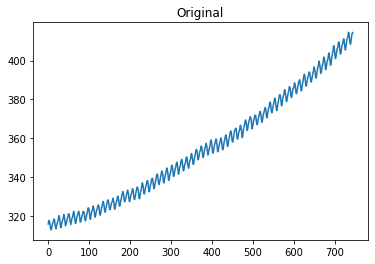

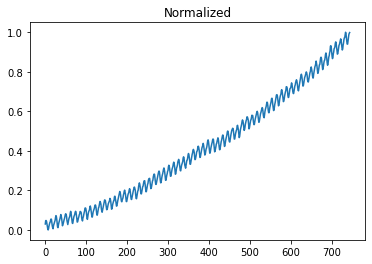

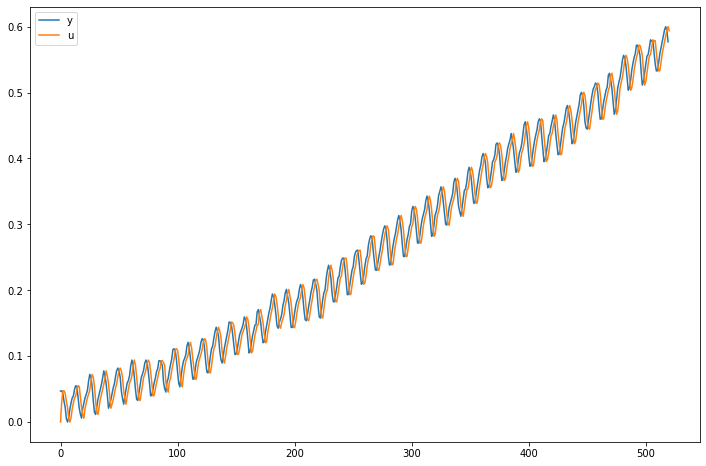

In [19]:
from google.colab import files
uploaded = files.upload()
import io
df = pd.read_csv(io.BytesIO(uploaded[fn]),usecols=[1],engine='python')
from sklearn.preprocessing import MinMaxScaler
plt.plot(df)
plt.title('Original')
print(df)

dataset= df.values
dataset = dataset.astype('float32')
num_obs =1
yd=1
ud=1

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
plt.figure()
plt.plot(dataset)
plt.title('Normalized')

# split into train and test sets
T = len(dataset)
train_size= int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
T_train = len(train)

print('T_train:',T_train, 'T_test:',len(test))

train_u = train[:-1]
train_y = train[1:]

u_ = 0*np.ones((num_obs,T_train, ud,1))
u_[0,1:T_train,0,0] = train_u[:,0]
u = np.concatenate((u_, np.ones((num_obs,T_train,1,1))), axis=2)
y = np.zeros((num_obs, T_train-1,yd,1))
y[0,:,0,0] = train_y[:,0]
y_full=y
u_full=u 

print('train_u:',train_u.shape)
print('train_y:',train_y.shape)
print('u:',u.shape)
print('y:',y.shape)

plt.figure(figsize=(12,8))
plt.plot(y[0,:,0,0], label='y')
plt.plot(u[0,:,0,0], label='u')
plt.legend()

Simulated tanh data

In [0]:
#seed = np.random.randint(low=0, high=1000000)
seed = 464238
npr.seed(seed)
num_obs = 1#3
T=4
T_train=T
yd=2
ud=yd
d=3 #This is problematic, conflicts with initialization below

x0 = npr.uniform(-.5,.5,size=(num_obs, d,1))
u = np.zeros((num_obs, T, ud+1,1))
y = np.zeros((num_obs, T-1,yd,1))
x = np.zeros((num_obs,T, d, 1))
for i in range(num_obs):
  u_ = 0*np.ones((T, ud,1))
  u[i] = np.concatenate((u_, np.ones((T,1,1))), axis=1)

# Sample the vanilla RNN
  x[i,0] = x0[i]
  u[i,1,:ud] = npr.uniform(size=u[i,1,:ud].shape)
  W_obs = npr.uniform(size=(d,d))
  B_obs = npr.uniform(size=(d,ud+1))
  C_true = npr.uniform(size=(yd,d))
  for t in range(1, T):
    x[i,t] = np.tanh(W_obs @ x[i,t-1] + B_obs @ u[i,t]) +  npr.randn(d,1)
    y[i,t-1] = C_true @ x[i,t] +npr.randn(*y[i,t-1].shape)
    if t != T-1:
      u[i,t+1,:ud] = y[i,t-1]



y_full = np.copy(y)
u_full = np.copy(u)

Sine Wave Data

T_train: 200 T_test: 200
train_u: (1, 199, 1)
train_y: (1, 199, 1)
u: (1, 200, 2, 1)
y: (1, 199, 1, 1)


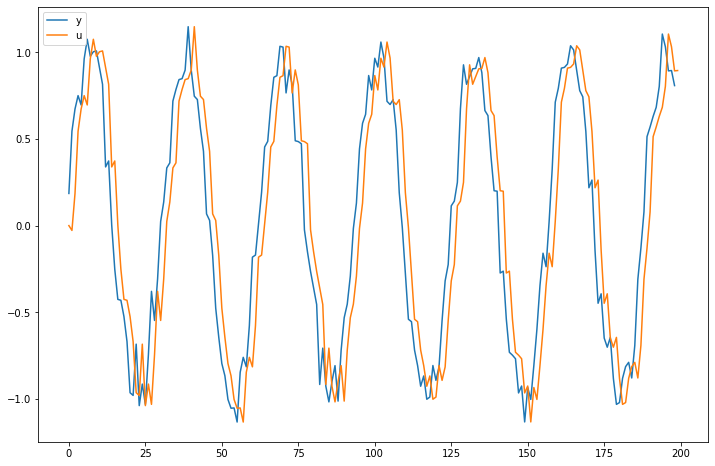

In [0]:
num_obs =1
yd=1
ud=1
T = 400
sigma_ytrue = .1*np.ones((yd,1))

# ##
# #data = np.sin(.2*(np.arange(0,T,1))).reshape(T,1,1)
# u = np.zeros((num_obs, T, ud+1,1))
# y = np.zeros((num_obs, T-1,yd,1))
# data = np.zeros((num_obs,T,1,1))
# for i in range(num_obs):
#   c = npr.uniform(0.18,0.22)
#   data[i] = np.sin(c*(np.arange(0,T,1))).reshape(T,1,1)
#   y[i] = data[i,1:]+sigma_ytrue*npr.randn(*data[i,1:].shape)
# ##

dataset = np.zeros((num_obs,T,1))
for i in range(num_obs):
  c = .2#npr.uniform(0.18,0.22)
  mu = np.sin(c*(np.arange(0,T,1))).reshape(T,1)
  dataset[i] = mu + sigma_ytrue[:,0]*npr.randn(*mu.shape)

train_size= int(len(dataset[0,:]) * 0.5)
test_size = len(dataset[0,:]) - train_size
train, test = dataset[:,0:train_size,:], dataset[:,train_size:len(dataset[0,:]),:]
T_train = len(train[0,:])

print('T_train:',T_train, 'T_test:',len(test[0,:]))

train_u = train[:,:-1]
train_y = train[:,1:]

u_ = 0*np.ones((num_obs,T_train, ud,1))
y = np.zeros((num_obs, T_train-1,yd,1))
for i in range(num_obs):
  u_[i,1:T_train,0,0] = train_u[i,:,0]
  y[i,:,0,0] = train_y[i,:,0]

u = np.concatenate((u_, np.ones((num_obs,T_train,1,1))), axis=2)

y_full=y
u_full=u 

print('train_u:',train_u.shape)
print('train_y:',train_y.shape)
print('u:',u.shape)
print('y:',y.shape)


for i in range(num_obs):
  plt.figure(figsize=(12,8))
  plt.plot(y[i,:,0,0], label='y')
  plt.plot(u[i,:,0,0], label='u')
  plt.legend()

Initialize Models

mean: 9.999999999999992e-05
var: -1.1111111111111094e-08
std: nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


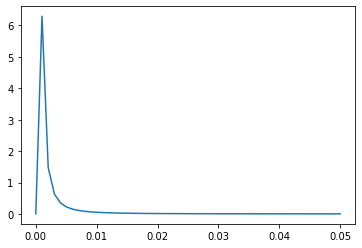

In [0]:
alpha=1.1
beta=.00001
x = np.linspace(0,.05)
plt.plot(x,invgamma.pdf(x,alpha, scale=beta))
mean = beta/(alpha-1)
var = (beta**2)/((alpha-1)**2*(alpha-2))
print('mean:',mean)
print('var:',var)
print('std:',np.sqrt(var))

In [20]:
#seed = np.random.randint(low=0, high=1000000)
seed=641386
print('seed={}'.format(seed))
npr.seed(seed)

model_type = 'GRU'
train_type= 'gibbs'
print(model_type)
print(train_type)



if model_type =='vanRNN':  
  if train_type == 'EM':
    prior =  False #include prior weight parameters, either for map or gibbs
    mb_size=1
    Estep_burn_iters=3
    Estep_sample_iters=2
    mstep_iters=300
    num_post_samples=300
    post_burn_iters = 200
    rhoexp = .6 #0.5< rhoexp <=1 #smaller, leads to larger updates, 
              #so forget old suff stats more quickly, 
              #which leads to quicker updates but more instability
    #warmup_iters = 0 #250
  elif train_type== 'gibbs':
    prior=True
    burn_iters = 100#3000
    num_post_samples=100
    rhoexp = 0

  d=10
  tanh_window=4 
  tanh_numparts=4
  tanh_temp= .1

  mu_init = np.zeros((num_obs, d,1))
  sigma_init = 0.01*np.ones((d,1))#npr.uniform(size=(d,1))
  
  alpha = 2.1*np.ones((d,1))#3#npr.uniform(low=3.8, high=4,size=(d,1))
  beta = 1e-8*np.ones((d,1))#.0002 #npr.uniform(low=1, high=1.2,size=(d,1))
  sigma = np.sqrt(invgamma.rvs(alpha, scale=beta,size=(d,1)))
  #sigma = 0.5*np.ones((d,1))     #npr.uniform(low=10, high=11,size=(d,1))
  print('sigma',sigma)

  alphay = 2.1*np.ones((yd,1))#3#npr.uniform(low=3.8, high=4,size=(yd,1))
  betay = 1e-8*np.ones((yd,1))#.0002 #npr.uniform(low=1, high=1.2,size=(yd,1))
  sigma_y = np.sqrt(invgamma.rvs(alphay, scale=betay, size=(yd,1)))
  #sigma_y = 0.5*np.ones((yd,1)) #npr.uniform(size=(yd,1))
  print('sigmay', sigma_y)

  Wbar_prior = 0*np.ones((d,d+ud+1))
  Wbar_sigma = .1*np.ones(Wbar_prior.shape)
  Wbar = npr.normal(Wbar_prior, Wbar_sigma)
  W = Wbar[:,:d]
  B = Wbar[:,d:]


  Wbary_prior = 0*np.ones((yd,d+1))
  Wbary_sigma = .1*np.ones(Wbary_prior.shape)
  Wbary = npr.normal(Wbary_prior, Wbary_sigma)
  C = Wbary[:,:d]
  by = Wbary[:,d:]


  #Sample model to initialize x and z
  model_args = (W,B,mu_init,sigma_init,sigma, C,by,sigma_y)
  model_kwargs = {'tanh_num_parts':tanh_numparts, 'tanh_window':tanh_window,
                  'tanh_temp':tanh_temp,'Wbar_prior':Wbar_prior,'Wbar_sigma':Wbar_sigma,'alpha':alpha, 'beta':beta,
                  'Wbary_prior':Wbary_prior,'Wbary_sigma':Wbary_sigma, 'alphay':alphay, 'betay':betay}
  samplemodel = StochPiecewiseLinearVanillaRNN(*model_args, **model_kwargs)
  x = np.zeros((num_obs,T_train, d, 1))
  z_init = np.zeros(x[:,1:T_train].shape, dtype=np.int16)
  for i in range(num_obs):
    x[i,0] = mu_init[i]+sigma_init*npr.randn(d,1)
    for t in range(1, T_train):
      x[i,t], _, z_init[i,t-1] =samplemodel.f(x[i,t-1], u[i,t], Wbar, Wbary, return_z=True) 

  print('x:',x.shape)
  x_full=np.copy(x)


if model_type =='GRU':  
  if train_type == 'EM':
    prior= False
    mb_size=1
    Estep_burn_iters=3
    Estep_sample_iters=2
    mstep_iters=100#100
    num_post_samples=200
    post_burn_iters = 100
    rhoexp = .6 #0.5< rhoexp <=1 #smaller, leads to larger updates, 
              #so forget old suff stats more quickly, 
              #which leads to quicker updates but more instability
    #warmup_iters = 0 #250
  elif train_type== 'gibbs':
    prior=True
    burn_iters = 1000
    num_post_samples=200
    rhoexp = 0

  d=10
  tanh_window=4 
  tanh_numparts=16
  tanh_temp= .1
  i_window=4 
  i_numparts=16
  i_temp= .1
  r_window=4 
  r_numparts=16
  r_temp= .1

  mu_init = np.zeros((num_obs, d,1))
  sigma_init = 0.01*np.ones((d,1))#npr.uniform(size=(d,1))

  calpha = 1.1
  cbeta = 1e-5


  # calpha = 1.1
  # cbeta = .0000025

  calphax = 1.1
  cbetax = 1e-5
  calphay = 1.1
  cbetay = 1e-5



  alpha = calphax*np.ones((d,1))
  beta = cbetax*np.ones((d,1))
  sigma = np.sqrt(invgamma.rvs(alpha, scale=beta, size=(d,1)))
  #sigma = .01*np.ones((d,1))     #npr.uniform(low=10, high=11,size=(d,1))
  print(sigma)
  
  alphay = calphay*np.ones((yd,1))
  betay = cbetay*np.ones((yd,1))
  sigma_y = np.sqrt(invgamma.rvs(alphay, scale=betay,size=(yd,1)))
  #sigma_y = 0.01*np.ones((yd,1)) #npr.uniform(size=(yd,1))
  print(sigma_y)

  alphai = calpha*np.ones((d,1))
  betai = cbeta*np.ones((d,1))
  sigma_i = np.sqrt(invgamma.rvs(alphai, scale=betai, size=(d,1)))
  #sigma_i = 0.01*np.ones((d,1))#npr.uniform(.01,.3,size=(d,1))
  
  alphar = calpha*np.ones((d,1))
  betar = cbeta*np.ones((d,1))
  sigma_r = np.sqrt(invgamma.rvs(alphar, scale=betar, size=(d,1)))
  #sigma_r = 0.01*np.ones((d,1))#npr.uniform(.01,.3,size=(d,1))

  Wbari_prior = 0*np.ones((d,d+ud+1))
  Wbari_sigma = .1*np.ones(Wbari_prior.shape)
  Wbari = npr.normal(Wbari_prior, Wbari_sigma)
  Wi = Wbari[:,:d]
  Bi = Wbari[:,d:]

  Wbarr_prior = 0*np.ones((d,d+ud+1))
  Wbarr_sigma = .1*np.ones(Wbarr_prior.shape)
  Wbarr = npr.normal(Wbarr_prior, Wbarr_sigma)
  Wr = Wbarr[:,:d]
  Br = Wbarr[:,d:]

  Wbarp_prior = 0*np.ones((d,d+ud+1))
  Wbarp_sigma = .1*np.ones(Wbarp_prior.shape)
  Wbarp = npr.normal(Wbarp_prior, Wbarp_sigma)
  Wp = Wbarp[:,:d]
  Bp = Wbarp[:,d:]

  Wbary_prior = 0*np.ones((yd,d+1))
  Wbary_sigma = .1*np.ones(Wbary_prior.shape)
  Wbary = npr.normal(Wbary_prior, Wbary_sigma)
  C = Wbary[:,:d]
  by = Wbary[:,d:]

  # #Sample the vanilla RNN to initialize x
  # x = np.zeros((num_obs,T_train, d, 1))
  # for i in range(num_obs):
  #   x[i,0] = mu_init[i]+sigma_init*npr.randn(d,1)
  #   for t in range(1, T_train):
  #     x[i,t] = np.tanh(Wi @ x[i,t-1] + Bi @ u[i,t]) + sigma * npr.randn(d,1)
  # print('x:',x.shape)
  # x_full=np.copy(x)


  #Sample model to initialize x and z
  model_args = (Wi,Bi,Wr,Br,Wp,Bp,mu_init,sigma_init,sigma, 
                            C,by,sigma_y,sigma_i, sigma_r)
  model_kwargs = {'tanh_numparts':tanh_numparts,
                'tanh_window':tanh_window, 'tanh_temp':tanh_temp,'sigmoid_i_numparts':i_numparts,
                'sigmoid_i_window':i_window, 'sigmoid_i_temp':i_temp,'sigmoid_r_numparts':r_numparts,
                'sigmoid_r_window':r_window, 'sigmoid_r_temp':r_temp,
                'Wbar_i_prior':Wbari_prior,'Wbar_i_sigma':Wbari_sigma,
                'alphai':alphai, 'betai':betai,
                'Wbar_r_prior':Wbarr_prior,'Wbar_r_sigma':Wbarr_sigma,
                'alphar':alphar, 'betar':betar,
                'Wbar_p_prior':Wbarp_prior,'Wbar_p_sigma':Wbarp_sigma,
                'alpha':alpha, 'beta':beta,
                'Wbar_y_prior':Wbary_prior,'Wbar_y_sigma':Wbary_sigma,
                'alphay':alphay, 'betay':betay}
  samplemodel = StochPiecewiseLinearGRU(*model_args, **model_kwargs)
  x = np.zeros((num_obs,T_train, d, 1))
  zi_init = np.zeros(x[:,1:T_train].shape, dtype=np.int16)
  zr_init = np.zeros(x[:,1:T_train].shape, dtype=np.int16)
  zp_init = np.zeros(x[:,1:T_train].shape, dtype=np.int16)
  i_init =  np.zeros(x[:,1:T_train].shape)
  r_init =  np.zeros(x[:,1:T_train].shape)
  for i in range(num_obs):
    x[i,0] = mu_init[i]+sigma_init*npr.randn(d,1)
    for t in range(1, T_train):
      x[i,t], _, zi_init[i,t-1],i_init[i,t-1],zr_init[i,t-1],r_init[i,t-1],zp_init[i,t-1] =samplemodel.f(x[i,t-1], u[i,t], Wbari,Wbarr,Wbarp,Wbary, return_z=True) 

  print('x:',x.shape)
  x_full=np.copy(x)



  # zi_init = npr.randint(low=0, high=i_numparts,size=x[:,1:T_train].shape)
  # i_init = npr.uniform(size = zi_init.shape)+sigma_i*npr.randn(*zi_init.shape)
  # zr_init = npr.randint(low=0, high=r_numparts,size=x[:,1:T_train].shape)
  # r_init = npr.uniform(size = zr_init.shape)+sigma_r*npr.randn(*zr_init.shape)
  # zp_init = npr.randint(low=0, high=tanh_numparts,size=x[:,1:T_train].shape)

seed=641386
GRU
gibbs
[[0.00271792]
 [0.00186034]
 [0.00760808]
 [0.00458794]
 [0.00212875]
 [0.00235062]
 [0.00444251]
 [0.00135933]
 [0.00127494]
 [0.00534749]]
[[0.00702141]]
temp
0.1
numparts
16
Window
4
Wbar_prior: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Wbar_sigmasq: [[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.0

In [0]:
# alpha = npr.uniform(low=3.8, high=4,size=(d,1))#3*np.ones((d,1)
# beta = npr.uniform(low=1, high=1.2,size=(d,1))#.3*np.ones((d,1))

# alpha = 40*np.ones((d,1))
# beta = .0039*np.ones((d,1)) 

# M=10000
# sigma = 0
# for m in range(M):
#   sigma += np.sqrt(invgamma.rvs(alpha, scale=beta, size=(d,1)))
# sigma  = sigma/M
# print(sigma)

In [0]:
# burn_iters=1000

temp
0.1
numparts
16
Window
4
Wbar_prior: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Wbar_sigmasq: [[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in log


0
55582.86991537418


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in log


1
55897.16570818085
2
55856.30268864721
3
55972.170087997736
4
55987.67645290748
5
55972.363515014076
6
55993.45274206798
7
55930.643933008716
8
56250.58259380241
9
56193.008515472815
10
55856.66523260109
11
55961.580113094125
12
55812.99496266769
13
56075.94253097482
14
55865.6812468923
15
55793.370073481696
16
56018.0291212385
17
55959.087152219094
18
55837.215243065526
19
56057.22865635897
20
55853.46901599466
21
55731.48505808794
22
55624.622988520445
23
55554.988874423325
24
55317.85623740013
25
55160.22315933722
26
55250.827850796886
27
55051.626355931825
28
55034.47522806179
29
55012.52770608453
30
55292.64092677206
31
55259.56781486419
32
55480.071930545615
33
55542.53392079362
34
55664.408899615
35
55755.017670215966
36
55652.33865735588
37
55611.12130179844
38
55461.39066448153
39
55316.15758741123
40
55456.758867694654
41
55508.55819069489
42
55513.929170993666
43
55290.26522026258
44
55282.06522019724
45
55091.40563632779
46
54933.404748606685
47
54901.971678035785
48
54905

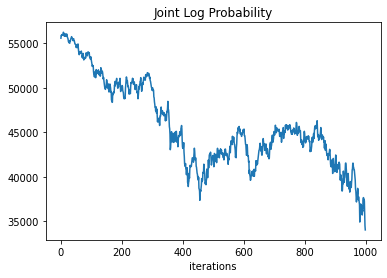

In [23]:
if model_type == 'vanRNN':
  if prior==True:
    model_args = (W,B,mu_init,sigma_init,sigma, C,by,sigma_y)
    model_kwargs = {'tanh_num_parts':tanh_numparts, 'tanh_window':tanh_window,
                    'tanh_temp':tanh_temp,'Wbar_prior':Wbar_prior,'Wbar_sigma':Wbar_sigma,'alpha':alpha, 'beta':beta,
                    'Wbary_prior':Wbary_prior,'Wbary_sigma':Wbary_sigma, 'alphay':alphay, 'betay':betay}
  else:
    model_args = (W,B,mu_init,sigma_init,sigma, C,by,sigma_y)
    model_kwargs = {'tanh_num_parts': tanh_numparts, 'tanh_window':tanh_window,  'tanh_temp':tanh_temp}

  batch_ops_args = (y_full, x_full, u_full, z_init, rhoexp)

elif model_type == 'GRU':
  if prior==True:
    model_args = (Wi,Bi,Wr,Br,Wp,Bp,mu_init,sigma_init,sigma, 
                              C,by,sigma_y,sigma_i, sigma_r)
    model_kwargs = {'tanh_numparts':tanh_numparts,
                 'tanh_window':tanh_window, 'tanh_temp':tanh_temp,'sigmoid_i_numparts':i_numparts,
                 'sigmoid_i_window':i_window, 'sigmoid_i_temp':i_temp,'sigmoid_r_numparts':r_numparts,
                 'sigmoid_r_window':r_window, 'sigmoid_r_temp':r_temp,
                 'Wbar_i_prior':Wbari_prior,'Wbar_i_sigma':Wbari_sigma,
                 'alphai':alphai, 'betai':betai,
                 'Wbar_r_prior':Wbarr_prior,'Wbar_r_sigma':Wbarr_sigma,
                 'alphar':alphar, 'betar':betar,
                 'Wbar_p_prior':Wbarp_prior,'Wbar_p_sigma':Wbarp_sigma,
                 'alpha':alpha, 'beta':beta,
                 'Wbar_y_prior':Wbary_prior,'Wbar_y_sigma':Wbary_sigma,
                 'alphay':alphay, 'betay':betay}
  else:
    model_args = (Wi,Bi,Wr,Br,Wp,Bp,mu_init,sigma_init,sigma, 
                              C,by,sigma_y,sigma_i, sigma_r)
    model_kwargs = {'tanh_numparts':tanh_numparts,
                 'tanh_window':tanh_window, 'tanh_temp':tanh_temp,'sigmoid_i_numparts':i_numparts,
                 'sigmoid_i_window':i_window, 'sigmoid_i_temp':i_temp,'sigmoid_r_numparts':r_numparts,
                 'sigmoid_r_window':r_window, 'sigmoid_r_temp':r_temp}

  batch_ops_args = (y_full, x_full, u_full, zi_init,i_init,zr_init,r_init,zp_init,rhoexp)


#Define Model
model, batch_ops = define_model(model_type, model_args, model_kwargs, batch_ops_args)

#Fit and Inference
if train_type == 'EM':
  # model,batch_ops, x_samples,Wbars = stoch_EM_gibbsEstep(model, batch_ops,model_type,num_obs, 
  #             mb_size, mstep_iters,Estep_burn_iters,post_burn_iters,num_post_samples,T_train, d)
  
  model,batch_ops, Wbars = stoch_EM_gibbsEstep_fit(model, batch_ops,model_type,num_obs, 
              mb_size, mstep_iters,Estep_burn_iters,Estep_sample_iters)
  
  x_samples, z_samples = stoch_EM_gibbsEstep_sample(model, batch_ops, model_type, num_obs, 
             mb_size, post_burn_iters,num_post_samples,T_train, d)

  sigmasqs=[]

elif train_type == 'gibbs':
   model,batch_ops, x_samples,Wbars,zs, sigmasqs = gibbs_sample(model, batch_ops,model_type,  
              burn_iters,num_post_samples,T_train, d)
#Predict
xpreds_mean, xpreds_std, xpostpreds_mean, xpostpreds_std, ypreds_mean, ypreds_std, ypreds2_mean, ypreds2_std, ypreds_test_mean, ypreds_test_std, ypreds_test  = predict(train_type, 
                                                                                                                                                          model_type, model, Wbars,u, y, x_samples, T, yd, mu_init, sigma_init,sigmasqs )

ypreds2_mean = ypreds2_mean[0,:,0]
ypreds2_std  = ypreds2_std[0,:,0]

ypreds_test_mean = ypreds_test_mean[0,:,0] 
ypreds_test_std = ypreds_test_std[0,:,0] 

In [0]:
# print(z_samples.shape)
# for i in range(0,200,20): 
#   plt.plot(z_samples[i,0,:,0])

In [0]:
burn_iters = 300

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in log


0
35086.26974958496
1
34269.948439083964
2
34730.11849805887
3
34768.26687228172
4
35448.32498571897
5
35447.395909312574
6
35296.06620526109
7
34902.7772231606
8
33997.711441573396
9
33258.02197125328
10
33976.657247066956
11
33789.639658240005
12
33349.21306647131
13
33325.76279953235
14
34539.74968504027
15
36398.7146740319
16
36791.286099762554
17
37452.981211760794
18
36945.22001253319
19
36887.74407430974
20
37225.752680055
21
37353.73401340689
22
37024.60582181773
23
36622.85662247509
24
37567.44391684903
25
37746.356294916804
26
38061.617946695114
27
37801.65738197555
28
37176.203469501634
29
37555.414909876425
30
37408.079058704636
31
38278.932622069726
32
38552.31027268952
33
37083.078368525705
34
36820.87868129721
35
37531.048094931524
36
36812.106978096774
37
36787.83115707616
38
37433.810545506276
39
36380.93489863722
40
35505.95854364738
41
36646.376496579025
42
37250.920029552966
43
36894.30971079505
44
37328.28470864385
45
36855.35453084676
46
37738.64718799417
47
37203

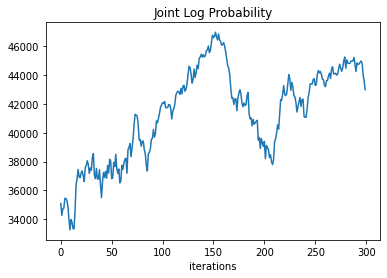

In [0]:
#Fit and Inference
# Estep_burn_iters=2
# Estep_sample_iters=3
# mstep_iters=10#1000

if train_type == 'EM':  
  model,batch_ops, Wbars = stoch_EM_gibbsEstep_fit(model, batch_ops,model_type,num_obs, 
              mb_size, mstep_iters,Estep_burn_iters,Estep_sample_iters)
  
  x_samples,z_samples = stoch_EM_gibbsEstep_sample(model, batch_ops, model_type, num_obs, 
             mb_size, post_burn_iters,num_post_samples,T_train, d)

  sigmasqs=[]

elif train_type == 'gibbs':
   model,batch_ops, x_samples,Wbars,zs, sigmasqs = gibbs_sample(model, batch_ops,model_type,  
              burn_iters,num_post_samples,T_train, d)
#Predict
xpreds_mean, xpreds_std, xpostpreds_mean, xpostpreds_std, ypreds_mean, ypreds_std, ypreds2_mean, ypreds2_std, ypreds_test_mean, ypreds_test_std, ypreds_test  = predict(train_type, 
                                                                                                                                                          model_type, model, Wbars,u, y, x_samples, T, yd, mu_init, sigma_init,sigmasqs )

ypreds2_mean = ypreds2_mean[0,:,0]
ypreds2_std  = ypreds2_std[0,:,0]

ypreds_test_mean = ypreds_test_mean[0,:,0] 
ypreds_test_std = ypreds_test_std[0,:,0] 

In [0]:
# #Just Inference
# num_post_samples=1000

# if train_type == 'EM':    
#   x_samples = stoch_EM_gibbsEstep_sample(model, batch_ops, model_type, num_obs, 
#              mb_size, post_burn_iters,num_post_samples,T_train, d)


# elif train_type == 'gibbs':
#    model,batch_ops, x_samples,Wbars,zs, sigmasqs = gibbs_sample(model, batch_ops,model_type,  
#               burn_iters,num_post_samples,T_train, d)
# #Predict
# xpreds_mean, xpreds_std, xpostpreds_mean, xpostpreds_std, ypreds_mean, ypreds_std, ypreds2_mean, ypreds2_std, ypreds_test_mean, ypreds_test_std, ypreds_test  = predict(train_type, 
#                                                                                                                                                           model_type, model, Wbars,u, y, x_samples, T, yd, mu_init, sigma_init,sigmasqs )

# ypreds2_mean = ypreds2_mean[0,:,0]
# ypreds2_std  = ypreds2_std[0,:,0]

# ypreds_test_mean = ypreds_test_mean[0,:,0] 
# ypreds_test_std = ypreds_test_std[0,:,0] 

In [0]:
# print(np.sqrt(model.sigmasq))
# print(' ')
# print(np.sqrt(model.obs.sigmasq))
# print(' ')
# # print(np.sqrt(model.sigmoid_i.sigmasq_out))
# # print(' ')
# # print(np.sqrt(model.sigmoid_r.sigmasq_out))

In [0]:
print(np.sqrt(model.sigmasq))
print(' ')
print(np.sqrt(model.obs.sigmasq))
print(' ')
print(np.sqrt(model.sigmoid_i.sigmasq_out))
print(' ')
print(np.sqrt(model.sigmoid_r.sigmasq_out))
print(' ')

[[0.00250406]
 [0.00179544]
 [0.00313828]
 [0.00364045]
 [0.00177108]
 [0.00332538]
 [0.00350387]
 [0.00432626]
 [0.00580563]
 [0.10330867]
 [0.00749627]
 [0.00480304]
 [0.00587325]
 [0.00190893]
 [0.00229014]
 [0.00210826]
 [0.01097343]
 [0.00264782]
 [0.00239733]
 [0.00223528]]
 
[[0.00135217]]
 
[[0.0043692 ]
 [0.06618305]
 [0.00198648]
 [0.00461372]
 [0.00272804]
 [0.01122278]
 [0.02258036]
 [0.00331632]
 [0.00450124]
 [0.00184028]
 [0.00335253]
 [0.00238065]
 [0.00193941]
 [0.00183975]
 [0.00168275]
 [0.00632249]
 [0.00422505]
 [0.00220044]
 [0.04740218]
 [0.00402819]]
 
[[0.00253012]
 [0.00461729]
 [0.00318061]
 [0.00551281]
 [0.00678619]
 [0.00481971]
 [0.00657996]
 [0.00226242]
 [0.00323268]
 [0.0026379 ]
 [0.00274111]
 [0.01057813]
 [0.00488331]
 [0.00384951]
 [0.00298046]
 [0.00360441]
 [0.01854119]
 [0.00335578]
 [0.00412081]
 [0.00179908]]
 


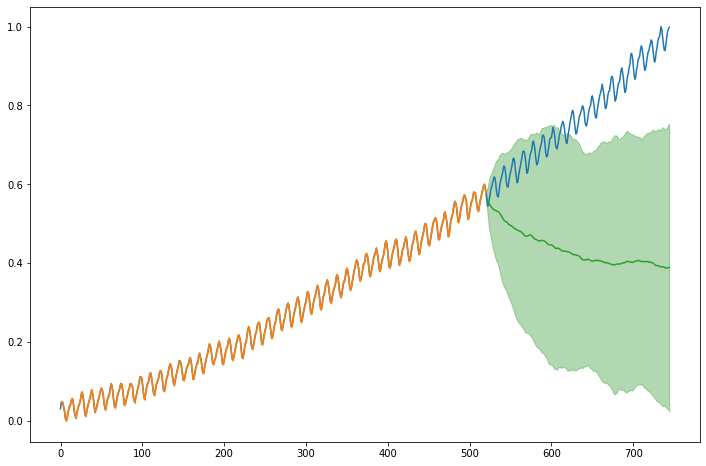

In [24]:
# ypreds2_mean = ypreds2_mean[0,:,0]
# ypreds2_std  = ypreds2_std[0,:,0]

# ypreds_test_mean = ypreds_test_mean[0,:,0] 
# ypreds_test_std = ypreds_test_std[0,:,0] 

plt.figure(figsize=(12,8))
#plt.plot(np.arange(1,T_train),y[0,:,0,0])
plt.plot(dataset)
plt.plot(np.arange(1,T_train),ypreds2_mean)
plt.fill_between(np.arange(1,T_train), 
                  ypreds2_mean- 2 * ypreds2_std, 
                  ypreds2_mean + 2 * ypreds2_std,color='orange',
                  alpha=0.3)
plt.plot(np.arange(T_train, T),ypreds_test_mean )
plt.fill_between(np.arange(T_train,T), 
                  ypreds_test_mean- 2 * ypreds_test_std, 
                  ypreds_test_mean + 2 * ypreds_test_std,color='green',
                  alpha=0.3)

# end=100
# plt.plot(np.arange(T_train, T-end),ypreds_test_mean[:-end] )
# plt.fill_between(np.arange(T_train,T-end), 
#                   ypreds_test_mean[:-end]- 2 * ypreds_test_std[:-end], 
#                   ypreds_test_mean[:-end] + 2 * ypreds_test_std[:-end],color='green',
#                   alpha=0.3)

# for i in range(-1,-10,-1):
#   plt.plot(np.arange(T_train, T),ypreds_test[i,0,:,0,0])

# print('d=',d)
# print('temp=',tanh_temp)
# print('num_parts=',tanh_numparts)
# print('alpha=',1.1)
# print('beta=',.00001)
# print('Wbar_sigma=',.1)

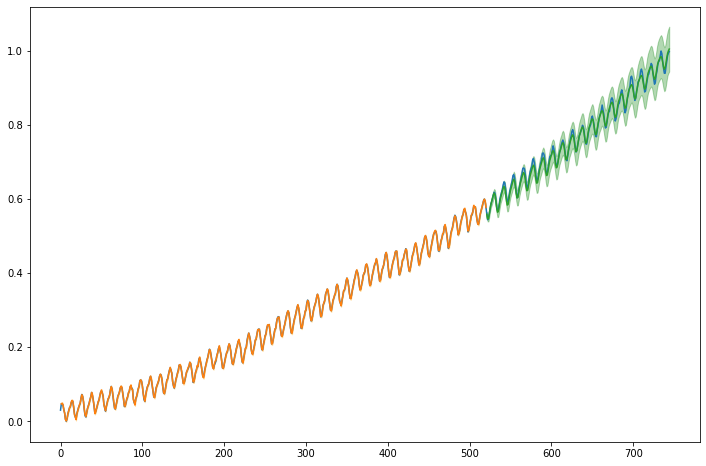

In [0]:
# ypreds2_mean = ypreds2_mean[0,:,0]
# ypreds2_std  = ypreds2_std[0,:,0]

# ypreds_test_mean = ypreds_test_mean[0,:,0] 
# ypreds_test_std = ypreds_test_std[0,:,0] 

plt.figure(figsize=(12,8))
#plt.plot(np.arange(1,T_train),y[0,:,0,0])
plt.plot(dataset)
plt.plot(np.arange(1,T_train),ypreds2_mean)
plt.fill_between(np.arange(1,T_train), 
                  ypreds2_mean- 2 * ypreds2_std, 
                  ypreds2_mean + 2 * ypreds2_std,color='orange',
                  alpha=0.3)
plt.plot(np.arange(T_train, T),ypreds_test_mean )
plt.fill_between(np.arange(T_train,T), 
                  ypreds_test_mean- 2 * ypreds_test_std, 
                  ypreds_test_mean + 2 * ypreds_test_std,color='green',
                  alpha=0.3)

# end=50
# plt.plot(np.arange(T_train, T-end),ypreds_test_mean[:-end] )
# plt.fill_between(np.arange(T_train,T-end), 
#                   ypreds_test_mean[:-end]- 2 * ypreds_test_std[:-end], 
#                   ypreds_test_mean[:-end] + 2 * ypreds_test_std[:-end],color='green',
#                   alpha=0.3)

# for i in range(-1,-10,-1):
#   plt.plot(np.arange(T_train, T),ypreds_test[i,0,:,0,0])

# print('d=',d)
# print('temp=',tanh_temp)
# print('num_parts=',tanh_numparts)
# print('alpha=',1.1)
# print('beta=',.00001)
# print('Wbar_sigma=',.1)

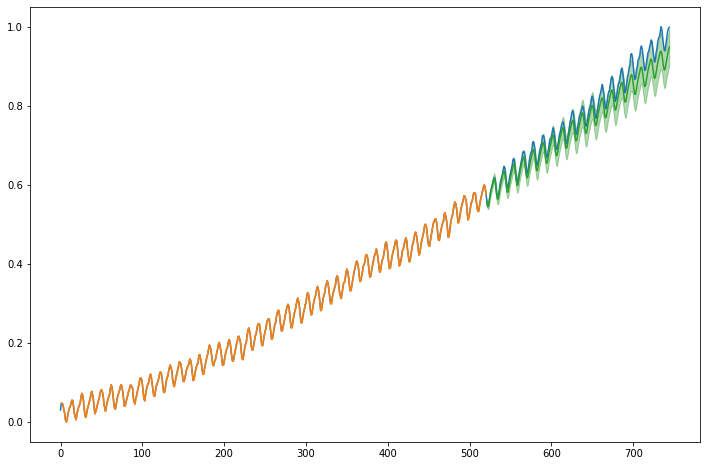

In [0]:
# ypreds2_mean = ypreds2_mean[0,:,0]
# ypreds2_std  = ypreds2_std[0,:,0]

# ypreds_test_mean = ypreds_test_mean[0,:,0] 
# ypreds_test_std = ypreds_test_std[0,:,0] 

plt.figure(figsize=(12,8))
#plt.plot(np.arange(1,T_train),y[0,:,0,0])
plt.plot(dataset)
plt.plot(np.arange(1,T_train),ypreds2_mean)
plt.fill_between(np.arange(1,T_train), 
                  ypreds2_mean- 2 * ypreds2_std, 
                  ypreds2_mean + 2 * ypreds2_std,color='orange',
                  alpha=0.3)
plt.plot(np.arange(T_train, T),ypreds_test_mean )
plt.fill_between(np.arange(T_train,T), 
                  ypreds_test_mean- 2 * ypreds_test_std, 
                  ypreds_test_mean + 2 * ypreds_test_std,color='green',
                  alpha=0.3)

# end=100
# plt.plot(np.arange(T_train, T-end),ypreds_test_mean[:-end] )
# plt.fill_between(np.arange(T_train,T-end), 
#                   ypreds_test_mean[:-end]- 2 * ypreds_test_std[:-end], 
#                   ypreds_test_mean[:-end] + 2 * ypreds_test_std[:-end],color='green',
#                   alpha=0.3)

# for i in range(-1,-10,-1):
#   plt.plot(np.arange(T_train, T),ypreds_test[i,0,:,0,0])

# print('d=',d)
# print('temp=',tanh_temp)
# print('num_parts=',tanh_numparts)
# print('alpha=',1.1)
# print('beta=',.00001)
# print('Wbar_sigma=',.1)

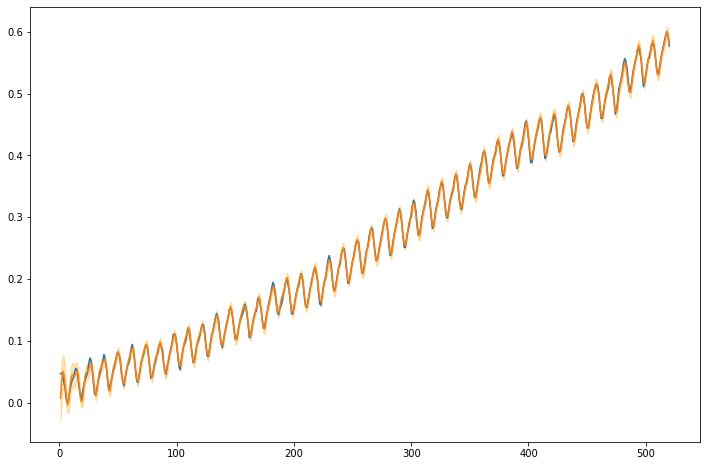

In [0]:
ypreds_mean = ypreds_mean[0,:,0]
ypreds_std  = ypreds_std[0,:,0]

plt.figure(figsize=(12,8))
plt.plot(np.arange(1,T_train),y[0,:,0,0])
plt.plot(np.arange(1,T_train),ypreds_mean)
plt.fill_between(np.arange(1,T_train), 
                  ypreds_mean- 2 * ypreds_std, 
                  ypreds_mean + 2 * ypreds_std,color='orange',
                  alpha=0.3)

obs=0


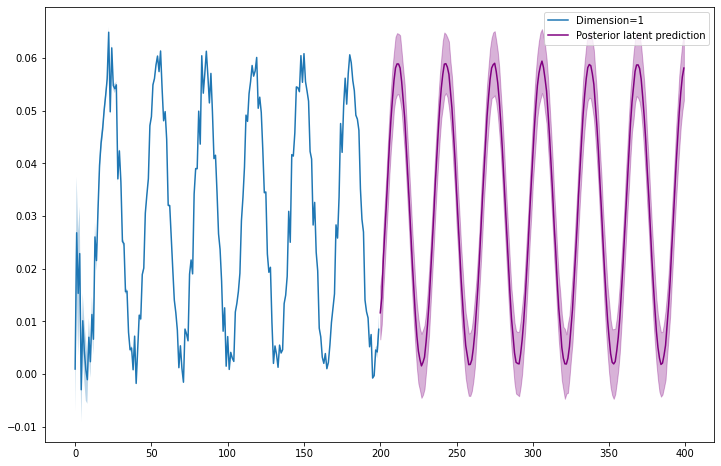

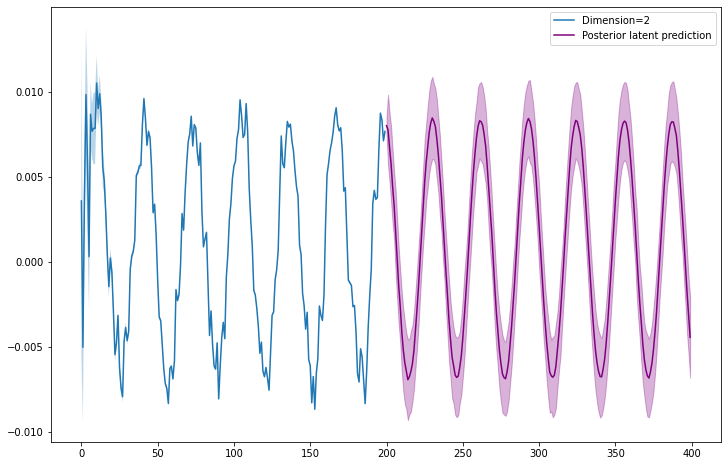

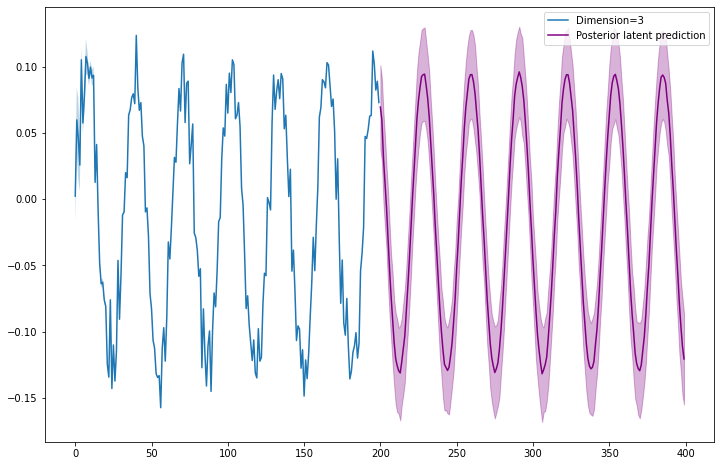

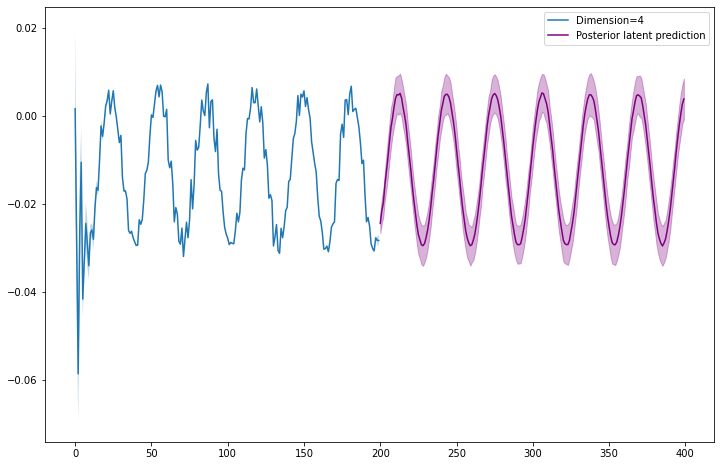

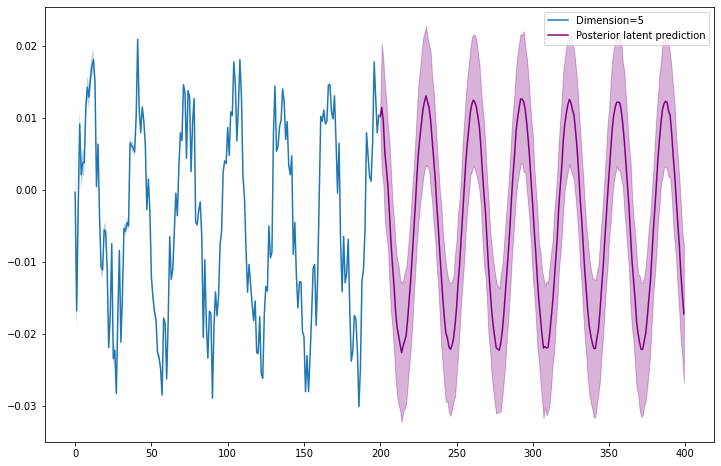

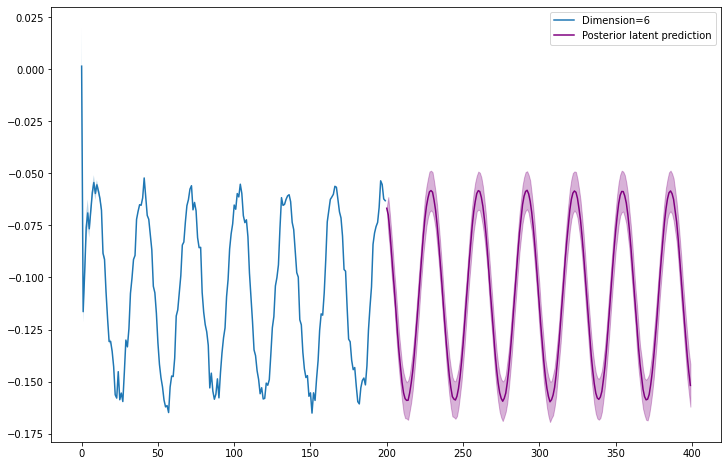

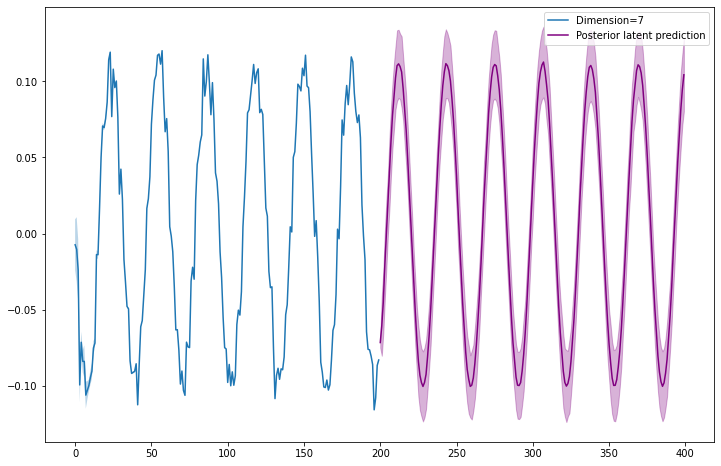

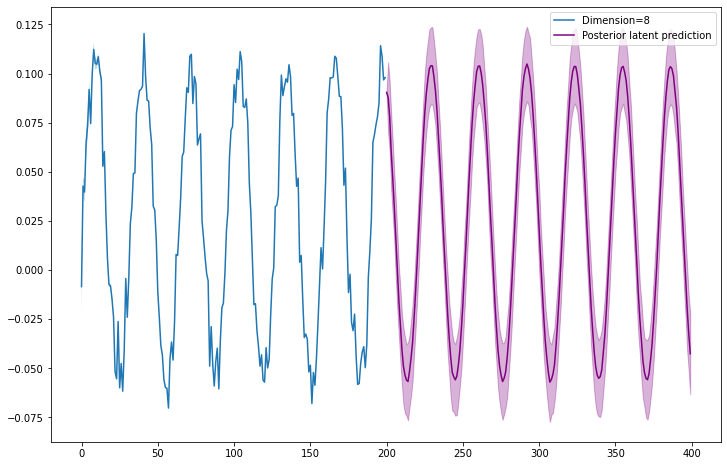

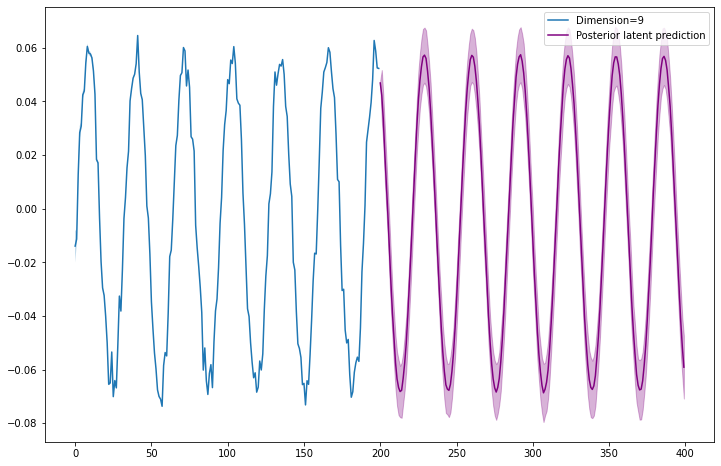

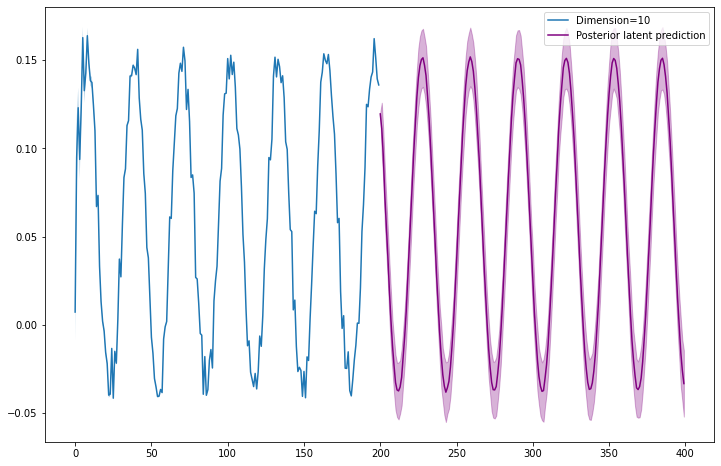

In [0]:
#Inference results
for m in range(0,num_obs):
  print('obs={}'.format(m))
  for i in range(0,d):
    plt.figure(figsize=(12, 8))
    xsample_mean = np.mean(x_samples, axis=0)[m,:,i,0]
    xsample_std = np.std(x_samples,axis=0)[m,:,i,0]

    plt.plot(np.arange(0,T_train), xsample_mean[0:T_train], label='Dimension={}'.format(i+1))

    plt.fill_between(np.arange(0,T_train), 
                  xsample_mean[0:T_train] - 2 * xsample_std[0:T_train], 
                  xsample_mean[0:T_train] + 2 * xsample_std[0:T_train],
                  alpha=0.3)

    #plt.plot(xsample_mean)
    #plot_inf(x_obs[m,:,i,0], T,T_train,  xsample_mean, xsample_std, sigma, d, tanh_numparts, tanh_temp)
    plotx_pred(T,T_train,xpreds_mean[m,:,i], xpreds_std[m,:,i], xpostpreds_mean[m,:,i], xpostpreds_std[m,:,i], sigma, d, tanh_numparts, tanh_temp)

# Testing

# Mauna Loa

VanRNN EM, num_parts=4,d=10 

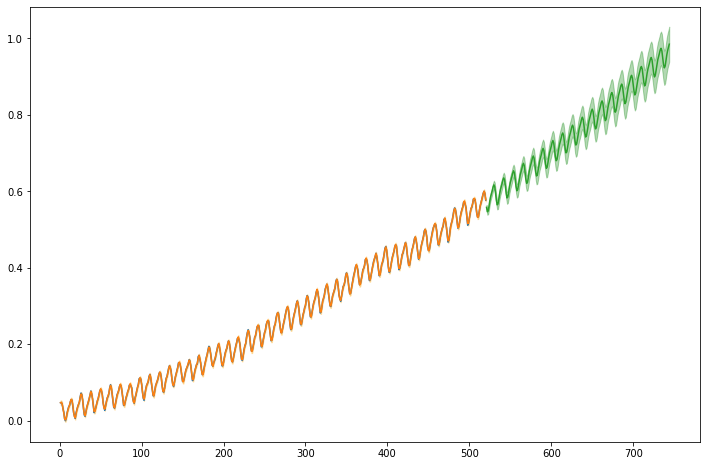

In [0]:
# ypreds2_mean = ypreds2_mean[0,:,0]
# ypreds2_std  = ypreds2_std[0,:,0]

# ypreds_test_mean = ypreds_test_mean[0,:,0] 
# ypreds_test_std = ypreds_test_std[0,:,0] 

plt.figure(figsize=(12,8))
plt.plot(np.arange(1,T_train),y[0,:,0,0])
plt.plot(np.arange(1,T_train),ypreds2_mean)
plt.fill_between(np.arange(1,T_train), 
                  ypreds2_mean- 2 * ypreds2_std, 
                  ypreds2_mean + 2 * ypreds2_std,color='orange',
                  alpha=0.3)
plt.plot(np.arange(T_train, T),ypreds_test_mean )
plt.fill_between(np.arange(T_train,T), 
                  ypreds_test_mean- 2 * ypreds_test_std, 
                  ypreds_test_mean + 2 * ypreds_test_std,color='green',
                  alpha=0.3)

# for i in range(-1,-10,-1):
#   plt.plot(np.arange(T_train, T),ypreds_test[i,0,:,0,0])

# print('d=',d)
# print('temp=',tanh_temp)
# print('num_parts=',tanh_numparts)
# print('alpha=',1.1)
# print('beta=',.00001)
# print('Wbar_sigma=',.1)

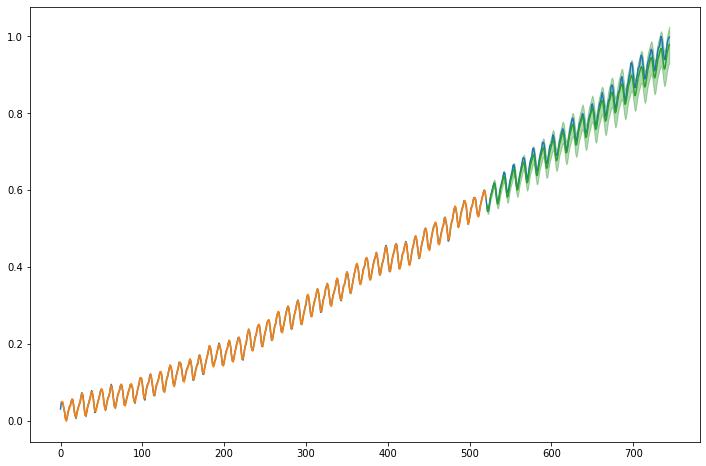

In [0]:
# ypreds2_mean = ypreds2_mean[0,:,0]
# ypreds2_std  = ypreds2_std[0,:,0]

# ypreds_test_mean = ypreds_test_mean[0,:,0] 
# ypreds_test_std = ypreds_test_std[0,:,0] 

plt.figure(figsize=(12,8))
#plt.plot(np.arange(1,T_train),y[0,:,0,0])
plt.plot(dataset)
plt.plot(np.arange(1,T_train),ypreds2_mean)
plt.fill_between(np.arange(1,T_train), 
                  ypreds2_mean- 2 * ypreds2_std, 
                  ypreds2_mean + 2 * ypreds2_std,color='orange',
                  alpha=0.3)
plt.plot(np.arange(T_train, T),ypreds_test_mean )
plt.fill_between(np.arange(T_train,T), 
                  ypreds_test_mean- 2 * ypreds_test_std, 
                  ypreds_test_mean + 2 * ypreds_test_std,color='green',
                  alpha=0.3)

# for i in range(-1,-10,-1):
#   plt.plot(np.arange(T_train, T),ypreds_test[i,0,:,0,0])

# print('d=',d)
# print('temp=',tanh_temp)
# print('num_parts=',tanh_numparts)
# print('alpha=',1.1)
# print('beta=',.00001)
# print('Wbar_sigma=',.1)

GRU

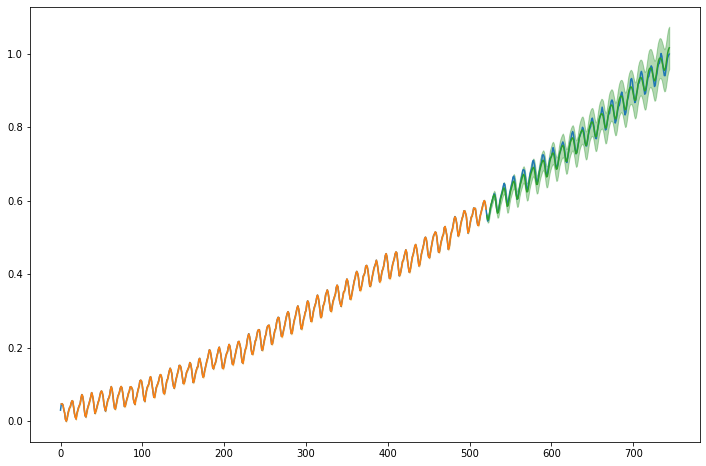

In [0]:
#Run, Run main traning block twice more, 100 mstep iterations each
# if model_type =='GRU':  
#   if train_type == 'EM':
#     prior= False
#     mb_size=1
#     Estep_burn_iters=3
#     Estep_sample_iters=2
#     mstep_iters=100#100
#     num_post_samples=200
#     post_burn_iters = 100
#     rhoexp = .6 #0.5< rhoexp <=1 #smaller, leads to larger updates, 
#               #so forget old suff stats more quickly, 
#               #which leads to quicker updates but more instability
#     #warmup_iters = 0 #250
#   elif train_type== 'gibbs':
#     prior=True
#     burn_iters = 100
#     num_post_samples=200

#   d=10
#   tanh_window=4 
#   tanh_numparts=4
#   tanh_temp= .1
#   i_window=4 
#   i_numparts=4
#   i_temp= .1
#   r_window=4 
#   r_numparts=4
#   r_temp= .1

#   mu_init = np.zeros((num_obs, d,1))
#   sigma_init = 0.01*np.ones((d,1))#npr.uniform(size=(d,1))

#   calpha = 1.1
#   cbeta = 1e-10


#   # calpha = 1.1
#   # cbeta = .0000025

#   calphax = 1.1
#   cbetax = 1e-5
#   calphay = 1.1
#   cbetay = 1e-5



#   alpha = calphax*np.ones((d,1))
#   beta = cbetax*np.ones((d,1))
#   sigma = np.sqrt(invgamma.rvs(alpha, scale=beta, size=(d,1)))
#   #sigma = .01*np.ones((d,1))     #npr.uniform(low=10, high=11,size=(d,1))
#   print(sigma)
  
#   alphay = calphay*np.ones((yd,1))
#   betay = cbetay*np.ones((yd,1))
#   sigma_y = np.sqrt(invgamma.rvs(alphay, scale=betay,size=(yd,1)))
#   #sigma_y = 0.01*np.ones((yd,1)) #npr.uniform(size=(yd,1))
#   print(sigma_y)

#   alphai = calpha*np.ones((d,1))
#   betai = cbeta*np.ones((d,1))
#   sigma_i = np.sqrt(invgamma.rvs(alphai, scale=betai, size=(d,1)))
#   #sigma_i = 0.01*np.ones((d,1))#npr.uniform(.01,.3,size=(d,1))
  
#   alphar = calpha*np.ones((d,1))
#   betar = cbeta*np.ones((d,1))
#   sigma_r = np.sqrt(invgamma.rvs(alphar, scale=betar, size=(d,1)))
#   #sigma_r = 0.01*np.ones((d,1))#npr.uniform(.01,.3,size=(d,1))

#   Wbari_prior = 0*np.ones((d,d+ud+1))
#   Wbari_sigma = .1*np.ones(Wbari_prior.shape)
#   Wbari = npr.normal(Wbari_prior, Wbari_sigma)
#   Wi = Wbari[:,:d]
#   Bi = Wbari[:,d:]

#   Wbarr_prior = 0*np.ones((d,d+ud+1))
#   Wbarr_sigma = .1*np.ones(Wbarr_prior.shape)
#   Wbarr = npr.normal(Wbarr_prior, Wbarr_sigma)
#   Wr = Wbarr[:,:d]
#   Br = Wbarr[:,d:]

#   Wbarp_prior = 0*np.ones((d,d+ud+1))
#   Wbarp_sigma = .1*np.ones(Wbarp_prior.shape)
#   Wbarp = npr.normal(Wbarp_prior, Wbarp_sigma)
#   Wp = Wbarp[:,:d]
#   Bp = Wbarp[:,d:]

#   Wbary_prior = 0*np.ones((yd,d+1))
#   Wbary_sigma = .1*np.ones(Wbary_prior.shape)
#   Wbary = npr.normal(Wbary_prior, Wbary_sigma)
#   C = Wbary[:,:d]
#   by = Wbary[:,d:]

#   # #Sample the vanilla RNN to initialize x
#   # x = np.zeros((num_obs,T_train, d, 1))
#   # for i in range(num_obs):
#   #   x[i,0] = mu_init[i]+sigma_init*npr.randn(d,1)
#   #   for t in range(1, T_train):
#   #     x[i,t] = np.tanh(Wi @ x[i,t-1] + Bi @ u[i,t]) + sigma * npr.randn(d,1)
#   # print('x:',x.shape)
#   # x_full=np.copy(x)


#   #Sample model to initialize x and z
#   model_args = (Wi,Bi,Wr,Br,Wp,Bp,mu_init,sigma_init,sigma, 
#                             C,by,sigma_y,sigma_i, sigma_r)
#   model_kwargs = {'tanh_numparts':tanh_numparts,
#                 'tanh_window':tanh_window, 'tanh_temp':tanh_temp,'sigmoid_i_numparts':i_numparts,
#                 'sigmoid_i_window':i_window, 'sigmoid_i_temp':i_temp,'sigmoid_r_numparts':r_numparts,
#                 'sigmoid_r_window':r_window, 'sigmoid_r_temp':r_temp,
#                 'Wbar_i_prior':Wbari_prior,'Wbar_i_sigma':Wbari_sigma,
#                 'alphai':alphai, 'betai':betai,
#                 'Wbar_r_prior':Wbarr_prior,'Wbar_r_sigma':Wbarr_sigma,
#                 'alphar':alphar, 'betar':betar,
#                 'Wbar_p_prior':Wbarp_prior,'Wbar_p_sigma':Wbarp_sigma,
#                 'alpha':alpha, 'beta':beta,
#                 'Wbar_y_prior':Wbary_prior,'Wbar_y_sigma':Wbary_sigma,
#                 'alphay':alphay, 'betay':betay}
#   samplemodel = StochPiecewiseLinearGRU(*model_args, **model_kwargs)
#   x = np.zeros((num_obs,T_train, d, 1))
#   zi_init = np.zeros(x[:,1:T_train].shape, dtype=np.int16)
#   zr_init = np.zeros(x[:,1:T_train].shape, dtype=np.int16)
#   zp_init = np.zeros(x[:,1:T_train].shape, dtype=np.int16)
#   i_init =  np.zeros(x[:,1:T_train].shape)
#   r_init =  np.zeros(x[:,1:T_train].shape)
#   for i in range(num_obs):
#     x[i,0] = mu_init[i]+sigma_init*npr.randn(d,1)
#     for t in range(1, T_train):
#       x[i,t], _, zi_init[i,t-1],i_init[i,t-1],zr_init[i,t-1],r_init[i,t-1],zp_init[i,t-1] =samplemodel.f(x[i,t-1], u[i,t], Wbari,Wbarr,Wbarp,Wbary, return_z=True) 

#   print('x:',x.shape)
#   x_full=np.copy(x)




# ypreds2_mean = ypreds2_mean[0,:,0]
# ypreds2_std  = ypreds2_std[0,:,0]

# ypreds_test_mean = ypreds_test_mean[0,:,0] 
# ypreds_test_std = ypreds_test_std[0,:,0] 

plt.figure(figsize=(12,8))
#plt.plot(np.arange(1,T_train),y[0,:,0,0])
plt.plot(dataset)
plt.plot(np.arange(1,T_train),ypreds2_mean)
plt.fill_between(np.arange(1,T_train), 
                  ypreds2_mean- 2 * ypreds2_std, 
                  ypreds2_mean + 2 * ypreds2_std,color='orange',
                  alpha=0.3)
plt.plot(np.arange(T_train, T),ypreds_test_mean )
plt.fill_between(np.arange(T_train,T), 
                  ypreds_test_mean- 2 * ypreds_test_std, 
                  ypreds_test_mean + 2 * ypreds_test_std,color='green',
                  alpha=0.3)

# end=50
# plt.plot(np.arange(T_train, T-end),ypreds_test_mean[:-end] )
# plt.fill_between(np.arange(T_train,T-end), 
#                   ypreds_test_mean[:-end]- 2 * ypreds_test_std[:-end], 
#                   ypreds_test_mean[:-end] + 2 * ypreds_test_std[:-end],color='green',
#                   alpha=0.3)

# for i in range(-1,-10,-1):
#   plt.plot(np.arange(T_train, T),ypreds_test[i,0,:,0,0])

# print('d=',d)
# print('temp=',tanh_temp)
# print('num_parts=',tanh_numparts)
# print('alpha=',1.1)
# print('beta=',.00001)
# print('Wbar_sigma=',.1)

# Sine Wave

GRU Gibbs: d=30, num_parts=16, tanhtemp=.1, other temps=.2, alpha=1.1,
beta=.00001, sigma_init=.01, bar_sigma=.1

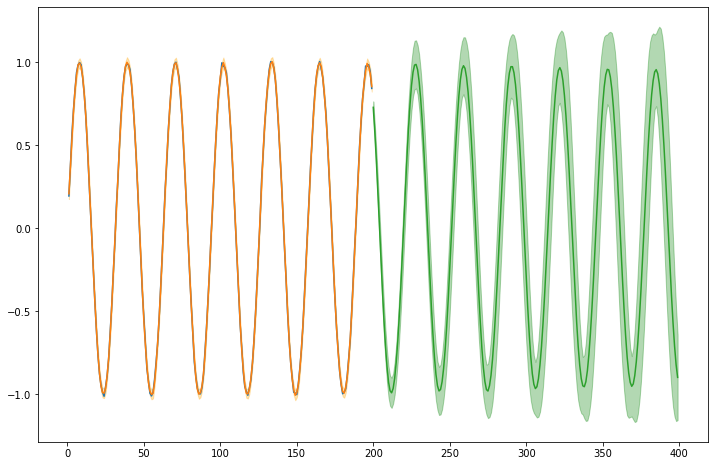

In [0]:
# ypreds2_mean = ypreds2_mean[0,:,0]
# ypreds2_std  = ypreds2_std[0,:,0]

# ypreds_test_mean = ypreds_test_mean[0,:,0] 
# ypreds_test_std = ypreds_test_std[0,:,0] 

plt.figure(figsize=(12,8))
plt.plot(np.arange(1,T_train),y[0,:,0,0])
plt.plot(np.arange(1,T_train),ypreds2_mean)
plt.fill_between(np.arange(1,T_train), 
                  ypreds2_mean- 2 * ypreds2_std, 
                  ypreds2_mean + 2 * ypreds2_std,color='orange',
                  alpha=0.3)
plt.plot(np.arange(T_train, T),ypreds_test_mean )
plt.fill_between(np.arange(T_train,T), 
                  ypreds_test_mean- 2 * ypreds_test_std, 
                  ypreds_test_mean + 2 * ypreds_test_std,color='green',
                  alpha=0.3)

# print('d=',d)
# print('temp=',tanh_temp)
# print('num_parts=',tanh_numparts)
# print('alpha=',1.1)
# print('beta=',.00001)
# print('Wbar_sigma=',.1)

In [0]:
#Inference results
for m in range(0,num_obs):
  print('obs={}'.format(m))
  for i in range(0,d):
    plt.figure(figsize=(12, 8))
    xsample_mean = np.mean(x_samples, axis=0)[m,:,i,0]
    xsample_std = np.std(x_samples,axis=0)[m,:,i,0]

    plt.plot(np.arange(0,T_train), xsample_mean[0:T_train], label='Dimension={}'.format(i+1))

    plt.fill_between(np.arange(0,T_train), 
                  xsample_mean[0:T_train] - 2 * xsample_std[0:T_train], 
                  xsample_mean[0:T_train] + 2 * xsample_std[0:T_train],
                  alpha=0.3)

    #plt.plot(xsample_mean)
    #plot_inf(x_obs[m,:,i,0], T,T_train,  xsample_mean, xsample_std, sigma, d, tanh_numparts, tanh_temp)
    plotx_pred(T,T_train,xpreds_mean[m,:,i], xpreds_std[m,:,i], xpostpreds_mean[m,:,i], xpostpreds_std[m,:,i], sigma, d, tanh_numparts, tanh_temp)

Output hidden; open in https://colab.research.google.com to view.

GRU EM, temp=.1, numparts=4, alpha=1.1, beta=1e-5

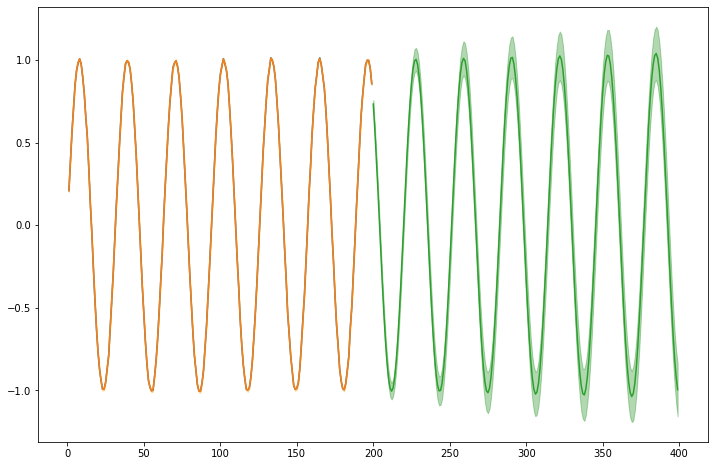

In [0]:
# ypreds2_mean = ypreds2_mean[0,:,0]
# ypreds2_std  = ypreds2_std[0,:,0]

# ypreds_test_mean = ypreds_test_mean[0,:,0] 
# ypreds_test_std = ypreds_test_std[0,:,0] 

plt.figure(figsize=(12,8))
plt.plot(np.arange(1,T_train),y[0,:,0,0])
#plt.plot(dataset)
plt.plot(np.arange(1,T_train),ypreds2_mean)
plt.fill_between(np.arange(1,T_train), 
                  ypreds2_mean- 2 * ypreds2_std, 
                  ypreds2_mean + 2 * ypreds2_std,color='orange',
                  alpha=0.3)
plt.plot(np.arange(T_train, T),ypreds_test_mean )
plt.fill_between(np.arange(T_train,T), 
                  ypreds_test_mean- 2 * ypreds_test_std, 
                  ypreds_test_mean + 2 * ypreds_test_std,color='green',
                  alpha=0.3)

# for i in range(-1,-10,-1):
#   plt.plot(np.arange(T_train, T),ypreds_test[i,0,:,0,0])

# print('d=',d)
# print('temp=',tanh_temp)
# print('num_parts=',tanh_numparts)
# print('alpha=',1.1)
# print('beta=',.00001)
# print('Wbar_sigma=',.1)

GRU EM sine wave sigmay=.1 (more noisy), same EM settings as .01 sigmay var

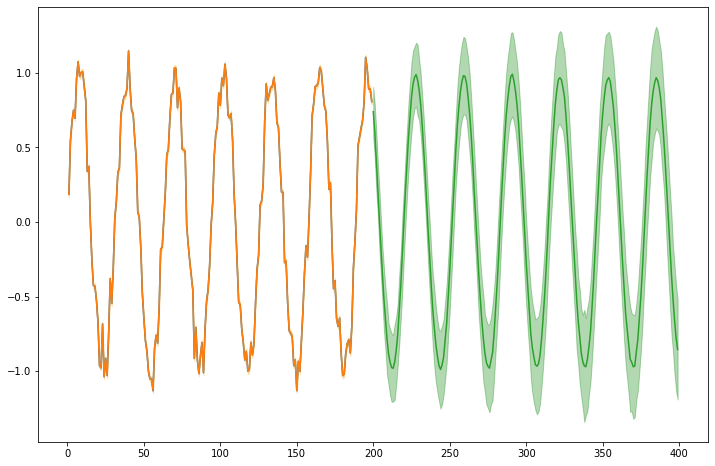

In [0]:
# ypreds2_mean = ypreds2_mean[0,:,0]
# ypreds2_std  = ypreds2_std[0,:,0]

# ypreds_test_mean = ypreds_test_mean[0,:,0] 
# ypreds_test_std = ypreds_test_std[0,:,0] 

plt.figure(figsize=(12,8))
plt.plot(np.arange(1,T_train),y[0,:,0,0])
#plt.plot(dataset)
plt.plot(np.arange(1,T_train),ypreds2_mean)
plt.fill_between(np.arange(1,T_train), 
                  ypreds2_mean- 2 * ypreds2_std, 
                  ypreds2_mean + 2 * ypreds2_std,color='orange',
                  alpha=0.3)
plt.plot(np.arange(T_train, T),ypreds_test_mean )
plt.fill_between(np.arange(T_train,T), 
                  ypreds_test_mean- 2 * ypreds_test_std, 
                  ypreds_test_mean + 2 * ypreds_test_std,color='green',
                  alpha=0.3)

# for i in range(-1,-10,-1):
#   plt.plot(np.arange(T_train, T),ypreds_test[i,0,:,0,0])

# print('d=',d)
# print('temp=',tanh_temp)
# print('num_parts=',tanh_numparts)
# print('alpha=',1.1)
# print('beta=',.00001)
# print('Wbar_sigma=',.1)

GRU Gibbs no variance update

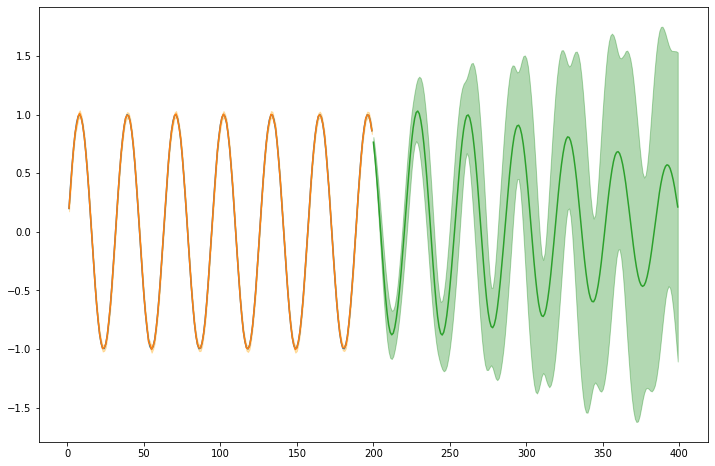

In [0]:
ypreds2_mean = ypreds2_mean[0,:,0]
ypreds2_std  = ypreds2_std[0,:,0]

ypreds_test_mean = ypreds_test_mean[0,:,0] 
ypreds_test_std = ypreds_test_std[0,:,0] 

plt.figure(figsize=(12,8))
plt.plot(np.arange(1,T_train),y[0,:,0,0])
plt.plot(np.arange(1,T_train),ypreds2_mean)
plt.fill_between(np.arange(1,T_train), 
                  ypreds2_mean- 2 * ypreds2_std, 
                  ypreds2_mean + 2 * ypreds2_std,color='orange',
                  alpha=0.3)
plt.plot(np.arange(T_train, T),ypreds_test_mean )
plt.fill_between(np.arange(T_train,T), 
                  ypreds_test_mean- 2 * ypreds_test_std, 
                  ypreds_test_mean + 2 * ypreds_test_std,color='green',
                  alpha=0.3)

GRU EM, no variance update

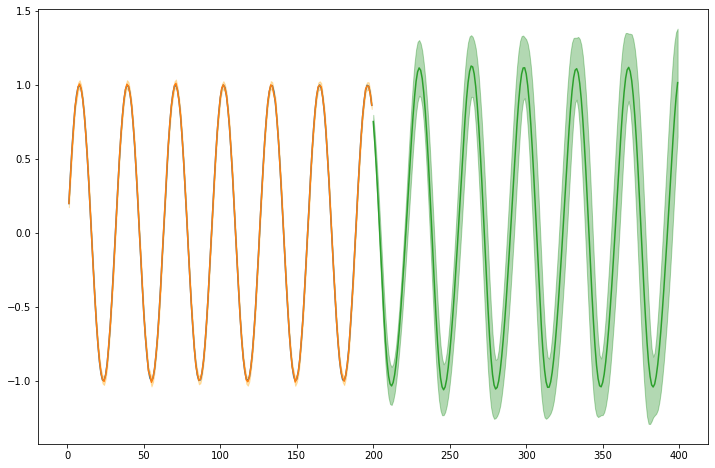

In [0]:
ypreds2_mean = ypreds2_mean[0,:,0]
ypreds2_std  = ypreds2_std[0,:,0]

ypreds_test_mean = ypreds_test_mean[0,:,0] 
ypreds_test_std = ypreds_test_std[0,:,0] 

plt.figure(figsize=(12,8))
plt.plot(np.arange(1,T_train),y[0,:,0,0])
plt.plot(np.arange(1,T_train),ypreds2_mean)
plt.fill_between(np.arange(1,T_train), 
                  ypreds2_mean- 2 * ypreds2_std, 
                  ypreds2_mean + 2 * ypreds2_std,color='orange',
                  alpha=0.3)
plt.plot(np.arange(T_train, T),ypreds_test_mean )
plt.fill_between(np.arange(T_train,T), 
                  ypreds_test_mean- 2 * ypreds_test_std, 
                  ypreds_test_mean + 2 * ypreds_test_std,color='green',
                  alpha=0.3)

In [0]:
#Inference results
for m in range(0,num_obs):
  print('obs={}'.format(m))
  for i in range(0,d):
    plt.figure(figsize=(12, 8))
    xsample_mean = np.mean(x_samples, axis=0)[m,:,i,0]
    xsample_std = np.std(x_samples,axis=0)[m,:,i,0]

    plt.plot(np.arange(0,T_train), xsample_mean[0:T_train], label='Dimension={}'.format(i+1))

    plt.fill_between(np.arange(0,T_train), 
                  xsample_mean[0:T_train] - 2 * xsample_std[0:T_train], 
                  xsample_mean[0:T_train] + 2 * xsample_std[0:T_train],
                  alpha=0.3)

    #plt.plot(xsample_mean)
    #plot_inf(x_obs[m,:,i,0], T,T_train,  xsample_mean, xsample_std, sigma, d, tanh_numparts, tanh_temp)
    plotx_pred(T,T_train,xpreds_mean[m,:,i], xpreds_std[m,:,i], xpostpreds_mean[m,:,i], xpostpreds_std[m,:,i], sigma, d, tanh_numparts, tanh_temp)

Output hidden; open in https://colab.research.google.com to view.

Vanilla RNN Gibbs

d= 10
temp= 0.1
num_parts= 16
alpha= 1.1
beta= 1e-05
Wbar_sigma= 0.1


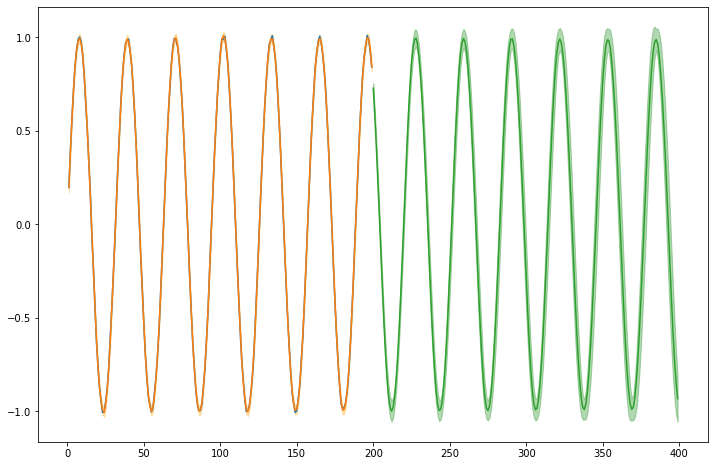

In [0]:
# ypreds2_mean = ypreds2_mean[0,:,0]
# ypreds2_std  = ypreds2_std[0,:,0]

# ypreds_test_mean = ypreds_test_mean[0,:,0] 
# ypreds_test_std = ypreds_test_std[0,:,0] 

plt.figure(figsize=(12,8))
plt.plot(np.arange(1,T_train),y[0,:,0,0])
plt.plot(np.arange(1,T_train),ypreds2_mean)
plt.fill_between(np.arange(1,T_train), 
                  ypreds2_mean- 2 * ypreds2_std, 
                  ypreds2_mean + 2 * ypreds2_std,color='orange',
                  alpha=0.3)
plt.plot(np.arange(T_train, T),ypreds_test_mean )
plt.fill_between(np.arange(T_train,T), 
                  ypreds_test_mean- 2 * ypreds_test_std, 
                  ypreds_test_mean + 2 * ypreds_test_std,color='green',
                  alpha=0.3)

print('d=',d)
print('temp=',tanh_temp)
print('num_parts=',tanh_numparts)
print('alpha=',1.1)
print('beta=',.00001)
print('Wbar_sigma=',.1)
#around 3000 iterations

Vanilla RNN EM d=10, num_parts=4, temp=.1, init with alpha=1.1, beta=1e-5 samples, mstep_iters=300, e_stepburn=3, e_step_sample=2

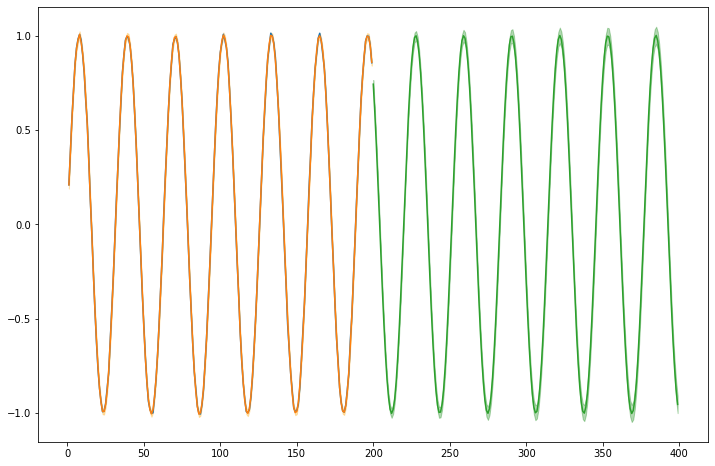

In [0]:
# ypreds2_mean = ypreds2_mean[0,:,0]
# ypreds2_std  = ypreds2_std[0,:,0]

# ypreds_test_mean = ypreds_test_mean[0,:,0] 
# ypreds_test_std = ypreds_test_std[0,:,0] 

plt.figure(figsize=(12,8))
plt.plot(np.arange(1,T_train),y[0,:,0,0])
#plt.plot(dataset)
plt.plot(np.arange(1,T_train),ypreds2_mean)
plt.fill_between(np.arange(1,T_train), 
                  ypreds2_mean- 2 * ypreds2_std, 
                  ypreds2_mean + 2 * ypreds2_std,color='orange',
                  alpha=0.3)
plt.plot(np.arange(T_train, T),ypreds_test_mean )
plt.fill_between(np.arange(T_train,T), 
                  ypreds_test_mean- 2 * ypreds_test_std, 
                  ypreds_test_mean + 2 * ypreds_test_std,color='green',
                  alpha=0.3)

# for i in range(-1,-10,-1):
#   plt.plot(np.arange(T_train, T),ypreds_test[i,0,:,0,0])

# print('d=',d)
# print('temp=',tanh_temp)
# print('num_parts=',tanh_numparts)
# print('alpha=',1.1)
# print('beta=',.00001)
# print('Wbar_sigma=',.1)

obs=0


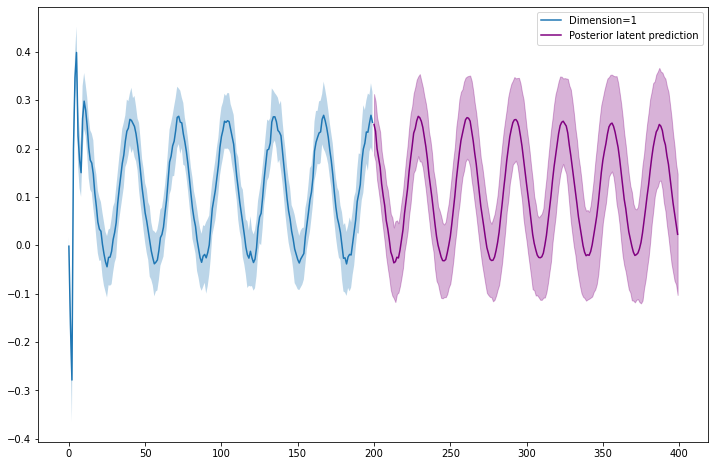

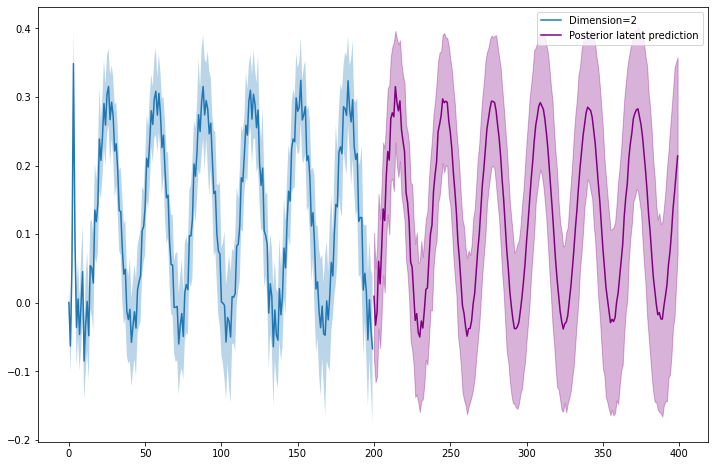

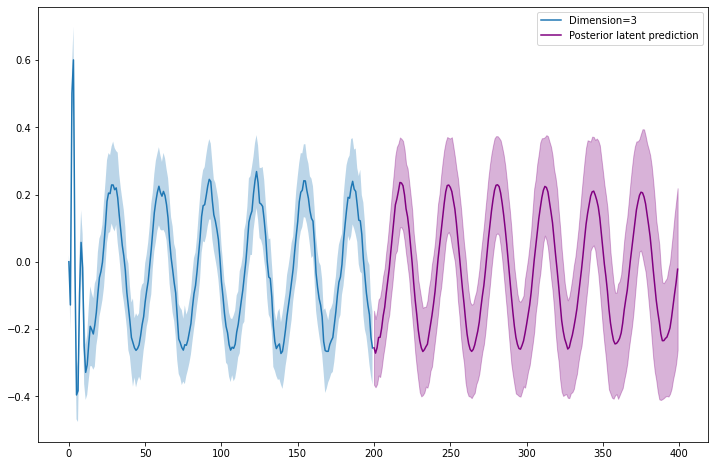

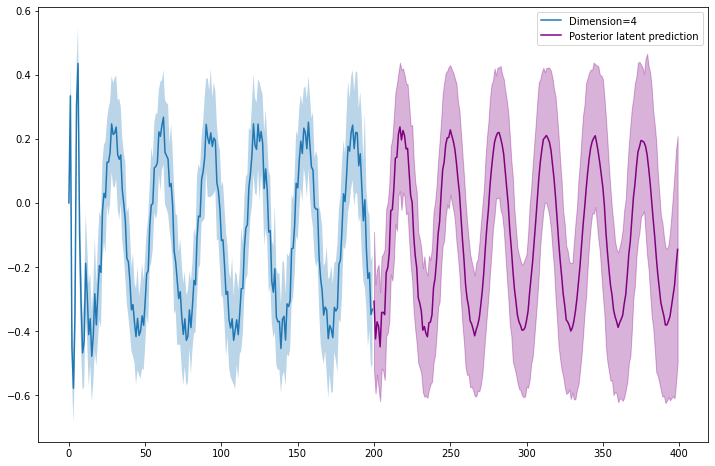

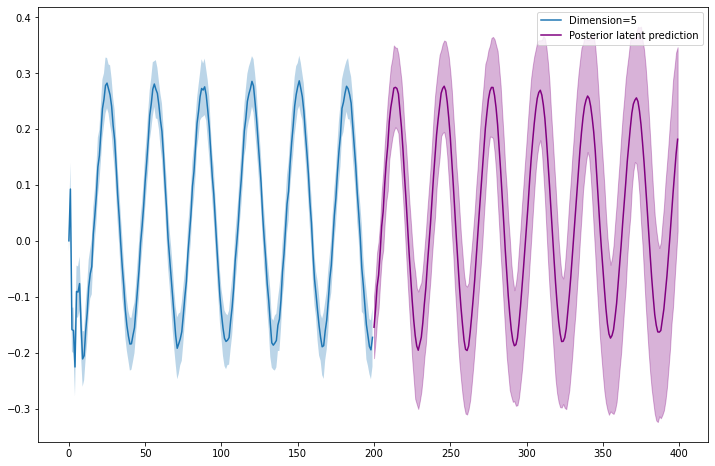

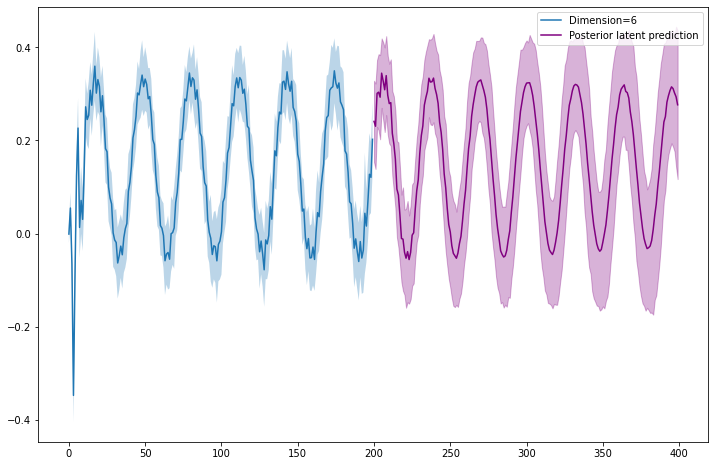

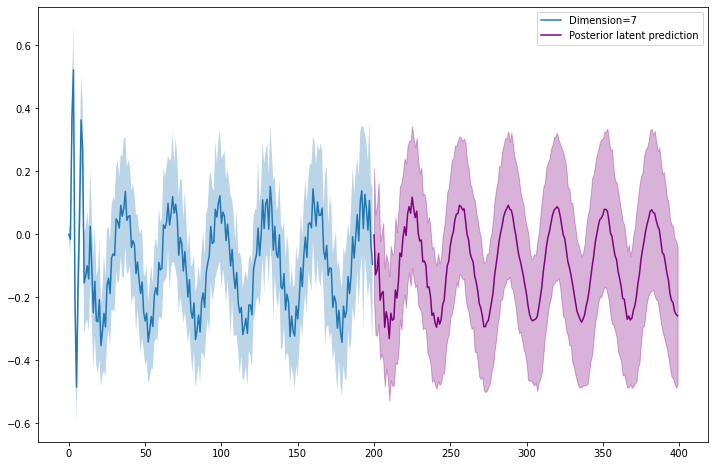

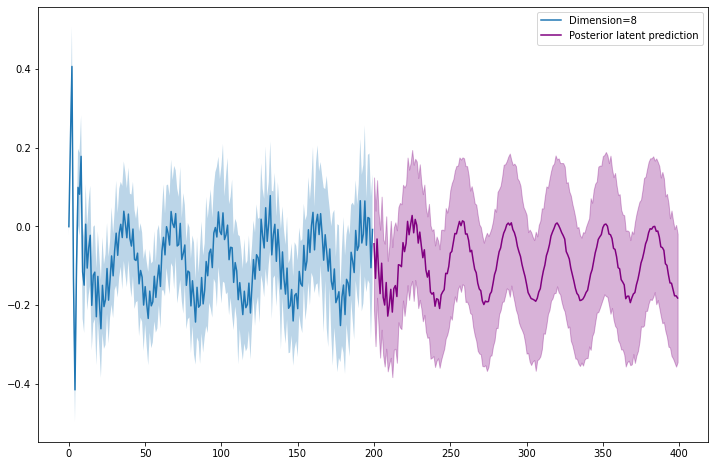

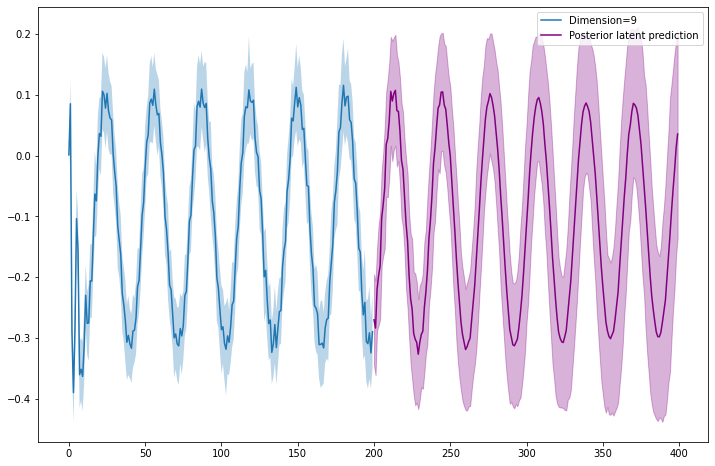

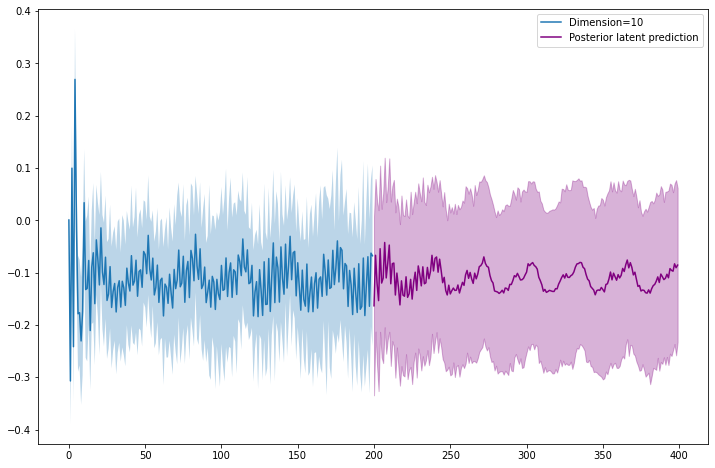

In [0]:
#Inference results
for m in range(0,num_obs):
  print('obs={}'.format(m))
  for i in range(0,d):
    plt.figure(figsize=(12, 8))
    xsample_mean = np.mean(x_samples, axis=0)[m,:,i,0]
    xsample_std = np.std(x_samples,axis=0)[m,:,i,0]

    plt.plot(np.arange(0,T_train), xsample_mean[0:T_train], label='Dimension={}'.format(i+1))

    plt.fill_between(np.arange(0,T_train), 
                  xsample_mean[0:T_train] - 2 * xsample_std[0:T_train], 
                  xsample_mean[0:T_train] + 2 * xsample_std[0:T_train],
                  alpha=0.3)

    #plt.plot(xsample_mean)
    #plot_inf(x_obs[m,:,i,0], T,T_train,  xsample_mean, xsample_std, sigma, d, tanh_numparts, tanh_temp)
    plotx_pred(T,T_train,xpreds_mean[m,:,i], xpreds_std[m,:,i], xpostpreds_mean[m,:,i], xpostpreds_std[m,:,i], sigma, d, tanh_numparts, tanh_temp)

vanRNN EM sine wave sigmay=.1 (more noisy), same EM settings as .01 sigmay var

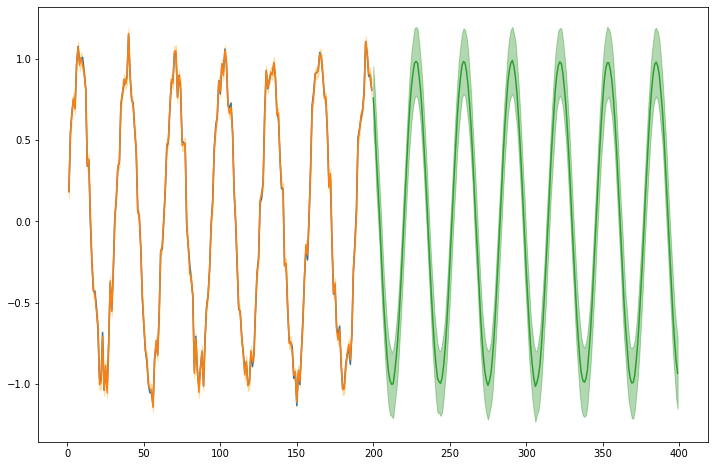

In [0]:
# ypreds2_mean = ypreds2_mean[0,:,0]
# ypreds2_std  = ypreds2_std[0,:,0]

# ypreds_test_mean = ypreds_test_mean[0,:,0] 
# ypreds_test_std = ypreds_test_std[0,:,0] 

plt.figure(figsize=(12,8))
plt.plot(np.arange(1,T_train),y[0,:,0,0])
#plt.plot(dataset)
plt.plot(np.arange(1,T_train),ypreds2_mean)
plt.fill_between(np.arange(1,T_train), 
                  ypreds2_mean- 2 * ypreds2_std, 
                  ypreds2_mean + 2 * ypreds2_std,color='orange',
                  alpha=0.3)
plt.plot(np.arange(T_train, T),ypreds_test_mean )
plt.fill_between(np.arange(T_train,T), 
                  ypreds_test_mean- 2 * ypreds_test_std, 
                  ypreds_test_mean + 2 * ypreds_test_std,color='green',
                  alpha=0.3)

# for i in range(-1,-10,-1):
#   plt.plot(np.arange(T_train, T),ypreds_test[i,0,:,0,0])

# print('d=',d)
# print('temp=',tanh_temp)
# print('num_parts=',tanh_numparts)
# print('alpha=',1.1)
# print('beta=',.00001)
# print('Wbar_sigma=',.1)

# Old run code 

In [0]:
#seed = np.random.randint(low=0, high=1000000)
seed=579#53672#579#53672# 577#576#66934#126829#665346 #97865
print('seed={}'.format(seed))
npr.seed(seed)


Estep_burn_iters=0
Estep_sample_iters=1
mstep_iters=1600
num_post_samples=300
post_burn_iters = 0
tanh_window=4 #4
tanh_numparts=16 #16
tanh_temp= .1#1#.25
rhoexp = .6 #0.5< rhoexp <=1 #smaller, leads to larger updates, 
            #so forget old suff stats more quickly, 
            #which leads to quicker updates but more instability
#NEED to fix where num_obs%mbsize != 0:
warmup_iters = 0 #250
num_obs=1
mb_size=1


d = 10
yd = 1 #y dimension
ud=yd #u' dimension
T = 400
T_train = 200
mu_init = np.zeros((num_obs, d,1))

####inx = Wx_{t-1}+Bu_t, where B = [B', b] and u_t = [u_t'^T, 1]^T (includes 1 for bias term)####
#x0 = npr.uniform(-1,1,size=(num_obs,d,1))


'''
u_ = 0*np.ones((T, ud,1))#npr.uniform(size=(T,ud,1))
#u_[0:T_train-5:5] = -1
#u_[T_train+5:-1:8] = -1
u = np.concatenate((u_, np.ones((T,1,1))), axis=1)
'''
sigma_init = 0.01*np.ones((d,1))
sigma = 0.01*np.ones((d,1))
sigma_true = 0.01*np.ones((d,1))
sigma_y = 0.01*np.ones((yd,1)) 
sigma_ytrue = 0.01*np.ones((yd,1)) 

Wbar_prior = 0*np.ones((d,d+ud+1))
Wbar_sigma = .1*np.ones(Wbar_prior.shape)
Wbar = npr.normal(Wbar_prior, Wbar_sigma)
W = Wbar[:,:d]
B = Wbar[:,d:]


Wbary_prior = 0*np.ones((yd,d+1))
Wbary_sigma = .1*np.ones(Wbary_prior.shape)

Wbary = npr.normal(Wbary_prior, Wbary_sigma)
C = Wbary[:,:d]
by = Wbary[:,d:]




#sine wave
#data = np.sin(.2*(np.arange(0,T,1))).reshape(T,1,1)
u = np.zeros((num_obs, T, ud+1,1))
y = np.zeros((num_obs, T-1,yd,1))
data = np.zeros((num_obs,T,1,1))
for i in range(num_obs):
  c = npr.uniform(0.18,0.22)
  data[i] = np.sin(c*(np.arange(0,T,1))).reshape(T,1,1)
  y[i] = data[i,1:]+sigma_ytrue*npr.randn(*data[i,1:].shape)

  u_ = 0*np.ones((T, ud,1))
  u[i] = np.concatenate((u_, np.ones((T,1,1))), axis=1)
  u[i,1,0]=data[i,0]+sigma_ytrue*npr.randn()
  u[i,2:,0] = y[i,:-1,:,0]


# Sample the vanilla RNN
x = np.zeros((num_obs,T, d, 1))
for i in range(num_obs):
  x[i,0] = mu_init[i]+sigma*npr.randn(d,1)

  W_obs = W 
  B_obs = B

  for t in range(1, T):
    x[i,t] = np.tanh(W_obs @ x[i,t-1] + B_obs @ u[i,t]) + sigma * npr.randn(d,1)

z = npr.randint(low=0, high=tanh_numparts,size=x[:,1:T_train].shape)

# #random vanilla RNN data
# lo1 = -.5
# hi1 = -.3

# lo2 = .3
# hi2= .5

# #lo1 = .8
# #hi1 = 1

# #lo2 = .2
# #hi2= .4

# Wbar = npr.normal(Wbar_prior, Wbar_sigma)
# W_true = npr.uniform(lo1,hi1,size=W.shape)
# B_true = npr.uniform(lo2,hi2,size=B.shape)


# C_true = npr.uniform(lo1,hi1,size=C.shape)
# by_true = npr.uniform(lo2,hi2,size=by.shape)

# x0 = npr.uniform(-.5,.5,size=(num_obs, d,1))
# u = np.zeros((num_obs, T, ud+1,1))
# y = np.zeros((num_obs, T-1,yd,1))
# x = np.zeros((num_obs,T, d, 1))
# for i in range(num_obs):
#   u_ = 0*np.ones((T, ud,1))
#   u[i] = np.concatenate((u_, np.ones((T,1,1))), axis=1)

# # Sample the vanilla RNN
#   x[i,0] = x0[i]
#   u[i,1,:ud] = npr.uniform(size=u[i,1,:ud].shape)
#   W_obs = W_true 
#   B_obs = B_true
#   for t in range(1, T):
#     x[i,t] = np.tanh(W_obs @ x[i,t-1] + B_obs @ u[i,t]) + sigma_true * npr.randn(d,1)
#     y[i,t-1] = C_true @ x[i,t]+by_true +sigma_ytrue*npr.randn(*y[i,t-1].shape)
#     if t != T-1:
#       u[i,t+1,:ud] = y[i,t-1]


x_obs = np.copy(x) 

seed=579


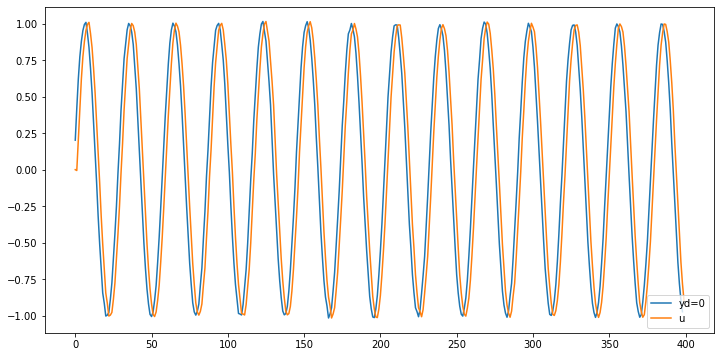

In [0]:
#Plot ys
plt.figure(figsize=(12, 6))
for i in range(0,num_obs):
  for j in range(0,yd):
    plt.plot(y[i,:,j,0], label = 'yd={}'.format(j)) 
    plt.plot(u[i,:,0,0], label='u')

plt.legend()

In [0]:
#Sine Wave
M=1000

y_true = np.zeros((num_obs,M,T-1,yd,1))

for j in range(0,num_obs):
  for n in range(M):
    y_true[j,n] = data[j,1:]+sigma_ytrue*npr.randn(*data[j,1:].shape)




ytrue_mean = np.mean(y_true, axis=1)[:,:,:,0]
ytrue_std = np.std(y_true, axis=1)[:,:, :,0]


print(ytrue_mean.shape)

(1, 399, 1)


In [0]:
# #Random data
# M=100

# x_true = np.zeros((num_obs,M,T,d,1))
# y_true = np.zeros((num_obs,M,T-1,yd,1))

# for i in range(num_obs):
#   for m in range(0,M):
#     # Sample the vanilla RNN
#     x_true[i,m,0] = x0[i]
#     ut = npr.uniform(size=u[i,1].shape)
#     W_obs = W_true 
#     B_obs = B_true


#     for t in range(1, T):
#       x_true[i,m,t] = np.tanh(W_obs @ x_true[i,m,t-1] + B_obs @ ut)
#       y_true[i,m,t-1] = C_true @ x_true[i,m,t]+by_true +sigma_ytrue*npr.randn(*y_true[i,m,t-1].shape)     
#       ut = np.concatenate((y_true[i,m,t-1], np.ones((1,1))), axis=0)
#     print(m)



# ytrue_mean = np.mean(y_true, axis=1)[:,:,:,0]
# ytrue_std = np.std(y_true, axis=1)[:,:, :,0]


# print(ytrue_mean.shape)

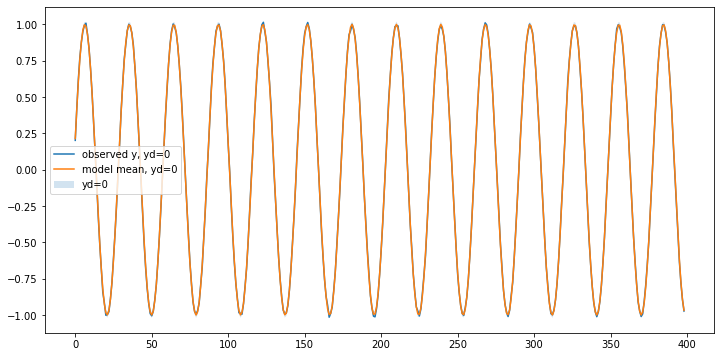

In [0]:
#Plot y means
for obs in range(num_obs):
  plt.figure(figsize=(12, 6))
  for i in range(0,yd):
    plt.plot(y[obs,:,i,0], label='observed y, yd={}'.format(i))
    plt.plot(ytrue_mean[obs,:,i], label='model mean, yd={}'.format(i))
    plt.fill_between(np.arange(T-1), 
                    ytrue_mean[obs,:,i] - 2 * ytrue_std[obs,:,i], 
                    ytrue_mean[obs,:,i] + 2 * ytrue_std[obs,:,i],
                    alpha=0.2, label='yd={}'.format(i))

plt.legend()

num_parts=16
0
4363.581502645571
1
6044.922806972635
2
5939.583919025836
3
6036.086781716811


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in log


4
5958.428855364847
5
6058.275324849439
6
6021.195228615127
7
6060.97346800999
8
6043.987320955085
9
6036.732435991267
10
6051.968183819506
11
6055.927834522981
12
6038.75272316288
13
6008.535315203046
14
6062.371311073445
15
6045.3943456411425
16
6030.631862938674
17
6057.155352816431
18
6049.880539896385
19
6069.637176342032
20
6033.846053138184
21
6087.529615592013
22
6027.095138080338
23
6073.913216490917
24
6040.489757587485
25
6038.176411353199
26
6084.970918962321
27
6116.836065466994
28
6074.216714763406
29
6114.632591291476
30
6037.105615933359
31
6054.512218977514
32
6029.781564035823
33
6048.840545929157
34
5980.540370288852
35
6041.265854020637
36
6083.066951224343
37
6012.3274830880255
38
6006.48166941475
39
6119.079206999156
40
6061.5006824956745
41
5991.8100524871625
42
6037.760108664339
43
6040.096105824072
44
6060.195195115661
45
6072.306860421923
46
6088.633515628052
47
6004.978775853404
48
6065.419466282138
49
6061.483542961811
50
6052.338107836151
51
6008.8733135729

Text(0.5, 0, 'iterations')

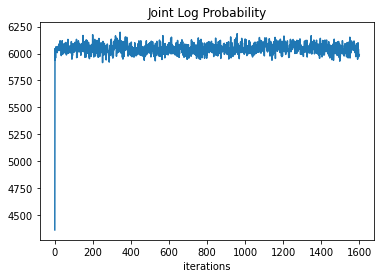

In [0]:
spwl_vanRNN = StochPiecewiseLinearVanillaRNN(W,B,mu_init,sigma_init,sigma, C,by,sigma_y,tanh_num_parts=tanh_numparts, tanh_window=tanh_window,  tanh_temp=tanh_temp)
batch_ops=Batch_Ops_vanRNN(y[:,:T_train-1], x[:,:T_train], u[:,:T_train], z, rhoexp)


#Warmup period to build up state:
######May need to add

mb_ind = 0
log_like_theta = []
#Burn-in period

for i in range(mstep_iters):
  ss_array = 0
  if mb_size < num_obs:
    batch_ops.update_rho(spwl_vanRNN,i)
  if mb_ind*mb_size >= num_obs:
    mb_ind = 0
  batch_ops.get_batch(spwl_vanRNN,mb_size, mb_ind)
  #log_like_batch = []
  for j in range(Estep_burn_iters):
    spwl_vanRNN.gibbs_Estep()
    #batch_ops.store_batch(spwl_vanRNN,mb_size, mb_ind)
    #log_like_batch.append(spwl_vanRNN.log_joint_nopgs(batch_ops))
    #print(log_like_batch[j])
  #if i ==5:
    #plt.plot(log_like_batch)
    #sys.exit()
  for j in range(Estep_sample_iters):
    ss_array += spwl_vanRNN.gibbs_Estep()


  batch_ops.store_batch(spwl_vanRNN,mb_size, mb_ind)
  ss_array = ss_array/Estep_sample_iters
  spwl_vanRNN.EM_Mstep(ss_array)
  mb_ind += 1
  #log_like_theta.append(spwl_vanRNN.log_joint_nopgs(batch_ops)) 
  log_like_theta.append(spwl_vanRNN.log_joint_nopgs(batch_ops.x_full, 
                                                    batch_ops.y_full,
                                                    batch_ops.u_full,
                                                    batch_ops.z_full))
  print(i)
  print(log_like_theta[i])

#Collect samples
#mb_size=num_obs
x_samples = np.zeros((num_post_samples,num_obs,T_train,d,1))
z_samples = np.zeros((num_post_samples, num_obs, T_train-1, d,1))

mb_ind =0 
for m in range(0,int(num_obs/mb_size)):
  #log_like_batch = []
  batch_ops.get_batch(spwl_vanRNN,mb_size, mb_ind)

  #Burn in 
  for i in range(post_burn_iters):    
    spwl_vanRNN.gibbs_Estep()
    print(i)
    #batch_ops.store_batch(spwl_vanRNN,mb_size, mb_ind)
    #log_like_batch.append(spwl_vanRNN.log_joint_nopgs(batch_ops))
    #print(log_like_batch[i])

  #plt.plot(log_like_batch) 
  #sys.exit() 

  #Collect Samples
  for i in range(num_post_samples):   
    spwl_vanRNN.gibbs_Estep()
    x_samples[i,mb_ind*mb_size:mb_ind*mb_size+mb_size] = spwl_vanRNN.x
    z_samples[i, mb_ind*mb_size:mb_ind*mb_size+mb_size] = spwl_vanRNN.spwl_tanh.z
    print(i)
  mb_ind += 1
  print(m)


plt.title('Joint Log Probability')
plt.plot(log_like_theta)
plt.xlabel('iterations')

(300, 1, 199, 10, 1)
(199, 10, 1)


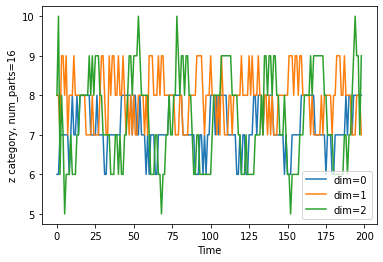

In [0]:
print(z_samples.shape)
samp = z_samples[10,0]
print(samp.shape)
for i in range(3):
  plt.plot(samp[:,i,0], label='dim={}'.format(i))
plt.xlabel('Time')
plt.ylabel('z category, num_parts={}'.format(tanh_numparts))
plt.legend()

(300, 1, 199, 10, 1)
(199, 10, 1)


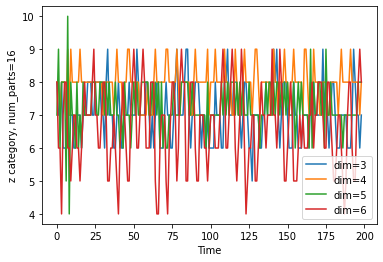

In [0]:
print(z_samples.shape)
samp = z_samples[10,0]
print(samp.shape)
for i in range(3,7):
  plt.plot(samp[:,i,0], label='dim={}'.format(i))
plt.xlabel('Time')
plt.ylabel('z category, num_parts={}'.format(tanh_numparts))
plt.legend()

(300, 1, 199, 10, 1)
(199, 10, 1)


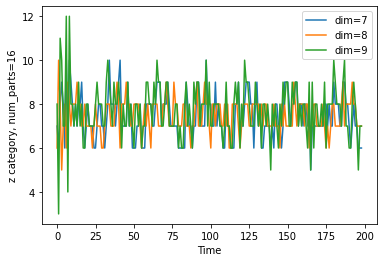

In [0]:
print(z_samples.shape)
samp = z_samples[10,0]
print(samp.shape)
for i in range(7,d):
  plt.plot(samp[:,i,0], label='dim={}'.format(i))
plt.xlabel('Time')
plt.ylabel('z category, num_parts={}'.format(tanh_numparts))
plt.legend()

In [0]:
z_list = []
cat_dict = {}
trans_dict = {}
trans_list = []
end_ind=-1
last_ind=0
max_ind = 0
for m in range(num_post_samples):
  for obs in range(num_obs):
    for t in range(T_train-1):
      l = list(z_samples[m,obs,t,:,0])
      if l in z_list:
        ind = z_list.index(l)
        cat_dict[ind]+=1
      else:
        z_list.append(l)
        end_ind +=1
        ind = end_ind
        cat_dict[ind]=1

      key = '{}to{}'.format(last_ind, ind)
      if key in trans_dict:
        trans_dict[key]+=1
      else:
        trans_dict[key]=1
        trans_list.append(list([last_ind, ind]))
      last_ind=ind
      max_ind = max(max_ind, ind)      
        
print(len(z_list))
print(z_list)
print(cat_dict)
print(trans_dict)
print(trans_list)
print(max_ind)

775
[[1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0], [1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0], [1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0], [1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0], [1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0], [1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0], [1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0], [1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0], [1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0], [2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0], [2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0], [2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 2.0], [1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0], [2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0], [2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0], [2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0], [2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0], [1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0], [2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0], [1.0, 1

Text(0.5, 1.0, 'Unique z states=775,\n Latent Dimension=10,\n Number of Intervals=4')

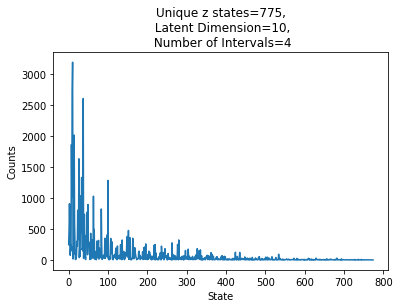

In [0]:
length = len(z_list)
counts = np.zeros(length)
for l in range(length):
  counts[l] = cat_dict[l]#/(num_post_samples*num_obs*(T_train-1))
plt.plot(counts)
plt.xlabel('State')
plt.ylabel('Counts')
plt.title('Unique z states={},\n Latent Dimension={},\n Number of Intervals={}'.format(len(z_list),d,tanh_numparts))

In [0]:
trans_mat = np.zeros((max_ind, max_ind))
for i in range(max_ind):
  for j in range(max_ind):
    if list([i,j]) in trans_list:
      trans_mat[i,j]=trans_dict['{}to{}'.format(i,j)]
  print(i)

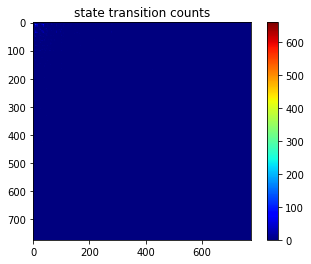

In [0]:
plt.imshow(trans_mat, cmap='jet')
plt.title('state transition counts')
plt.colorbar()

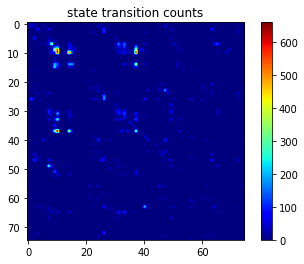

In [0]:
plt.imshow(trans_mat[:75,:75], cmap='jet')
plt.title('state transition counts')
plt.colorbar()

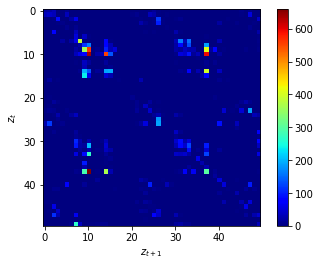

In [0]:
plt.imshow(trans_mat[:50,:50], cmap='jet')
plt.xlabel('$z_{t+1}$')
plt.ylabel('$z_{t}$')
plt.colorbar()

Text(0.5, 1.0, 'z states, num_parts=4')

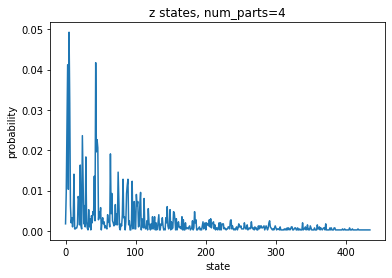

In [0]:
length = len(z_list)
probs = np.zeros(length)
for l in range(length):
  probs[l] = cat_dict[l]/(num_post_samples*num_obs*(T_train-1))
plt.plot(probs)
plt.xlabel('state')
plt.ylabel('probability')
plt.title('z states, num_parts={}'.format(tanh_numparts))

In [0]:
#Make Predictions
xpreds = np.zeros((num_post_samples,num_obs, T, d, 1))
ypreds = np.zeros((num_post_samples, num_obs,T-1, yd, 1))
ypreds2 = np.zeros((num_post_samples,num_obs, T_train-1, yd, 1))


xpreds_test = np.zeros((num_post_samples,num_obs, T, d, 1))
ypreds_test = np.zeros((num_post_samples,num_obs, T-T_train, yd, 1))


for n in range(num_post_samples):
  xpreds[n,:,0] = mu_init + sigma_init*npr.randn(*mu_init.shape)

  W = spwl_vanRNN.spwl_tanh.W
  B = spwl_vanRNN.spwl_tanh.B

  C = spwl_vanRNN.obs.C
  by = spwl_vanRNN.obs.by

  for t in range(1,T):
    #Using Sampled Weights
    mu_pred,_ = spwl_vanRNN.spwl_tanh.f(W @ xpreds[n,:, t-1] + B @ u[:,t],return_z=True)

    xpreds[n,:, t] = mu_pred + sigma * npr.randn(*mu_pred.shape)

  muy = C @ xpreds[n,:,1:]+by
  ypreds[n] = muy + sigma_y*npr.randn(*muy.shape)
  muy = C @ x_samples[n,:,1:]+ by
  ypreds2[n] = muy + sigma_y*npr.randn(*muy.shape)


  xpreds_test[n,:, T_train-1]=x_samples[n,:,-1] 
  ut = u[:,T_train]
  for t in range(T_train,T):
    mu_pred,_ = spwl_vanRNN.spwl_tanh.f(W @ xpreds_test[n,:,t-1] + B @ ut,return_z=True)
    xpreds_test[n,:,t] = mu_pred + sigma * npr.randn(*mu_pred.shape)
    muy = C @ xpreds_test[n,:,t]+by
    ypreds_test[n,:,t-T_train] = muy+sigma_y*npr.randn(*muy.shape)
    ut = np.concatenate((ypreds_test[n,:,t-T_train], np.ones(ypreds_test[n,:,t-T_train].shape)),axis=1)



xpreds_mean = np.mean(xpreds, axis=0)[:,:,:,0]
xpreds_std = np.std(xpreds, axis=0)[:, :,:,0]


xpostpreds_mean = np.mean(xpreds_test[:,:,T_train:], axis=0)[:,:,:,0]
xpostpreds_std = np.std(xpreds_test[:,:,T_train:], axis=0)[:, :,:,0]


ypreds_mean = np.mean(ypreds, axis=0)[:,:,:,0]
ypreds_std = np.std(ypreds, axis=0)[:,:,:,0]

ypreds2_mean = np.mean(ypreds2, axis=0)[:,:,:,0]
ypreds2_std = np.std(ypreds2, axis=0)[:, :,:,0]

ypreds_test_mean = np.mean(ypreds_test, axis=0)[:,:,:,0]
ypreds_test_std = np.std(ypreds_test, axis=0)[:, :,:,0]

obs=0


Text(0, 0.5, 'x')

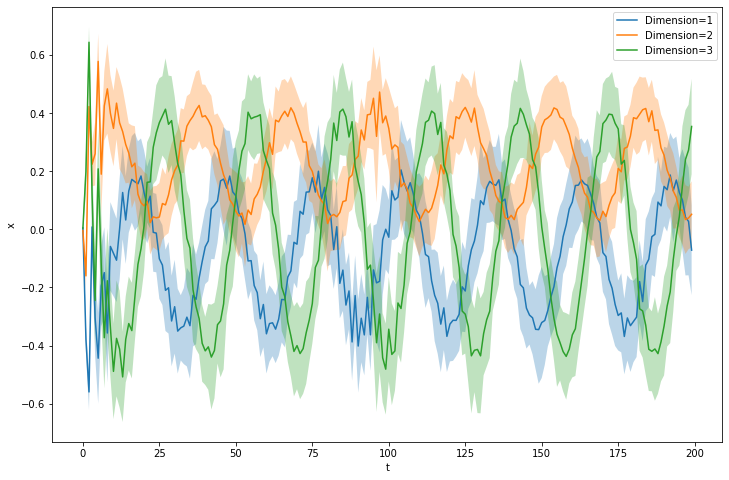

In [0]:
#Inference results
plt.figure(figsize=(12, 8))
for m in range(0,num_obs):
  print('obs={}'.format(m))
  for i in range(0,3):
    xsample_mean = np.mean(x_samples, axis=0)[m,:,i,0]
    xsample_std = np.std(x_samples,axis=0)[m,:,i,0]


    plt.plot(np.arange(0,T_train), xsample_mean[0:T_train], label='Dimension={}'.format(i+1))

    plt.fill_between(np.arange(0,T_train), 
                  xsample_mean[0:T_train] - 2 * xsample_std[0:T_train], 
                  xsample_mean[0:T_train] + 2 * xsample_std[0:T_train],
                  alpha=0.3)
  plt.legend()
plt.xlabel('t')
plt.ylabel('x')

obs=0


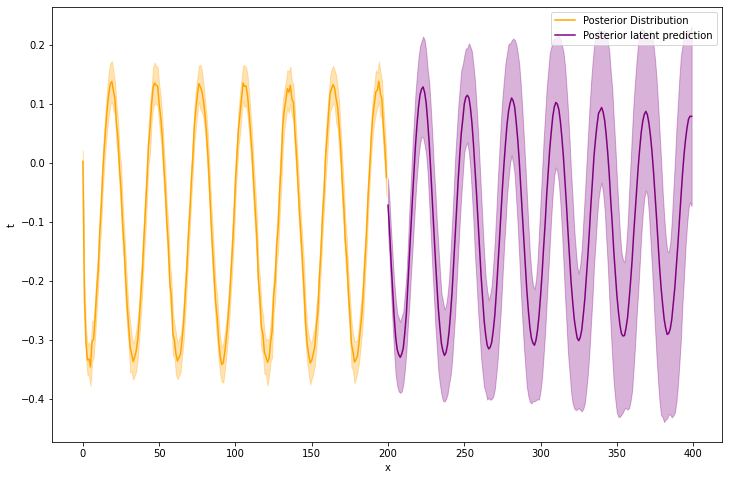

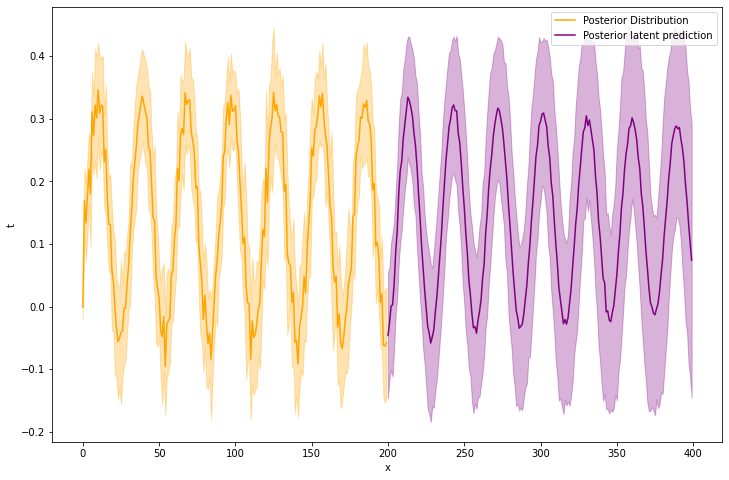

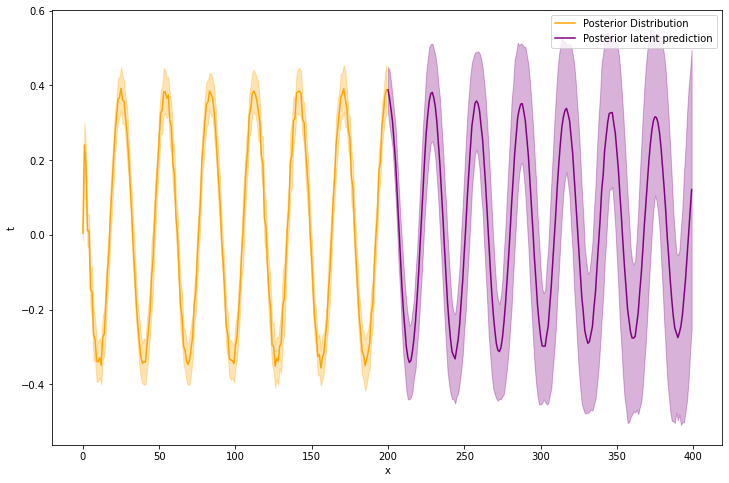

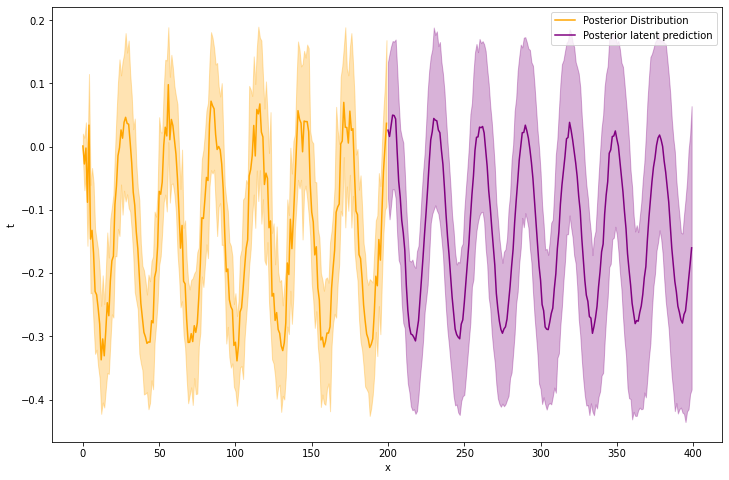

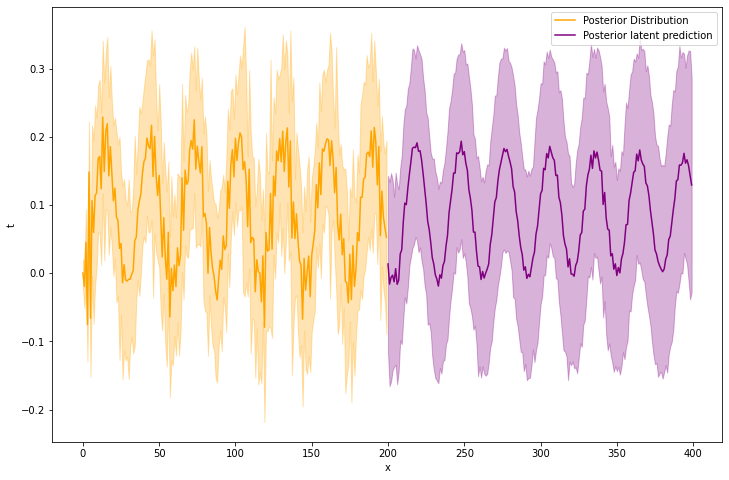

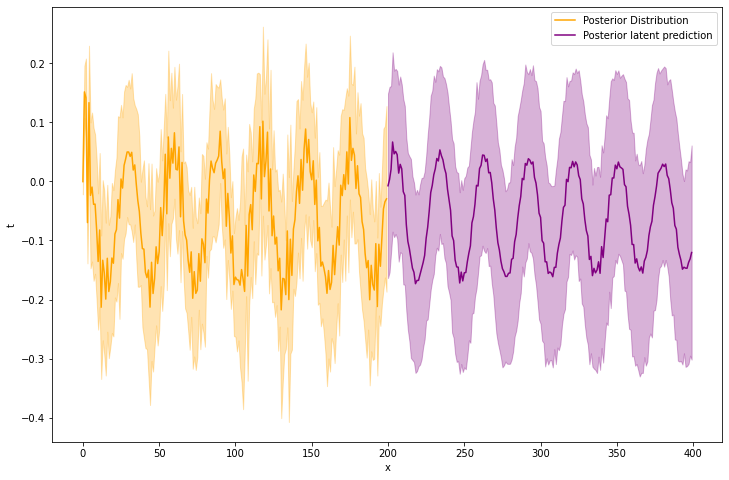

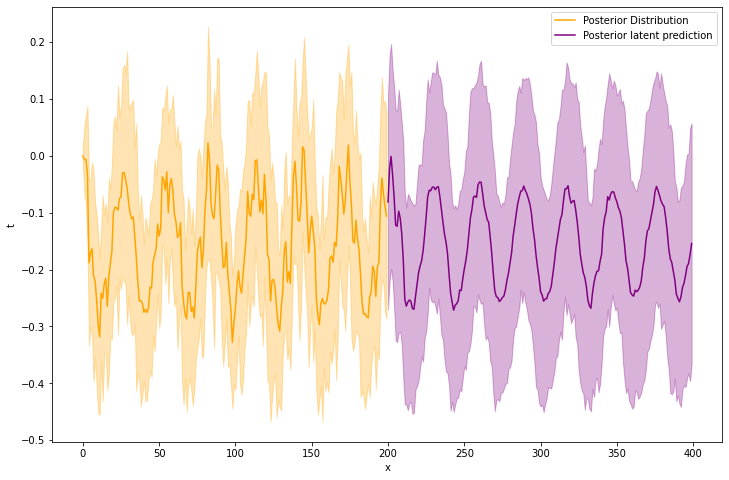

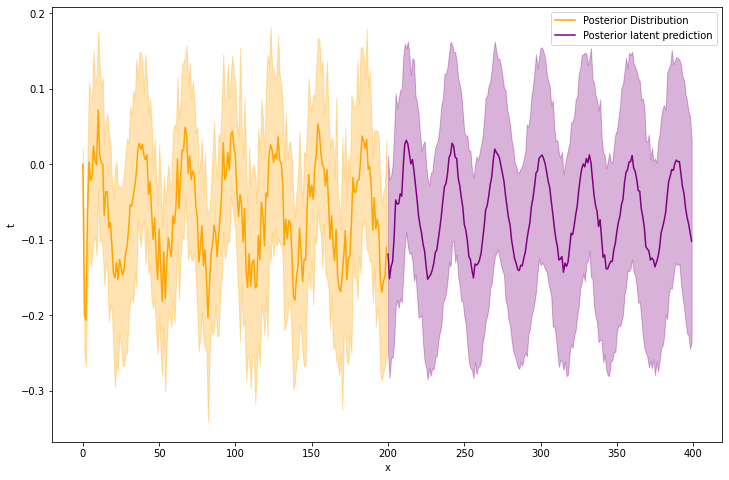

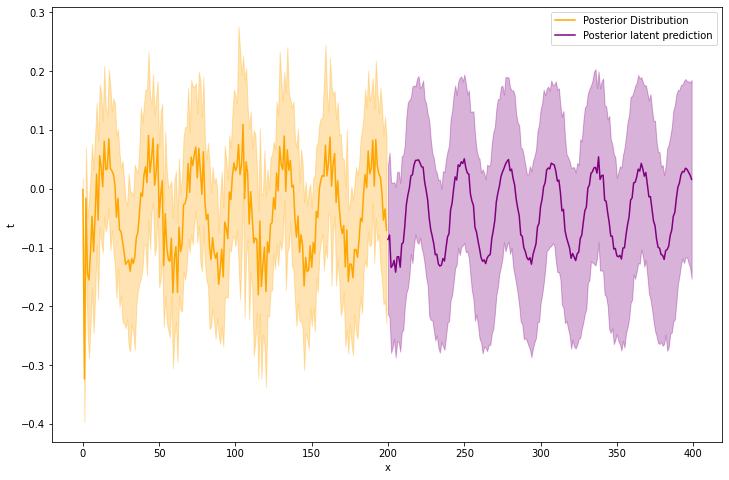

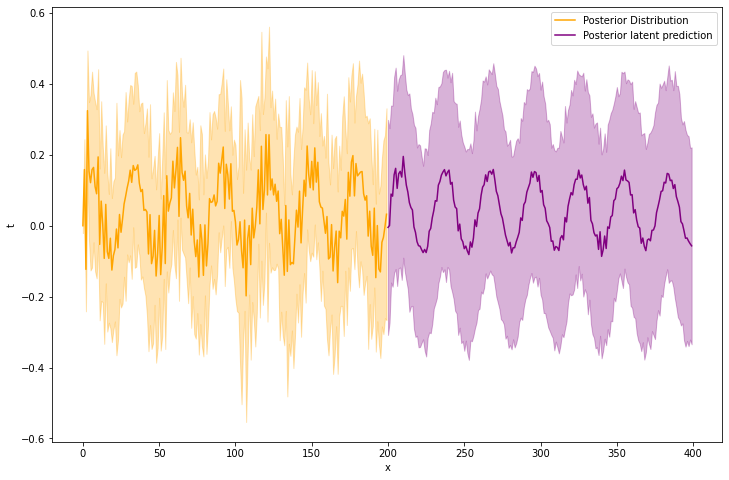

In [0]:
#Inference results
for m in range(0,num_obs):
  print('obs={}'.format(m))
  for i in range(0,d):
    xsample_mean = np.mean(x_samples, axis=0)[m,:,i,0]
    xsample_std = np.std(x_samples,axis=0)[m,:,i,0]


    plot_inf(x_obs[m,:,i,0], T,T_train,  xsample_mean, xsample_std, sigma, d, tanh_numparts, tanh_temp)
    plotx_pred(T,T_train,xpreds_mean[m,:,i], xpreds_std[m,:,i], xpostpreds_mean[m,:,i], xpostpreds_std[m,:,i], sigma, d, tanh_numparts, tanh_temp)

obs=0


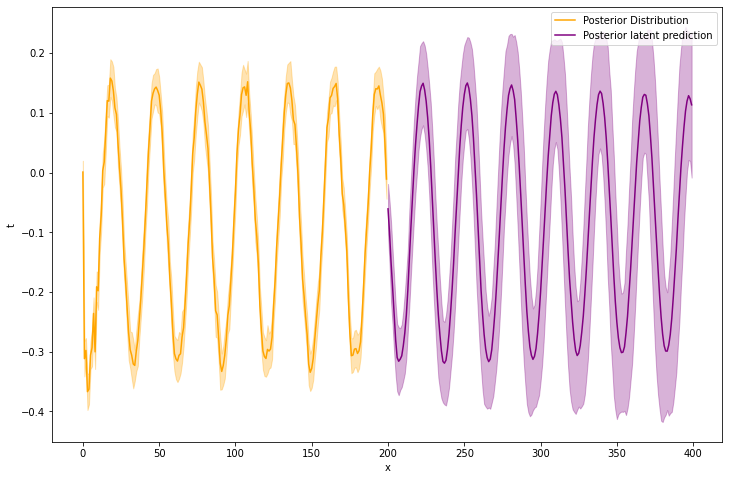

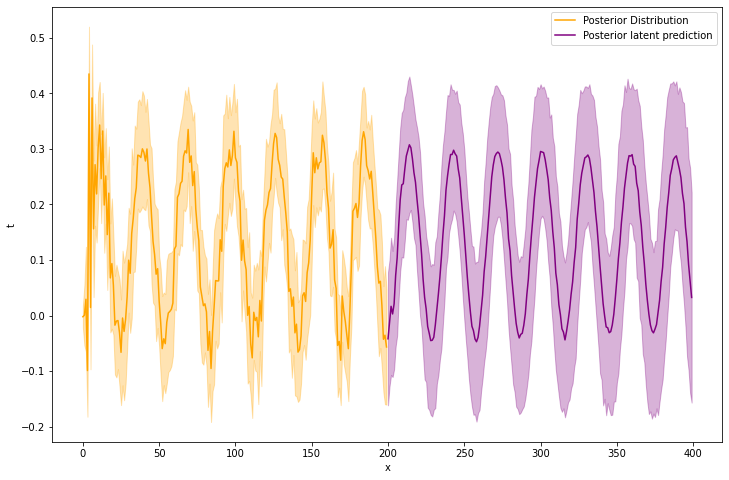

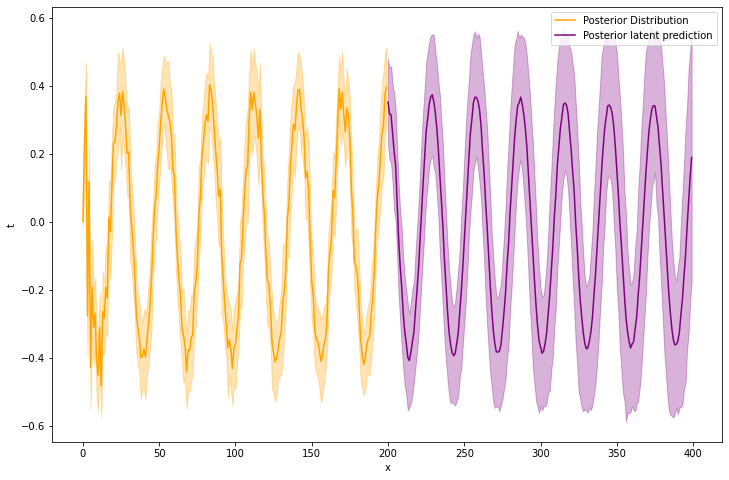

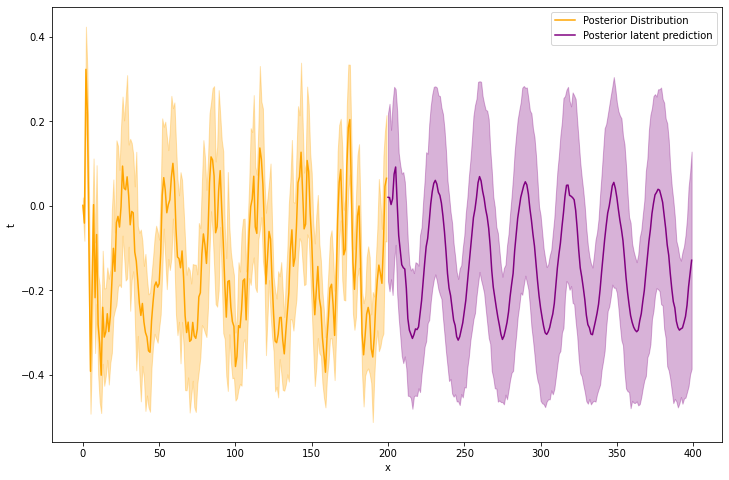

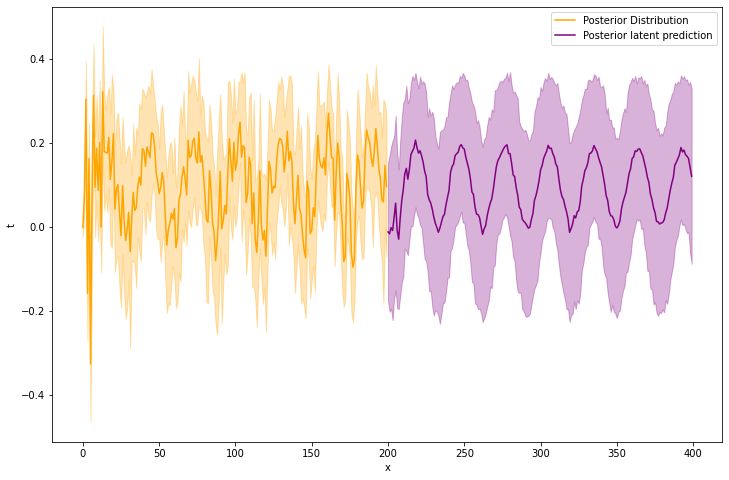

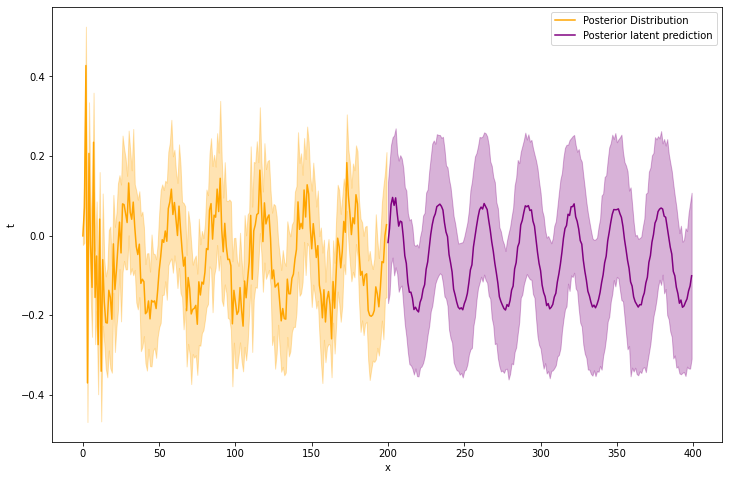

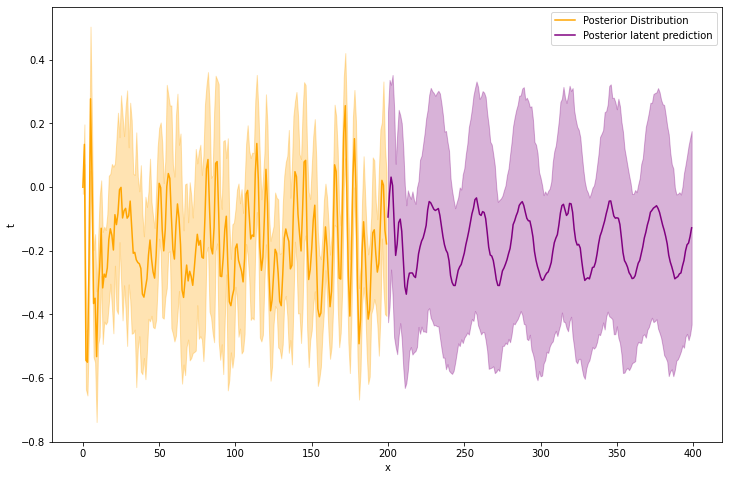

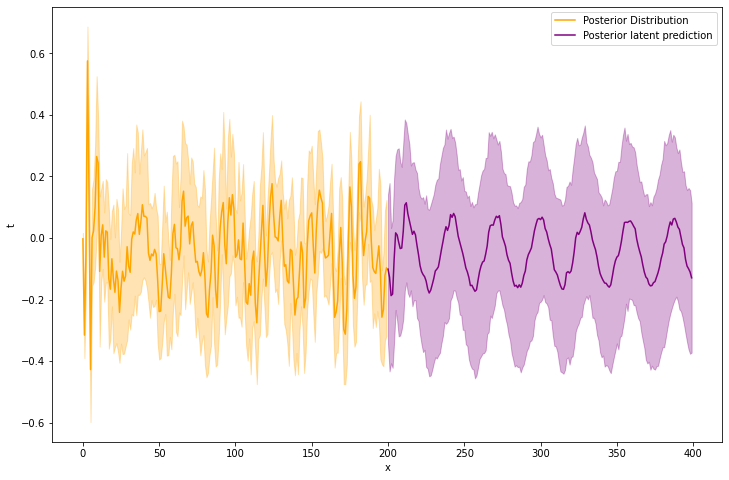

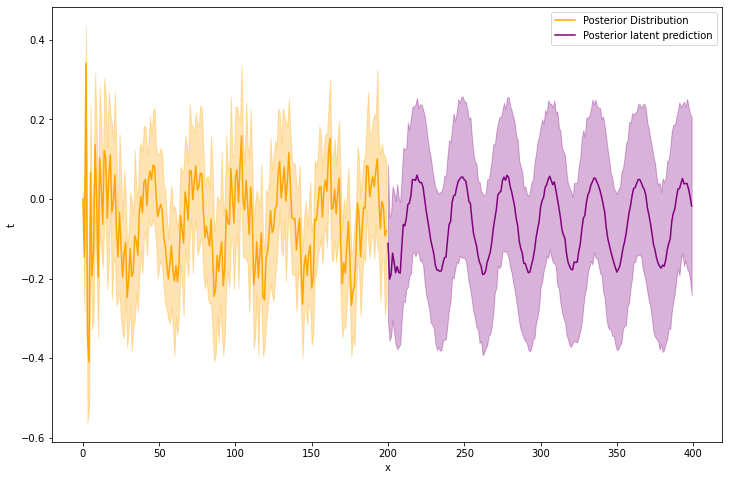

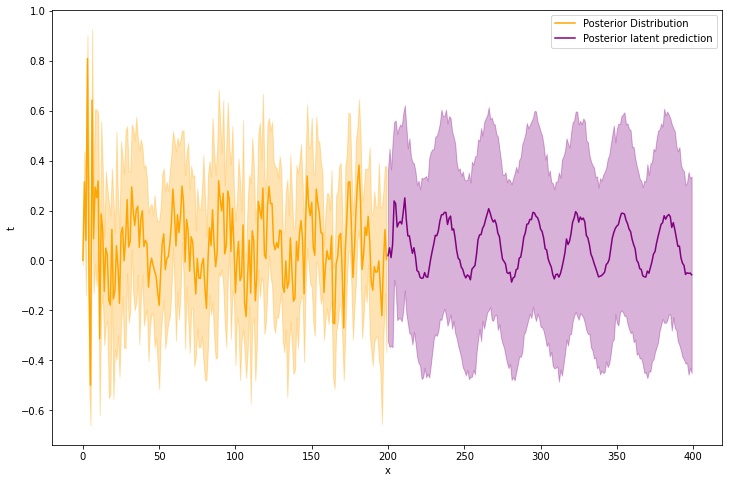

In [0]:
#Inference results
for m in range(0,num_obs):
  print('obs={}'.format(m))
  for i in range(0,d):
    xsample_mean = np.mean(x_samples, axis=0)[m,:,i,0]
    xsample_std = np.std(x_samples,axis=0)[m,:,i,0]


    plot_inf(x_obs[m,:,i,0], T,T_train,  xsample_mean, xsample_std, sigma, d, tanh_numparts, tanh_temp)
    plotx_pred(T,T_train,xpreds_mean[m,:,i], xpreds_std[m,:,i], xpostpreds_mean[m,:,i], xpostpreds_std[m,:,i], sigma, d, tanh_numparts, tanh_temp)

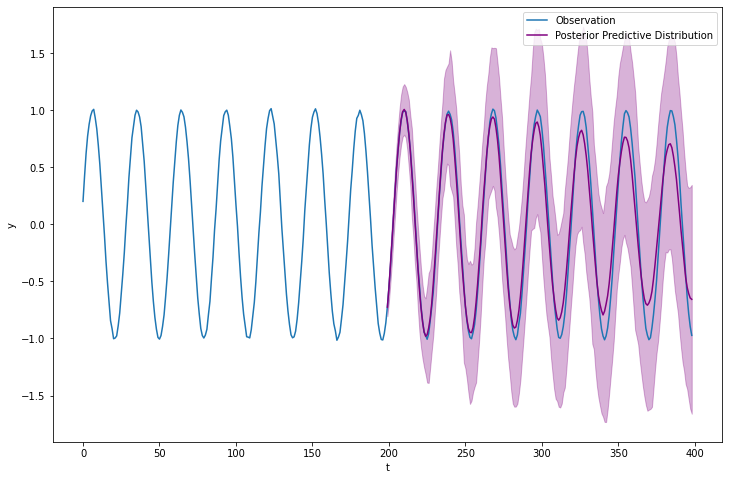

In [0]:
#prediction results
for m in range(0,num_obs):
  for i in range(0,yd):
    plot_y_preds(y[m],T-1,T_train, ypreds_mean[m,:,i], ypreds_std[m,:,i], ytrue_mean[m,:,i], ytrue_std[m,:,i],ypreds_test_mean[m,:,i], ypreds_test_std[m,:,i],Wbar_prior, Wbar_sigma, sigma, mstep_iters, tanh_numparts, tanh_temp)
    #plt.plot(ypreds2_mean[:,i][:T_train], color='black', label='gen y mean using W samples')
    #plt.fill_between(np.arange(0,T_train-1), 
    #                ypreds2_mean[:,i][:T_train] - 2 * ypreds2_std[:,i][:T_train], 
    #                ypreds2_mean[:,i][:T_train] + 2 * ypreds2_std[:,i][:T_train],
    #                color='black',
    #                alpha=0.5)

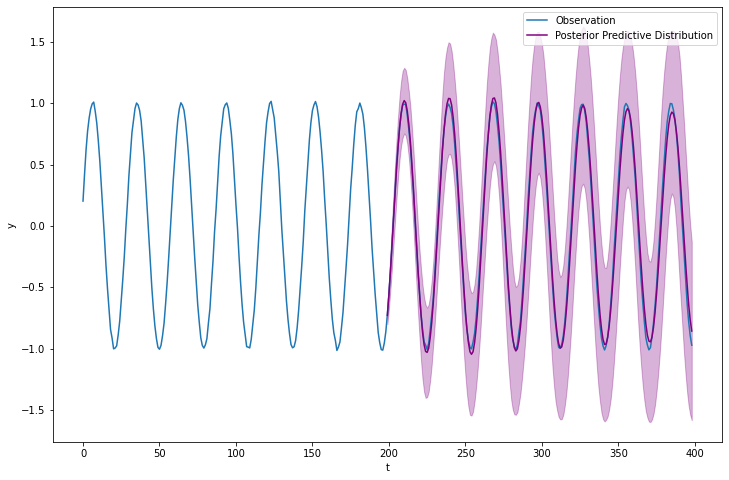

In [0]:
#prediction results
for m in range(0,num_obs):
  for i in range(0,yd):
    plot_y_preds(y[m],T-1,T_train, ypreds_mean[m,:,i], ypreds_std[m,:,i], ytrue_mean[m,:,i], ytrue_std[m,:,i],ypreds_test_mean[m,:,i], ypreds_test_std[m,:,i],Wbar_prior, Wbar_sigma, sigma, mstep_iters, tanh_numparts, tanh_temp)
    #plt.plot(ypreds2_mean[:,i][:T_train], color='black', label='gen y mean using W samples')
    #plt.fill_between(np.arange(0,T_train-1), 
    #                ypreds2_mean[:,i][:T_train] - 2 * ypreds2_std[:,i][:T_train], 
    #                ypreds2_mean[:,i][:T_train] + 2 * ypreds2_std[:,i][:T_train],
    #                color='black',
    #                alpha=0.5)

# Test Code

Gewecke Testing

Streaming output truncated to the last 5000 lines.
15003
15004
15005
15006
15007
15008
15009
15010
15011
15012
15013
15014
15015
15016
15017
15018
15019
15020
15021
15022
15023
15024
15025
15026
15027
15028
15029
15030
15031
15032
15033
15034
15035
15036
15037
15038
15039
15040
15041
15042
15043
15044
15045
15046
15047
15048
15049
15050
15051
15052
15053
15054
15055
15056
15057
15058
15059
15060
15061
15062
15063
15064
15065
15066
15067
15068
15069
15070
15071
15072
15073
15074
15075
15076
15077
15078
15079
15080
15081
15082
15083
15084
15085
15086
15087
15088
15089
15090
15091
15092
15093
15094
15095
15096
15097
15098
15099
15100
15101
15102
15103
15104
15105
15106
15107
15108
15109
15110
15111
15112
15113
15114
15115
15116
15117
15118
15119
15120
15121
15122
15123
15124
15125
15126
15127
15128
15129
15130
15131
15132
15133
15134
15135
15136
15137
15138
15139
15140
15141
15142
15143
15144
15145
15146
15147
15148
15149
15150
15151
15152
15153
15154
15155
15156
15157
15158
15159
15160
1

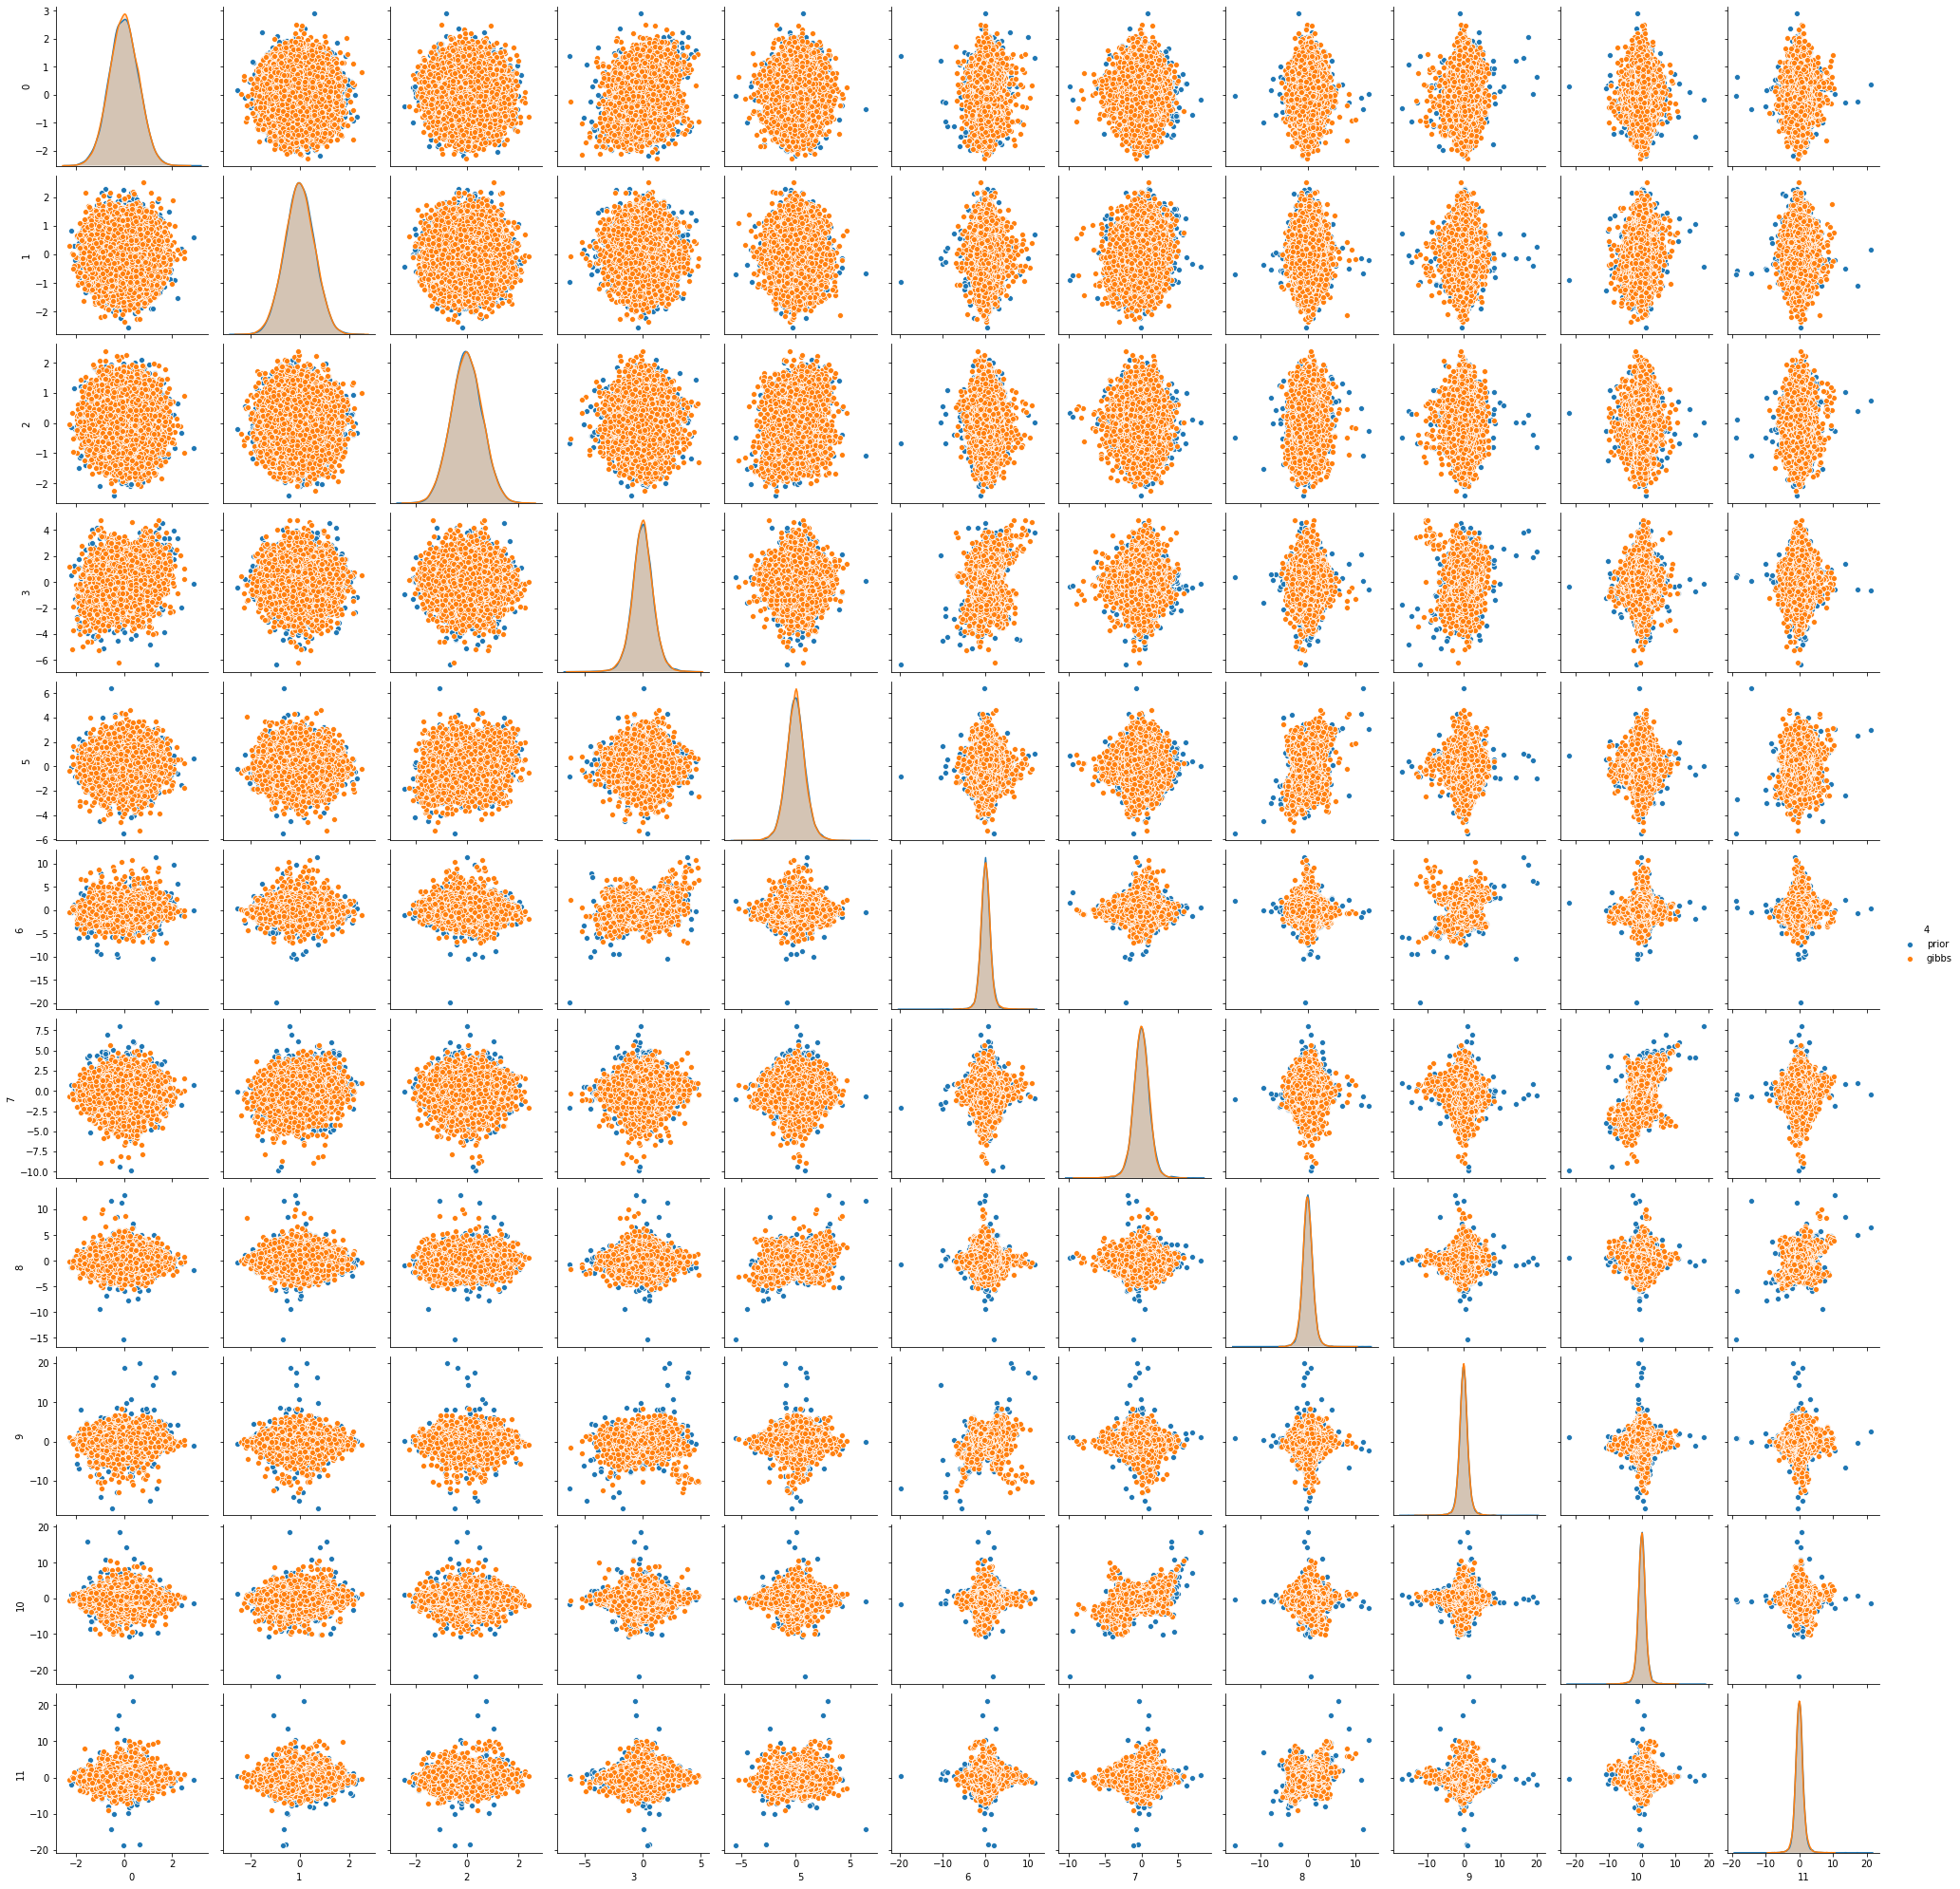

In [0]:
#Gewecke
burn_iters = 100000#800000
gewecke_iters=20000#200000
prior_iters= 10000#100000

# model = StochPiecewiseLinearVanillaRNN(*model_args, **model_kwargs)
# batch_ops=Batch_Ops_vanRNN(*batch_ops_args)

model = testStochPiecewiseLinearGRU(*model_args, **model_kwargs)
batch_ops=Batch_Ops_GRU(*batch_ops_args)


mb_size = num_obs
mb_ind = 0

batch_ops.get_batch(model,mb_size, mb_ind)

#burn in 
for i in range(burn_iters):
  model.gewecke_step()
  print(i)

#collect samples
x_samples = np.zeros((gewecke_iters,num_obs,T_train,d,1))
for i in range(gewecke_iters):
  model.gewecke_step()
  x_samples[i] = model.x
  print(i)

#sample from prior
x_preds = np.zeros((prior_iters,num_obs, T_train, d, 1))

if model_type == 'vanRNN':
  for n in range(prior_iters):
    x_preds[n,:,0] = mu_init+sigma_init*npr.randn(*mu_init.shape)
    Wbar = npr.normal(Wbar_prior, Wbar_sigma)
    Wbary = npr.normal(Wbary_prior, Wbary_sigma)

    sigma = np.sqrt(invgamma.rvs(alpha, scale=beta))
    model.sigmasq = sigma**2
    sigma_y = np.sqrt(invgamma.rvs(alphay, scale=betay))
    model.obs.sigmasq = sigma_y**2

    for t in range(1,T_train):
      x_preds[n,:,t],_=model.f(x_preds[n,:,t-1],u[:,t],Wbar,Wbary)


  Wbar_last = model.spwl_tanh.get_Wbar()
  Wbary_last = model.obs.get_Wbar()
  sigmasq_last = model.sigmasq
  sigmaysq_last = model.obs.sigmasq


if model_type == 'GRU':
  for n in range(prior_iters):
    x_preds[n,:,0] = mu_init+sigma_init*npr.randn(*mu_init.shape)
    Wbari = npr.normal(Wbari_prior, Wbari_sigma)
    Wbarr = npr.normal(Wbarr_prior, Wbarr_sigma)
    Wbarp = npr.normal(Wbarp_prior, Wbarp_sigma)
    Wbary = npr.normal(Wbary_prior, Wbary_sigma)

    sigma = np.sqrt(invgamma.rvs(alpha, scale=beta))
    model.sigmasq = sigma**2

    sigmai = np.sqrt(invgamma.rvs(alphai, scale=betai))
    model.sigmoid_i.sigmasq_out = sigmai**2

    sigmar = np.sqrt(invgamma.rvs(alphar, scale=betar))
    model.sigmoid_r.sigmasq_out = sigmar**2


    sigma_y = np.sqrt(invgamma.rvs(alphay, scale=betay))
    model.obs.sigmasq = sigma_y**2

    for t in range(1,T_train):
      x_preds[n,:,t],_=model.f(x_preds[n,:,t-1],u[:,t],Wbari,Wbarr,Wbarp,Wbary)



#Pairwise Plots of Gewecke x Results
# xsamples = x_samples[:,0,1:,:,0]
# print(xsamples.shape)
# xpreds = x_preds[:,0,1:,:,0]
xsamples = x_samples[:,0,:,:,0]
print(xsamples.shape)
xpreds = x_preds[:,0,:,:,0]
print(xpreds.shape)
xsamples = xsamples.reshape(-1, xsamples.shape[1]*xsamples.shape[2])
xpreds = xpreds.reshape(-1, xpreds.shape[1]*xpreds.shape[2])


# df = pd.DataFrame(xpreds[:,1:])
df = pd.DataFrame(xpreds[:,:])
col = ['prior']*prior_iters
# df[T-1]= col
df[T]= col

# df2 = pd.DataFrame(xsamples[:,1:])
df2 = pd.DataFrame(xsamples[:,:])
col = ['gibbs']*(gewecke_iters)
#df2[T-1] = col 
df2[T] = col 

df3 = df.append(df2)

# g = sns.pairplot(df3, hue=T-1, diag_kind='kde')
g = sns.pairplot(df3, hue=T, diag_kind='kde')

Vanilla RNN Unit Test

In [0]:
#Unit tests
#model = testStochPiecewiseLinearVanillaRNN(*model_args, **model_kwargs)
#batch_ops=Batch_Ops_vanRNN(*batch_ops_args)
# model = testStochPiecewiseLinearGRU(*model_args, **model_kwargs)
# batch_ops=Batch_Ops_GRU(*batch_ops_args)
# mb_size=num_obs
# mb_ind = 0
# batch_ops.get_batch(model,mb_size, mb_ind)


# for i in range(2):
#   ss_array = model.gibbs_Estep()
#   model.gibbs_Mstep(ss_array)


# ss_array = model.test_gibbs_Estep()
# model.test_Mstep(ss_array)

In [0]:
class testStochPiecewiseLinearVanillaRNN(StochPiecewiseLinearVanillaRNN):
    def test_gibbs_Estep(self):
      # 1. Sample discrete states and auxiliary variables given continuous states x and Wbar.
      inx = self.spwl_tanh.get_inx(self.x[:,:-1], self.u[:,1:])
      iny = self.x[:,1:]   
      yhat = self.spwl_tanh.f_given_z(inx, np.arange(self.spwl_tanh.num_parts))

      log_lkhd = -0.5 * (iny - yhat)**2 / self.sigmasq

      #Test zi updates
      self.spwl_tanh.z, self.spwl_tanh.ms, self.spwl_tanh.Vs = self.spwl_tanh.resample(inx,log_lkhd)
      log_cond1 = cond_z(self.spwl_tanh)
      log_joint1 = self.log_joint_nopgs(self.x,self.y,self.u,self.spwl_tanh.z)

      self.spwl_tanh.z, self.spwl_tanh.ms, self.spwl_tanh.Vs = self.spwl_tanh.resample(inx,log_lkhd)
      log_cond2 = cond_z(self.spwl_tanh)
      log_joint2 = self.log_joint_nopgs(self.x,self.y,self.u,self.spwl_tanh.z)

      print('zi')
      test_results(log_joint1,log_joint2,log_cond1,log_cond2, rtol=1e-10,atol=1e-10)

      #test x updates
      #first Convert mean and variance on Wx + Bu to natural parameters on x
      J_tildes = self.spwl_tanh.W.T @ ( self.spwl_tanh.W*1/self.spwl_tanh.Vs )
      h_tildes = ((self.spwl_tanh.W*1/self.spwl_tanh.Vs).transpose((0,1,3,2)) @ (self.spwl_tanh.ms- self.spwl_tanh.B @ self.u[:,1:]))[:,:,:,0]
      
      #Get recurrence natural parameters for x 
      J_ini, J_dyn_11, J_dyn_21, J_dyn_22, h_ini, h_dyn_1, h_dyn_2 = self.x_recurrence_params(self.spwl_tanh.slopes, self.spwl_tanh.intercepts,self.spwl_tanh.z, self.spwl_tanh.W, self.spwl_tanh.B,
                                                                                                        self.u[:,1:],self.sigmasq,self.mu_init, self.sigmasq_init)
      #Get observation natural parameters for x
      J_obs, h_obs = self.obs.x_params(self.y)
      
      #Combine parameters
      J_dyn_11 += J_tildes
      h_dyn_1 += h_tildes


      # log_Z_obs = np.zeros(h_obs.shape[1])
      
      # smoothed_mus = np.zeros(self.x.shape[0:3])
      # smoothed_Sigmas = np.zeros((self.x.shape[0], self.x.shape[1], self.x.shape[2], self.x.shape[2]))
      # off = np.zeros((self.x.shape[0], self.x.shape[1]-1, self.x.shape[2], self.x.shape[2]))

      # for i in range(self.x.shape[0]):
      #   _,smoothed_mus[i],smoothed_Sigmas[i],off[i] = messages.kalman_info_smoother(J_ini, h_ini[i], 0, J_dyn_11[i], J_dyn_21[i],     
      #                                   J_dyn_22, h_dyn_1[i], h_dyn_2[i], 0,           
      #                                   J_obs[i], h_obs[i], log_Z_obs) 
      

      # print('smoothed mus')
      # print(smoothed_mus.shape)
      # print(smoothed_mus)
      # print('smoothed sigmas')
      # print(smoothed_Sigmas.shape)
      # print(smoothed_Sigmas)


      #Construct largeT*dxT*d matrix
      J_test, h_test = big_Matrix(self.x,J_ini,J_dyn_11,J_dyn_21,J_dyn_22,h_ini,h_dyn_1,h_dyn_2,J_obs, h_obs)

      V = np.linalg.inv(J_test)
      m = V @ h_test[...,None]

      # m = m.reshape(self.x.shape)
      # print(m.shape)
      # print(m)
      # print(V.shape)
      # print(V)

      # sys.exit()
      L = np.linalg.cholesky(V)
      
      
      x = m + L @ npr.randn(*m.shape)
      log_cond1 = 0
      for i in range(self.x.shape[0]):
        log_cond1 += MVN.logpdf(x[i,:,0], m[i,:,0], V[i])
      self.x = x.reshape(self.x.shape)
      log_joint1,inx = self.log_joint_base(self.x,self.y,self.u,self.spwl_tanh.z)
      log_joint1 += np.sum(norm.logpdf(inx, self.spwl_tanh.ms, np.sqrt(self.spwl_tanh.Vs)))

      x = m + L @ npr.randn(*m.shape)
      log_cond2 = 0
      for i in range(self.x.shape[0]):
        log_cond2 += MVN.logpdf(x[i,:,0], m[i,:,0], V[i])
      self.x = x.reshape(self.x.shape)
      log_joint2,inx = self.log_joint_base(self.x,self.y,self.u,self.spwl_tanh.z)
      log_joint2 += np.sum(norm.logpdf(inx, self.spwl_tanh.ms, np.sqrt(self.spwl_tanh.Vs)))

      print('x')
      test_results(log_joint1,log_joint2,log_cond1,log_cond2, rtol=1e-10,atol=1e-10)
      return self.suff_stats()
  
    def test_Mstep(self,ss_array):
      Er,Erxd,Exd,Exdsq,ErrT,Eomega,Ekappa,Eslopes_sq,Eslopes,Eslopesints,Eints, Eints_sq,Ery,EryryT=ss_array
      #tanh weights
      J ,h  =self.spwl_tanh.Wbar_params(Er, Erxd, ErrT, Eomega, 
                                                  Ekappa, Eslopes_sq,Eslopes, 
                                                  Eslopesints,self.sigmasq)
      V,m,L = self.sample_Wbar_update(J,h,self.spwl_tanh)
      
      Wbar = (m + L @ npr.randn(*m.shape))[:,:,0]
      self.spwl_tanh.split_Wbar(Wbar)
      log_cond1 = 0
      for j in range(0,Wbar.shape[0]):
        log_cond1 += MVN.logpdf(Wbar[j],m[j,:,0],V[j])
      log_joint1,inx = self.log_joint_base(self.x,self.y,self.u,self.spwl_tanh.z)
      log_joint1 += np.sum(norm.logpdf(inx, self.spwl_tanh.ms, np.sqrt(self.spwl_tanh.Vs))) 
      log_joint1 += np.sum(norm.logpdf(Wbar, self.spwl_tanh.Wbar_prior, np.sqrt(self.spwl_tanh.Wbar_sigmasq)))

      Wbar = (m + L @ npr.randn(*m.shape))[:,:,0]
      self.spwl_tanh.split_Wbar(Wbar)
      log_cond2 = 0
      for j in range(0,Wbar.shape[0]):
        log_cond2 += MVN.logpdf(Wbar[j],m[j,:,0],V[j])
      log_joint2,inx = self.log_joint_base(self.x,self.y,self.u,self.spwl_tanh.z)
      log_joint2 += np.sum(norm.logpdf(inx, self.spwl_tanh.ms, np.sqrt(self.spwl_tanh.Vs))) 
      log_joint2 += np.sum(norm.logpdf(Wbar, self.spwl_tanh.Wbar_prior, np.sqrt(self.spwl_tanh.Wbar_sigmasq)))

      print('Wbar')
      test_results(log_joint1,log_joint2,log_cond1,log_cond2, rtol=1e-10,atol=1e-10)


      #update tanh variance
      alpha, beta = self.spwl_tanh.sigma_params(Exd,Exdsq,Er, ErrT, Eslopes_sq,Eslopes, 
                                                  Eslopesints,Eints, Eints_sq,Erxd)
      self.sigmasq = invgamma.rvs(alpha, scale=beta, size=self.sigmasq.shape)
      log_cond1 = np.sum(invgamma.logpdf(self.sigmasq, alpha, scale=beta))
      log_joint1 = self.log_joint_nopgs_with_weights(self.x,self.y,self.u,self.spwl_tanh.z)

      self.sigmasq = invgamma.rvs(alpha, scale=beta,size=self.sigmasq.shape)
      log_cond2 = np.sum(invgamma.logpdf(self.sigmasq, alpha, scale=beta))
      log_joint2 = self.log_joint_nopgs_with_weights(self.x,self.y,self.u,self.spwl_tanh.z)
      print('sigma')
      test_results(log_joint1,log_joint2,log_cond1,log_cond2, rtol=1e-10,atol=1e-10)

      #Update observation weights
      J, h = self.obs.Wbar_params(self.y,Ery,EryryT)
      V,m,L = self.sample_Wbar_update(J,h,self.obs)

      Wbar = (m + L @ npr.randn(*m.shape))[:,:,0]
      self.obs.split_Wbar(Wbar)
      log_cond1 = 0
      for j in range(0,Wbar.shape[0]):
        log_cond1 += MVN.logpdf(Wbar[j],m[j,:,0],V[j])
      log_joint1,inx = self.log_joint_base(self.x,self.y,self.u,self.spwl_tanh.z)
      log_joint1 += np.sum(norm.logpdf(Wbar, self.obs.Wbar_prior, np.sqrt(self.obs.Wbar_sigmasq)))

      Wbar = (m + L @ npr.randn(*m.shape))[:,:,0]
      self.obs.split_Wbar(Wbar)
      log_cond2 = 0
      for j in range(0,Wbar.shape[0]):
        log_cond2 += MVN.logpdf(Wbar[j],m[j,:,0],V[j])
      log_joint2,inx = self.log_joint_base(self.x,self.y,self.u,self.spwl_tanh.z)
      log_joint2 += np.sum(norm.logpdf(Wbar, self.obs.Wbar_prior, np.sqrt(self.obs.Wbar_sigmasq)))
      
      print('Wbar_y')
      test_results(log_joint1,log_joint2,log_cond1,log_cond2, rtol=1e-10,atol=1e-10)

      #Update observation variances
      alpha, beta = self.obs.sigma_params(self.y, Ery, EryryT)

      self.obs.sigmasq = invgamma.rvs(alpha, scale=beta, size=self.obs.sigmasq.shape)
      log_cond1 = np.sum(invgamma.logpdf(self.obs.sigmasq, alpha, scale=beta))
      log_joint1 = self.log_joint_nopgs_with_weights(self.x,self.y,self.u,self.spwl_tanh.z)

      self.obs.sigmasq = invgamma.rvs(alpha, scale=beta, size=self.obs.sigmasq.shape)
      log_cond2 = np.sum(invgamma.logpdf(self.obs.sigmasq, alpha, scale=beta))
      log_joint2 = self.log_joint_nopgs_with_weights(self.x,self.y,self.u,self.spwl_tanh.z)
      print('sigma_y')
      test_results(log_joint1,log_joint2,log_cond1,log_cond2, rtol=1e-10,atol=1e-10)



# model = testStochPiecewiseLinearVanillaRNN(*model_args, **model_kwargs)
# batch_ops=Batch_Ops_vanRNN(*batch_ops_args)
# mb_size=num_obs
# mb_ind = 0
# batch_ops.get_batch(model,mb_size, mb_ind)


# for i in range(2):
#   ss_array = model.gibbs_Estep()
#   model.gibbs_Mstep(ss_array)


# ss_array = model.test_gibbs_Estep()
# model.test_Mstep(ss_array)

GRU Unit Tests

In [0]:
class testStochPiecewiseLinearGRU(StochPiecewiseLinearGRU):
    def test_gibbs_Estep(self):
      # 1. Sample discrete states and auxiliary variables given continuous states x and Wbar.
      inx_i = self.sigmoid_i.get_inx(self.x[:,:-1], self.u[:,1:])
      inx_r = self.sigmoid_r.get_inx(self.x[:,:-1], self.u[:,1:])
      iny = self.x[:,1:]

      #Test zi updates
      self.z_ir_update(inx_i,self.sigmoid_i)
      log_cond1 = cond_z(self.sigmoid_i)
      log_joint1 = self.log_joint_nopgs(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)

      self.z_ir_update(inx_i,self.sigmoid_i)
      log_cond2 = cond_z(self.sigmoid_i)
      log_joint2 = self.log_joint_nopgs(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)

      print('zi')
      test_results(log_joint1,log_joint2,log_cond1,log_cond2, rtol=1e-10,atol=1e-10)

      #Test zr updates
      self.z_ir_update(inx_r,self.sigmoid_r)
      log_cond1 = cond_z(self.sigmoid_r)
      log_joint1 = self.log_joint_nopgs(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)

      self.z_ir_update(inx_r,self.sigmoid_r)
      log_cond2 = cond_z(self.sigmoid_r)
      log_joint2 = self.log_joint_nopgs(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)

      print('zr')
      test_results(log_joint1,log_joint2,log_cond1,log_cond2, rtol=1e-10,atol=1e-10)


      #Test zp_update
      self.zp_update(self.sigmoid_i.output,self.sigmoid_r.output, iny)
      log_cond1 = cond_z(self.tanh)
      log_joint1 = self.log_joint_nopgs(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)

      self.zp_update(self.sigmoid_i.output,self.sigmoid_r.output, iny)
      log_cond2 = cond_z(self.tanh)
      log_joint2 = self.log_joint_nopgs(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)

      print('zp')
      test_results(log_joint1,log_joint2,log_cond1,log_cond2, rtol=1e-10,atol=1e-10)


      ###first Convert mean and variance on Wx + Bu to natural parameters on x
      J_pg_i, h_pg_i = self.x_pg_params(self.sigmoid_i)  
      J_pg_r, h_pg_r = self.x_pg_params(self.sigmoid_r) 
      ####Convert mean and variance on W_p[r\odotx]+Bpu to natural parameters on rx
      J_pg_p, h_pg_p = self.x_pg_params(self.tanh)
      # ####Convert natural parameters on rx to natural parameters on r
      J_pg_p_r = (J_pg_p*self.x[:,:-1])*self.x[:,:-1].transpose(0,1,3,2)  #Jnew = xxT \odot Jold
      h_pg_p_r = (h_pg_p*self.x[:,:-1])[:,:,:,0]
 
      #Test i update
      V,m = self.update_i(inx_i, iny)
      self.sigmoid_i.output = m + np.sqrt(V)*npr.randn(*m.shape)
      log_cond1 = np.sum(norm.logpdf(self.sigmoid_i.output, m, np.sqrt(V)))
      log_joint1 = self.log_joint_nopgs(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)
      
      self.sigmoid_i.output = m + np.sqrt(V)*npr.randn(*m.shape)
      log_cond2 = np.sum(norm.logpdf(self.sigmoid_i.output, m, np.sqrt(V)))
      log_joint2 = self.log_joint_nopgs(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)
      

      print('i')
      test_results(log_joint1,log_joint2,log_cond1,log_cond2, rtol=1e-10,atol=1e-10)

      #test r update
      V,m = self.update_r(inx_r, iny, J_pg_p_r, h_pg_p_r)
      L = np.linalg.cholesky(V)
      self.sigmoid_r.output = m + L @ npr.randn(*m.shape)
      log_cond1 = 0
      for i in range(0,m.shape[0]):
        for j in range(0,m.shape[1]):
          log_cond1 += MVN.logpdf(self.sigmoid_r.output[i,j,:,0],m[i,j,:,0],V[i,j])
      log_joint1,_,_,inx_p = self.log_joint_base(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)
      log_joint1 += np.sum(norm.logpdf(inx_p, self.tanh.ms, np.sqrt(self.tanh.Vs)))
      
      self.sigmoid_r.output = m + L @ npr.randn(*m.shape)
      log_cond2 = 0
      for i in range(0,m.shape[0]):
        for j in range(0,m.shape[1]):
          log_cond2 += MVN.logpdf(self.sigmoid_r.output[i,j,:,0],m[i,j,:,0],V[i,j])
      log_joint2,_,_,inx_p = self.log_joint_base(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)
      log_joint2 += np.sum(norm.logpdf(inx_p, self.tanh.ms, np.sqrt(self.tanh.Vs)))

      print('r')
      test_results(log_joint1,log_joint2,log_cond1,log_cond2, rtol=1e-10,atol=1e-10)

   
      ####Convert natural parameters on rx to natural parameters on x
      J_pg_p_x = (J_pg_p*self.sigmoid_r.output)*self.sigmoid_r.output.transpose(0,1,3,2)  #Jnew = rrT \odot Jold
      h_pg_p_x = (h_pg_p*self.sigmoid_r.output)[:,:,:,0]


      #Get recurrence natural parameters for x 
      J_ini,J_dyn_11,J_dyn_21,J_dyn_22,h_ini,h_dyn_1,h_dyn_2=self.x_recurrence_params(self.sigmoid_i.output,self.sigmoid_r.output,self.tanh.slopes, 
                                                                                      self.tanh.intercepts,self.tanh.z, 
                                                                                      self.tanh.W, self.tanh.B,
                                                                                    self.u[:,1:],self.sigmasq,self.mu_init, self.sigmasq_init)
 
      #Get parameters from continous i and r states
      J_i, h_i = self.x_ir_params(self.sigmoid_i.slopes, self.sigmoid_i.intercepts, 
                                  self.sigmoid_i.sigmasq_out, self.sigmoid_i.output,self.sigmoid_i.z, 
                                  self.sigmoid_i.W, self.sigmoid_i.B, self.u[:,1:])
      
      J_r, h_r = self.x_ir_params(self.sigmoid_r.slopes, self.sigmoid_r.intercepts, 
                                  self.sigmoid_r.sigmasq_out, self.sigmoid_r.output,self.sigmoid_r.z, 
                                  self.sigmoid_r.W, self.sigmoid_r.B, self.u[:,1:])
      
      #Get observation natural parameters for x
      J_obs, h_obs = self.obs.x_params(self.y)

      #Combine parameters
      J_dyn_11 += J_i+J_r+J_pg_i+J_pg_r+J_pg_p_x 
      h_dyn_1 += h_i+h_r+h_pg_i[:,:,:,0]+h_pg_r[:,:,:,0]+h_pg_p_x

      J_test, h_test = big_Matrix(self.x,J_ini,J_dyn_11,J_dyn_21,J_dyn_22,h_ini,h_dyn_1,h_dyn_2,J_obs, h_obs)

      V = np.linalg.inv(J_test)
      m = V @ h_test[...,None]
      L = np.linalg.cholesky(V)
      
      x = m + L @ npr.randn(*m.shape)
      log_cond1 = 0
      for i in range(self.x.shape[0]):
        log_cond1 += MVN.logpdf(x[i,:,0], m[i,:,0], V[i])
      self.x = x.reshape(self.x.shape)
      log_joint1,inx_i,inx_r,inx_p = self.log_joint_base(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)
      log_joint1 += np.sum(norm.logpdf(inx_p, self.tanh.ms, np.sqrt(self.tanh.Vs)))
      log_joint1 += np.sum(norm.logpdf(inx_i, self.sigmoid_i.ms, np.sqrt(self.sigmoid_i.Vs))) 
      log_joint1 += np.sum(norm.logpdf(inx_r, self.sigmoid_r.ms, np.sqrt(self.sigmoid_r.Vs))) 

      x = m + L @ npr.randn(*m.shape)
      log_cond2 = 0
      for i in range(self.x.shape[0]):
        log_cond2 += MVN.logpdf(x[i,:,0], m[i,:,0], V[i])
      self.x = x.reshape(self.x.shape)
      log_joint2,inx_i,inx_r,inx_p = self.log_joint_base(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)
      log_joint2 += np.sum(norm.logpdf(inx_p, self.tanh.ms, np.sqrt(self.tanh.Vs)))
      log_joint2 += np.sum(norm.logpdf(inx_i, self.sigmoid_i.ms, np.sqrt(self.sigmoid_i.Vs))) 
      log_joint2 += np.sum(norm.logpdf(inx_r, self.sigmoid_r.ms, np.sqrt(self.sigmoid_r.Vs))) 

      print('x')
      test_results(log_joint1,log_joint2,log_cond1,log_cond2, rtol=1e-10,atol=1e-10)

      return self.suff_stats()

    def test_Mstep(self,ss_array):
      #self.suff_stats_vec = (1-self.rho)*self.suff_stats_vec+self.rho*ss_array
      Eh,EhhT,Ehxd,Exd,Exdsq,Exdmin,Exdminsq,Exdxdmin,Eomega_i,Ekappa_i,Eslopes_sq_i,Eslopes_i,Eslopesints_i,Eints_i, Eints_sq_i,Ei,Eisq,\
      Eomega_r,Ekappa_r,Eslopes_sq_r,Eslopes_r,Eslopesints_r,Eints_r, Eints_sq_r,Er,Ersq,\
      Ehp,EhphpT,Ehpxd,Ehpxdmin,Eomega_p,Ekappa_p,Eslopes_sq_p,\
      Eslopes_p,Eslopesints_p,Eints_p, Eints_sq_p,Ehy,EhyhyT=ss_array
      
      #Update Wbar_i weights  
      J,h=self.sigmoid_i.Wbar_params(Eh,EhhT,Eomega_i,Ekappa_i,Eslopes_sq_i,Eslopes_i, 
                                                Eslopesints_i,self.sigmoid_i.sigmasq_out, Eoutput=Ei)
      
      V,m,L = self.sample_Wbar_update(J,h,self.sigmoid_i)
      Wbar = (m + L @ npr.randn(*m.shape))[:,:,0]
      self.sigmoid_i.split_Wbar(Wbar)
      log_cond1 = 0
      for j in range(0,Wbar.shape[0]):
        log_cond1 += MVN.logpdf(Wbar[j],m[j,:,0],V[j])
      log_joint1,inx_i,inx_r,inx_p = self.log_joint_base(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)
      log_joint1 += np.sum(norm.logpdf(inx_i, self.sigmoid_i.ms, np.sqrt(self.sigmoid_i.Vs))) 
      log_joint1 += np.sum(norm.logpdf(Wbar, self.sigmoid_i.Wbar_prior, np.sqrt(self.sigmoid_i.Wbar_sigmasq)))


      Wbar = (m + L @ npr.randn(*m.shape))[:,:,0]
      self.sigmoid_i.split_Wbar(Wbar)
      log_cond2 = 0
      for j in range(0,Wbar.shape[0]):
        log_cond2 += MVN.logpdf(Wbar[j],m[j,:,0],V[j])
      log_joint2,inx_i,inx_r,inx_p = self.log_joint_base(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)
      log_joint2 += np.sum(norm.logpdf(inx_i, self.sigmoid_i.ms, np.sqrt(self.sigmoid_i.Vs))) 
      log_joint2 += np.sum(norm.logpdf(Wbar, self.sigmoid_i.Wbar_prior, np.sqrt(self.sigmoid_i.Wbar_sigmasq)))

      print('Wbar_i')
      test_results(log_joint1,log_joint2,log_cond1,log_cond2, rtol=1e-10,atol=1e-10)


      #update i variance
      alpha, beta,_ = self.sigmoid_i.sigma_params(Ei,Eisq,Eh, EhhT, Eslopes_sq_i,Eslopes_i, 
                                                  Eslopesints_i,Eints_i, Eints_sq_i)
      self.sigmoid_i.sigmasq_out = invgamma.rvs(alpha, scale=beta,size=self.sigmoid_i.sigmasq_out.shape)
      log_cond1 = np.sum(invgamma.logpdf(self.sigmoid_i.sigmasq_out, alpha, scale=beta))
      log_joint1 = self.log_joint_nopgs_with_weights(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)

      self.sigmoid_i.sigmasq_out = invgamma.rvs(alpha, scale=beta,size=self.sigmoid_i.sigmasq_out.shape)
      log_cond2 = np.sum(invgamma.logpdf(self.sigmoid_i.sigmasq_out, alpha, scale=beta))
      log_joint2 = self.log_joint_nopgs_with_weights(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)
      print('sigma_i')
      test_results(log_joint1,log_joint2,log_cond1,log_cond2, rtol=1e-10,atol=1e-10)

      #Update Wbar_r weights  
      J,h=self.sigmoid_r.Wbar_params(Eh,EhhT,Eomega_r,Ekappa_r,Eslopes_sq_r,Eslopes_r, 
                                                Eslopesints_r,self.sigmoid_r.sigmasq_out, Eoutput=Er)
      
      V,m,L = self.sample_Wbar_update(J,h,self.sigmoid_r)
      Wbar = (m + L @ npr.randn(*m.shape))[:,:,0]
      self.sigmoid_r.split_Wbar(Wbar)
      log_cond1 = 0
      for j in range(0,Wbar.shape[0]):
        log_cond1 += MVN.logpdf(Wbar[j],m[j,:,0],V[j])
      log_joint1,inx_i,inx_r,inx_p = self.log_joint_base(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)
      log_joint1 += np.sum(norm.logpdf(inx_r, self.sigmoid_r.ms, np.sqrt(self.sigmoid_r.Vs))) 
      log_joint1 += np.sum(norm.logpdf(Wbar, self.sigmoid_r.Wbar_prior, np.sqrt(self.sigmoid_r.Wbar_sigmasq)))

      Wbar = (m + L @ npr.randn(*m.shape))[:,:,0]
      self.sigmoid_r.split_Wbar(Wbar)
      log_cond2 = 0
      for j in range(0,Wbar.shape[0]):
        log_cond2 += MVN.logpdf(Wbar[j],m[j,:,0],V[j])
      log_joint2,inx_i,inx_r,inx_p = self.log_joint_base(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)
      log_joint2 += np.sum(norm.logpdf(inx_r, self.sigmoid_r.ms, np.sqrt(self.sigmoid_r.Vs))) 
      log_joint2 += np.sum(norm.logpdf(Wbar, self.sigmoid_r.Wbar_prior, np.sqrt(self.sigmoid_r.Wbar_sigmasq)))

      print('Wbar_r')
      test_results(log_joint1,log_joint2,log_cond1,log_cond2, rtol=1e-10,atol=1e-10)


      #update r variance
      alpha, beta,_ = self.sigmoid_r.sigma_params(Er,Ersq,Eh, EhhT, Eslopes_sq_r,Eslopes_r, 
                                                  Eslopesints_r,Eints_r, Eints_sq_r)
      
      self.sigmoid_r.sigmasq_out = invgamma.rvs(alpha, scale=beta,size=self.sigmoid_r.sigmasq_out.shape)
      log_cond1 = np.sum(invgamma.logpdf(self.sigmoid_r.sigmasq_out, alpha, scale=beta))
      log_joint1 = self.log_joint_nopgs_with_weights(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)
      
      self.sigmoid_r.sigmasq_out = invgamma.rvs(alpha, scale=beta,size=self.sigmoid_r.sigmasq_out.shape)
      log_cond2 = np.sum(invgamma.logpdf(self.sigmoid_r.sigmasq_out, alpha, scale=beta))
      log_joint2 = self.log_joint_nopgs_with_weights(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)

      print('sigma_r')
      test_results(log_joint1,log_joint2,log_cond1,log_cond2, rtol=1e-10,atol=1e-10)

      #Update Wbar_p weights:
      J,h=self.Wbar_p_params(Ehp,EhphpT,Ehpxd,Ehpxdmin,Eomega_p,Ekappa_p,Eslopes_sq_p,Eslopes_p, 
                                    Eslopesints_p,self.sigmasq, Ei, Eisq)

      V,m,L = self.sample_Wbar_update(J,h,self.tanh)
      Wbar = (m + L @ npr.randn(*m.shape))[:,:,0]
      self.tanh.split_Wbar(Wbar)
      log_cond1 = 0
      for j in range(0,Wbar.shape[0]):
        log_cond1 += MVN.logpdf(Wbar[j],m[j,:,0],V[j])
      log_joint1,inx_i,inx_r,inx_p = self.log_joint_base(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)
      log_joint1 += np.sum(norm.logpdf(inx_p, self.tanh.ms, np.sqrt(self.tanh.Vs)))
      log_joint1 += np.sum(norm.logpdf(Wbar, self.tanh.Wbar_prior, np.sqrt(self.tanh.Wbar_sigmasq)))

      V,m,L = self.sample_Wbar_update(J,h,self.tanh)
      Wbar = (m + L @ npr.randn(*m.shape))[:,:,0]
      self.tanh.split_Wbar(Wbar)
      log_cond2 = 0
      for j in range(0,Wbar.shape[0]):
        log_cond2 += MVN.logpdf(Wbar[j],m[j,:,0],V[j])
      log_joint2,inx_i,inx_r,inx_p = self.log_joint_base(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)
      log_joint2 += np.sum(norm.logpdf(inx_p, self.tanh.ms, np.sqrt(self.tanh.Vs)))
      log_joint2 += np.sum(norm.logpdf(Wbar, self.tanh.Wbar_prior, np.sqrt(self.tanh.Wbar_sigmasq)))

      print('Wbar_p')
      test_results(log_joint1,log_joint2,log_cond1,log_cond2, rtol=1e-10,atol=1e-10)

      #update x variance
      alpha, beta = self.sigma_params(Ehp,EhphpT,Ehpxd,Ehpxdmin,Exd,Exdsq,Exdmin,
                                      Exdminsq,Exdxdmin,Eslopes_sq_p,Eslopes_p, 
                                      Eslopesints_p,Eints_p, Eints_sq_p, Ei, Eisq)
      
      self.sigmasq = invgamma.rvs(alpha, scale=beta,size=self.sigmasq.shape)
      log_cond1 = np.sum(invgamma.logpdf(self.sigmasq, alpha, scale=beta))
      log_joint1 = self.log_joint_nopgs_with_weights(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)
      
      self.sigmasq = invgamma.rvs(alpha, scale=beta,size=self.sigmasq.shape)
      log_cond2 = np.sum(invgamma.logpdf(self.sigmasq, alpha, scale=beta))
      log_joint2 = self.log_joint_nopgs_with_weights(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)
      print('sigma_x')
      test_results(log_joint1,log_joint2,log_cond1,log_cond2, rtol=1e-10,atol=1e-10)

      #Update Wy weights
      J, h = self.obs.Wbar_params(self.y,Ehy,EhyhyT)
      V,m,L = self.sample_Wbar_update(J,h,self.obs)

      Wbar = (m + L @ npr.randn(*m.shape))[:,:,0]
      self.obs.split_Wbar(Wbar)
      log_cond1 = 0
      for j in range(0,Wbar.shape[0]):
        log_cond1 += MVN.logpdf(Wbar[j],m[j,:,0],V[j])
      # log_joint1,inx_i,inx_r,inx_p = self.log_joint_base(self.x,self.y,self.u,self.sigmoid_i.z,
      #                                   self.sigmoid_i.output,self.sigmoid_r.z,
      #                                   self.sigmoid_r.output,self.tanh.z)
      # log_joint1 += np.sum(norm.logpdf(Wbar, self.obs.Wbar_prior, np.sqrt(self.obs.Wbar_sigmasq)))
      log_joint1 = self.log_joint_nopgs_with_weights(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)

      Wbar = (m + L @ npr.randn(*m.shape))[:,:,0]
      self.obs.split_Wbar(Wbar)
      log_cond2 = 0
      for j in range(0,Wbar.shape[0]):
        log_cond2 += MVN.logpdf(Wbar[j],m[j,:,0],V[j])
      # log_joint2,inx_i,inx_r,inx_p = self.log_joint_base(self.x,self.y,self.u,self.sigmoid_i.z,
      #                                   self.sigmoid_i.output,self.sigmoid_r.z,
      #                                   self.sigmoid_r.output,self.tanh.z)
      # log_joint2 += np.sum(norm.logpdf(Wbar, self.obs.Wbar_prior, np.sqrt(self.obs.Wbar_sigmasq)))
      log_joint2 = self.log_joint_nopgs_with_weights(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)

      print('Wbar_y')
      test_results(log_joint1,log_joint2,log_cond1,log_cond2, rtol=1e-10,atol=1e-10)

      #Update observation variances
      alpha, beta = self.obs.sigma_params(self.y, Ehy, EhyhyT)

      self.obs.sigmasq = invgamma.rvs(alpha, scale=beta,size=self.obs.sigmasq.shape)
      log_cond1 = np.sum(invgamma.logpdf(self.obs.sigmasq, alpha, scale=beta))
      log_joint1 = self.log_joint_nopgs_with_weights(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)

      self.obs.sigmasq = invgamma.rvs(alpha, scale=beta,size=self.obs.sigmasq.shape)
      log_cond2 = np.sum(invgamma.logpdf(self.obs.sigmasq, alpha, scale=beta))
      log_joint2 = self.log_joint_nopgs_with_weights(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)
      print('sigma_y')
      test_results(log_joint1,log_joint2,log_cond1,log_cond2, rtol=1e-10,atol=1e-10)


# model = testStochPiecewiseLinearGRU(*model_args, **model_kwargs)
# batch_ops=Batch_Ops_GRU(*batch_ops_args)
# mb_size=num_obs
# mb_ind = 0
# batch_ops.get_batch(model,mb_size, mb_ind)


# for i in range(2):
#   ss_array = model.gibbs_Estep()
#   model.gibbs_Mstep(ss_array)


# ss_array = model.test_gibbs_Estep()
# model.test_Mstep(ss_array)


GRU Gewecke Testing

In [0]:
# #Gewecke
# burn_iters = 800000
# gewecke_iters=200000
# prior_iters= 100000

# GRU = StochPiecewiseLinearGRU(Wi,Bi,Wr,Br,Wp,Bp,mu_init,sigma_init,sigma, 
#                               C,by,sigma_y,sigma_i, sigma_r,tanh_numparts,tanh_window,tanh_temp,
#                               i_numparts,i_window,i_temp,
#                               r_numparts,r_window,r_temp,
#                               Wbar_i_prior=Wbari_prior,Wbar_i_sigma=Wbari_sigma,
#                               Wbar_r_prior=Wbarr_prior,Wbar_r_sigma=Wbarr_sigma,
#                               Wbar_p_prior=Wbarp_prior,Wbar_p_sigma=Wbarp_sigma,
#                               Wbar_y_prior=Wbary_prior,Wbar_y_sigma=Wbary_sigma)

# batch_ops=Batch_Ops_GRU(y[:,:T_train-1], x[:,:T_train], u[:,:T_train], zi_init,i_init,zr_init,r_init,zp_init, rhoexp)
# mb_ind = 0
# batch_ops.get_batch(GRU,mb_size, mb_ind)

# log_like = []
# #burn in 
# for i in range(burn_iters):
#   GRU.gewecke_step()
#   #log_like.append(GRU.log_joint_nopgs_with_weights(GRU.x, GRU.y, GRU.u, GRU.sigmoid_i.z,GRU.sigmoid_i.output, GRU.sigmoid_r.z,GRU.sigmoid_r.output,GRU.tanh.z))
#   print(i)

# #collect samples
# x_samples = np.zeros((gewecke_iters,num_obs,T_train,d,1))
# for i in range(gewecke_iters):
#   GRU.gewecke_step()
#   x_samples[i] = GRU.x
#   #log_like.append(GRU.log_joint_nopgs_with_weights(GRU.x, GRU.y, GRU.u, GRU.sigmoid_i.z,GRU.sigmoid_i.output, GRU.sigmoid_r.z,GRU.sigmoid_r.output,GRU.tanh.z))
#   print(i)

# Wbari_last = GRU.sigmoid_i.get_Wbar()
# Wbarr_last = GRU.sigmoid_r.get_Wbar()
# Wbarp_last = GRU.tanh.get_Wbar()
# Wbary_last = GRU.obs.get_Wbar()
# #plt.plot(log_like)

# #sample from prior
# x_preds = np.zeros((prior_iters,num_obs, T_train, d, 1))

# for n in range(prior_iters):
#   x_preds[n,:,0] = mu_init+sigma_init*npr.randn(*mu_init.shape)
#   Wbari = npr.normal(Wbari_prior, Wbari_sigma)
#   Wbarr = npr.normal(Wbarr_prior, Wbarr_sigma)
#   Wbarp = npr.normal(Wbarp_prior, Wbarp_sigma)
#   Wbary = npr.normal(Wbary_prior, Wbary_sigma)
#   for t in range(1,T_train):
#     x_preds[n,:,t],_=GRU.f(x_preds[n,:,t-1],u[:,t],Wbari,Wbarr,Wbarp,Wbary)

# #Pairwise Plots of Gewecke x Results
# xsamples = x_samples[:,0,1:,:,0]
# print(xsamples.shape)
# xpreds = x_preds[:,0,1:,:,0]
# print(xpreds.shape)
# xsamples = xsamples.reshape(-1, xsamples.shape[1]*xsamples.shape[2])
# xpreds = xpreds.reshape(-1, xpreds.shape[1]*xpreds.shape[2])


# df = pd.DataFrame(xpreds[:,1:])
# col = ['prior']*prior_iters
# df[T-1]= col

# df2 = pd.DataFrame(xsamples[:,1:])
# col = ['gibbs']*(gewecke_iters)
# df2[T-1] = col 

# df3 = df.append(df2)

# sns.pairplot(df3, hue=T-1, diag_kind='kde')